<a href="https://colab.research.google.com/github/silviaarellanogarcia/HackEPS2022/blob/main/Copy_of_missi%C3%B3_verda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍏 MISSIÓ VERDA 🍏

## Objectius 

Volem que implementeu un model o algoritme que permeti classificar els errors del dataset B. Ens agradaria que mostressiu alguna gràfica de l'entrenament del model (en cas de fer ML) o mètriques qualitatives (accuracy, recall, f1...) i quantitatives (matrius de confusió, ROC curve...).



# Setup

Instal·lant les llibreries

In [1]:
import pandas as pd
import numpy as np

Muntant el nostre drive a google colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Extreure les dades

In [3]:
#!unzip "gdrive/MyDrive/HackEPS2022/data/B.zip" -d "gdrive/MyDrive/HackEPS2022/data/verd"

Carregem les dades del csv del dataset

In [4]:
train_df = pd.read_csv("gdrive/MyDrive/HackEPS2022/data/verd/B/train.csv")
train_df.shape

(9457, 11)

##Preprocessing

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9457 entries, 0 to 9456
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             9457 non-null   int64 
 1   image_path             9457 non-null   object
 2   Taca oli               9457 non-null   int64 
 3   Carrera                9457 non-null   int64 
 4   Agujero                9457 non-null   int64 
 5   Hilo fino horizontal2  9457 non-null   int64 
 6   Tensión horizontal     9457 non-null   int64 
 7   Barrado                9457 non-null   int64 
 8   Borrissol              9457 non-null   int64 
 9   Hilo fino horizontal   9457 non-null   int64 
 10  Punto escapado         9457 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 812.8+ KB


In [6]:
train_df.head(10)

,Unnamed: 0,image_path,Taca oli,Carrera,Agujero,Hilo fino horizontal2,Tensión horizontal,Barrado,Borrissol,Hilo fino horizontal,Punto escapado
0,8140,4aaf06a9-frame0-00-08.95.jpg,0,0,0,1,0,0,0,0,0
1,11389,19c8888a-frame0-00-15.68.jpg,0,0,0,0,0,0,0,0,0
2,1945,aa6dfa7d-frame0-00-22.02.jpg,0,0,0,0,0,0,0,0,0
3,7981,5e93a55a-frame0-00-12.03.jpg,0,0,0,1,0,0,0,0,0
4,9359,d6f0df39-frame0-00-03.39.jpg,0,0,0,0,0,0,0,1,0
5,8391,ba32fbbe-frame0-00-04.45.jpg,0,0,0,1,0,0,0,0,0
6,3299,912a067f-frame0-00-38.28.jpg,0,0,0,0,0,0,0,0,0
7,1744,8f1ffd6e-frame0-00-25.75.jpg,0,0,0,0,0,0,0,0,0
8,173,47b8fa6d-frame0-00-20.79.jpg,0,0,0,0,0,0,0,0,0
9,9970,a7b8f3e0-frame0-00-00.20.jpg,0,0,0,0,0,0,0,1,0


No necesitem la columna Unnamed: 0

In [8]:
train_df = train_df.drop('Unnamed: 0', axis=1)

Canviem el nom de image_path a path per a funcionar igual que els altres challenges

In [9]:
train_df = train_df.rename(columns={'image_path': 'path'})

## Model preprocessing

In [10]:
import cv2, os
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

Creating a generator in order to consume less RAM.

 

*   Before iterating we shuffle the dataframe so that the model don't get used to a single type.
*   Replacing the path in order to get the image from our drive
*   Reshaping the images to fit to the model training shape needs

In [11]:
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

def get_images():
  shffled_train_df = train_df.sample(frac=1)
  for index, row in shffled_train_df.iterrows():
    path = row.path
    path = f'gdrive/MyDrive/HackEPS2022/data/verd/B/data/{path}'
    try:
        img_arr = cv2.imread(path)
        resized_arr = resize_and_rescale(img_arr) # Reshaping images to preferred size
        yield tf.reshape(resized_arr, (1, 224,224,3)), tf.reshape(tf.convert_to_tensor(row[1:].values, dtype=tf.float32), (1, 9))
    except Exception as e:
        pass

Finally not used, but we created another generator that augment images doing transformations to them. We didn't implement this because then the randomness of each type is lost.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def augment_images():
  for image, image_tag in get_images():
    yield image, image_tag
    for _ in range(5):
      augmented_image = data_augmentation(image)
      yield augmented_image, image_tag

Creating the dataset from the generator

In [12]:

dataset = tf.data.Dataset.from_generator(
     get_images,
     output_signature=(
         tf.TensorSpec(shape=(1, 224,224,3), dtype=tf.float32),
         tf.TensorSpec(shape=(1, 9), dtype=tf.float32)))

Splitting the dataset into test_dataset and train_dataset, this is done by enumerating all the instances and then getting the ones that their index is divisor by 4.

In [13]:
# Splitting the dataset for training and testing.
def is_test(x, _):
    return x % 4 == 0


def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

# Split the dataset for training.
test_dataset = dataset.enumerate() \
    .filter(is_test) \
    .map(recover)

# Split the dataset for testing/validation.
train_dataset = dataset.enumerate() \
    .filter(is_train) \
    .map(recover)

## Modeling

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

In [19]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3), padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.MaxPooling2D(2,2),
# # The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.MaxPooling2D(2,2),
# # The fourth convolution
tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.MaxPooling2D(2,2),
# # # The fifth convolution
tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dense(512, activation='relu'),
# Only 8 output neuron. It will contain a value from 0-8 where they are the errors from missió vermella
tf.keras.layers.Dense(9, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 32)    

In [ ]:
model2 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=6,
)

In [28]:
opt = Adam(lr=0.000005)
model.compile(optimizer = opt , loss='categorical_crossentropy', metrics = ['accuracy'])

# Training the model

In [ ]:
history = model.fit(train_dataset,validation_data=test_dataset, epochs=5, batch_size=4096)

Epoch 1/5
      1/Unknown - 1s 501ms/step - loss: 3.2968 - accuracy: 0.0000e+00

      2/Unknown - 1s 282ms/step - loss: 1.6845 - accuracy: 0.5000    

      6/Unknown - 2s 252ms/step - loss: 2.1938 - accuracy: 0.3333

      7/Unknown - 2s 259ms/step - loss: 1.8858 - accuracy: 0.4286

      9/Unknown - 3s 261ms/step - loss: 1.7902 - accuracy: 0.3333

     13/Unknown - 4s 258ms/step - loss: 1.5475 - accuracy: 0.3077

     15/Unknown - 4s 257ms/step - loss: 1.5725 - accuracy: 0.2667

     16/Unknown - 4s 259ms/step - loss: 1.6986 - accuracy: 0.2500

     17/Unknown - 5s 260ms/step - loss: 1.7551 - accuracy: 0.2353

     22/Unknown - 6s 259ms/step - loss: 1.5144 - accuracy: 0.2273

     23/Unknown - 6s 261ms/step - loss: 1.4486 - accuracy: 0.2174

     24/Unknown - 6s 260ms/step - loss: 1.3927 - accuracy: 0.2500

     25/Unknown - 7s 260ms/step - loss: 1.3378 - accuracy: 0.2800

     28/Unknown - 8s 260ms/step - loss: 1.1954 - accuracy: 0.2857

     34/Unknown - 9s 256ms/step - loss: 1.0172 - accuracy: 0.3235

     36/Unknown - 9s 256ms/step - loss: 0.9607 - accuracy: 0.3056

     38/Unknown - 10s 255ms/step - loss: 0.9126 - accuracy: 0.3158

     40/Unknown - 10s 255ms/step - loss: 0.8736 - accuracy: 0.3250

     41/Unknown - 11s 256ms/step - loss: 0.8523 - accuracy: 0.3171

     43/Unknown - 11s 254ms/step - loss: 0.8348 - accuracy: 0.3256

     44/Unknown - 11s 255ms/step - loss: 0.8158 - accuracy: 0.3182

     45/Unknown - 12s 254ms/step - loss: 0.8448 - accuracy: 0.3111

     47/Unknown - 12s 255ms/step - loss: 0.9056 - accuracy: 0.2979

     49/Unknown - 13s 254ms/step - loss: 0.8687 - accuracy: 0.2857

     52/Unknown - 13s 253ms/step - loss: 0.8640 - accuracy: 0.2692

     56/Unknown - 14s 253ms/step - loss: 0.8234 - accuracy: 0.2679

     57/Unknown - 15s 253ms/step - loss: 0.8174 - accuracy: 0.2807

     59/Unknown - 15s 253ms/step - loss: 0.7999 - accuracy: 0.2881

     61/Unknown - 16s 253ms/step - loss: 0.7748 - accuracy: 0.2951

     62/Unknown - 16s 253ms/step - loss: 0.8574 - accuracy: 0.3065

     65/Unknown - 17s 253ms/step - loss: 0.8178 - accuracy: 0.2923

     70/Unknown - 18s 251ms/step - loss: 0.7601 - accuracy: 0.2857

     71/Unknown - 18s 252ms/step - loss: 0.7568 - accuracy: 0.2958

     72/Unknown - 18s 251ms/step - loss: 0.7463 - accuracy: 0.2917

     73/Unknown - 19s 252ms/step - loss: 0.7361 - accuracy: 0.2877

     75/Unknown - 19s 252ms/step - loss: 0.7190 - accuracy: 0.2933

     76/Unknown - 19s 252ms/step - loss: 0.7481 - accuracy: 0.2895

     78/Unknown - 20s 252ms/step - loss: 0.8053 - accuracy: 0.2949

     79/Unknown - 20s 252ms/step - loss: 0.8055 - accuracy: 0.3038

     80/Unknown - 20s 252ms/step - loss: 0.8030 - accuracy: 0.3125

     82/Unknown - 21s 252ms/step - loss: 0.8159 - accuracy: 0.3171

     83/Unknown - 21s 253ms/step - loss: 0.8061 - accuracy: 0.3133

     84/Unknown - 21s 253ms/step - loss: 0.7965 - accuracy: 0.3095

     85/Unknown - 22s 253ms/step - loss: 0.7871 - accuracy: 0.3059

     88/Unknown - 22s 253ms/step - loss: 0.7851 - accuracy: 0.2955

     89/Unknown - 23s 253ms/step - loss: 0.7763 - accuracy: 0.2921

     90/Unknown - 23s 253ms/step - loss: 0.7677 - accuracy: 0.2889

     91/Unknown - 23s 253ms/step - loss: 0.8146 - accuracy: 0.2967

     92/Unknown - 24s 253ms/step - loss: 0.8058 - accuracy: 0.2935

     93/Unknown - 24s 253ms/step - loss: 0.7971 - accuracy: 0.2903

     94/Unknown - 24s 253ms/step - loss: 0.7905 - accuracy: 0.2979

     97/Unknown - 25s 253ms/step - loss: 0.7661 - accuracy: 0.2887

     99/Unknown - 25s 254ms/step - loss: 0.7868 - accuracy: 0.2828

    100/Unknown - 26s 253ms/step - loss: 0.7790 - accuracy: 0.2900

    102/Unknown - 26s 254ms/step - loss: 0.8157 - accuracy: 0.3039

    103/Unknown - 26s 254ms/step - loss: 0.8078 - accuracy: 0.3010

    105/Unknown - 27s 253ms/step - loss: 0.8202 - accuracy: 0.3048

    106/Unknown - 27s 253ms/step - loss: 0.8125 - accuracy: 0.3019

    107/Unknown - 27s 254ms/step - loss: 0.8057 - accuracy: 0.3084

    109/Unknown - 28s 253ms/step - loss: 0.7909 - accuracy: 0.3028

    110/Unknown - 28s 254ms/step - loss: 0.7968 - accuracy: 0.3000

    115/Unknown - 29s 253ms/step - loss: 0.7643 - accuracy: 0.2957

    117/Unknown - 30s 253ms/step - loss: 0.7784 - accuracy: 0.2991

    118/Unknown - 30s 253ms/step - loss: 0.7718 - accuracy: 0.2966

    121/Unknown - 31s 253ms/step - loss: 0.7565 - accuracy: 0.2975

    123/Unknown - 31s 253ms/step - loss: 0.7442 - accuracy: 0.2927

    127/Unknown - 32s 252ms/step - loss: 0.7213 - accuracy: 0.2992

    136/Unknown - 34s 252ms/step - loss: 0.7017 - accuracy: 0.2868

    137/Unknown - 35s 252ms/step - loss: 0.6966 - accuracy: 0.2920

    139/Unknown - 35s 251ms/step - loss: 0.6866 - accuracy: 0.2878

    140/Unknown - 35s 252ms/step - loss: 0.6816 - accuracy: 0.2857

    142/Unknown - 36s 251ms/step - loss: 0.6885 - accuracy: 0.2887

    143/Unknown - 36s 251ms/step - loss: 0.6837 - accuracy: 0.2867

    144/Unknown - 36s 251ms/step - loss: 0.6790 - accuracy: 0.2847

    145/Unknown - 37s 252ms/step - loss: 0.6800 - accuracy: 0.2897

    146/Unknown - 37s 252ms/step - loss: 0.6753 - accuracy: 0.2877

    147/Unknown - 37s 252ms/step - loss: 0.6711 - accuracy: 0.2925

    148/Unknown - 38s 252ms/step - loss: 0.6866 - accuracy: 0.2905

    149/Unknown - 38s 252ms/step - loss: 0.7039 - accuracy: 0.2886

    150/Unknown - 38s 252ms/step - loss: 0.6999 - accuracy: 0.2933

    151/Unknown - 38s 252ms/step - loss: 0.6953 - accuracy: 0.2914

    152/Unknown - 39s 252ms/step - loss: 0.6956 - accuracy: 0.2961

    154/Unknown - 39s 252ms/step - loss: 0.6870 - accuracy: 0.2987

    159/Unknown - 40s 252ms/step - loss: 0.6835 - accuracy: 0.3019

    160/Unknown - 41s 252ms/step - loss: 0.7102 - accuracy: 0.3000

    166/Unknown - 42s 251ms/step - loss: 0.7040 - accuracy: 0.3072

    168/Unknown - 43s 252ms/step - loss: 0.7001 - accuracy: 0.3095

    169/Unknown - 43s 252ms/step - loss: 0.6984 - accuracy: 0.3136

    170/Unknown - 43s 252ms/step - loss: 0.6966 - accuracy: 0.3176

    171/Unknown - 43s 252ms/step - loss: 0.6925 - accuracy: 0.3216

    172/Unknown - 44s 252ms/step - loss: 0.7066 - accuracy: 0.3198

    173/Unknown - 44s 252ms/step - loss: 0.7026 - accuracy: 0.3237

    175/Unknown - 44s 252ms/step - loss: 0.7018 - accuracy: 0.3200

    176/Unknown - 45s 252ms/step - loss: 0.6978 - accuracy: 0.3182

    177/Unknown - 45s 252ms/step - loss: 0.6939 - accuracy: 0.3164

    179/Unknown - 45s 252ms/step - loss: 0.7368 - accuracy: 0.3184

    184/Unknown - 46s 251ms/step - loss: 0.7224 - accuracy: 0.3152

    190/Unknown - 48s 251ms/step - loss: 0.7424 - accuracy: 0.3211

    192/Unknown - 49s 251ms/step - loss: 0.7416 - accuracy: 0.3229

    193/Unknown - 49s 251ms/step - loss: 0.7576 - accuracy: 0.3212

    198/Unknown - 50s 251ms/step - loss: 0.7501 - accuracy: 0.3182

    199/Unknown - 50s 251ms/step - loss: 0.7463 - accuracy: 0.3166

    202/Unknown - 51s 251ms/step - loss: 0.7454 - accuracy: 0.3119

    204/Unknown - 52s 251ms/step - loss: 0.7383 - accuracy: 0.3137

    206/Unknown - 52s 252ms/step - loss: 0.7362 - accuracy: 0.3155

    207/Unknown - 52s 251ms/step - loss: 0.7359 - accuracy: 0.3188

    208/Unknown - 53s 252ms/step - loss: 0.7323 - accuracy: 0.3173

    210/Unknown - 53s 252ms/step - loss: 0.7253 - accuracy: 0.3143

    212/Unknown - 54s 252ms/step - loss: 0.7280 - accuracy: 0.3160

    214/Unknown - 54s 252ms/step - loss: 0.7212 - accuracy: 0.3131

    215/Unknown - 54s 252ms/step - loss: 0.7220 - accuracy: 0.3163

    216/Unknown - 55s 252ms/step - loss: 0.7260 - accuracy: 0.3148

    217/Unknown - 55s 252ms/step - loss: 0.7244 - accuracy: 0.3180

    220/Unknown - 56s 252ms/step - loss: 0.7172 - accuracy: 0.3227

    221/Unknown - 56s 252ms/step - loss: 0.7140 - accuracy: 0.3213

    222/Unknown - 56s 252ms/step - loss: 0.7108 - accuracy: 0.3198

    224/Unknown - 57s 252ms/step - loss: 0.7044 - accuracy: 0.3170

    226/Unknown - 57s 252ms/step - loss: 0.7002 - accuracy: 0.3230

    229/Unknown - 58s 252ms/step - loss: 0.6910 - accuracy: 0.3188

    230/Unknown - 58s 252ms/step - loss: 0.6880 - accuracy: 0.3174

    232/Unknown - 59s 252ms/step - loss: 0.6826 - accuracy: 0.3190

    234/Unknown - 59s 252ms/step - loss: 0.6800 - accuracy: 0.3205

    236/Unknown - 60s 252ms/step - loss: 0.6820 - accuracy: 0.3263

    237/Unknown - 60s 252ms/step - loss: 0.6791 - accuracy: 0.3249

    239/Unknown - 61s 252ms/step - loss: 0.6740 - accuracy: 0.3264

    241/Unknown - 61s 252ms/step - loss: 0.6684 - accuracy: 0.3237

    243/Unknown - 62s 253ms/step - loss: 0.6638 - accuracy: 0.3292

    247/Unknown - 63s 252ms/step - loss: 0.6533 - accuracy: 0.3279

    249/Unknown - 63s 252ms/step - loss: 0.6616 - accuracy: 0.3253

    250/Unknown - 63s 252ms/step - loss: 0.6590 - accuracy: 0.3240

    251/Unknown - 64s 253ms/step - loss: 0.6622 - accuracy: 0.3227

    252/Unknown - 64s 253ms/step - loss: 0.6596 - accuracy: 0.3214

    253/Unknown - 64s 253ms/step - loss: 0.6575 - accuracy: 0.3241

    254/Unknown - 64s 253ms/step - loss: 0.6564 - accuracy: 0.3268

    260/Unknown - 66s 253ms/step - loss: 0.6484 - accuracy: 0.3192

    261/Unknown - 66s 253ms/step - loss: 0.6459 - accuracy: 0.3218

    262/Unknown - 66s 253ms/step - loss: 0.6434 - accuracy: 0.3206

    265/Unknown - 67s 253ms/step - loss: 0.6371 - accuracy: 0.3208

    266/Unknown - 67s 253ms/step - loss: 0.6347 - accuracy: 0.3195

    269/Unknown - 68s 253ms/step - loss: 0.6417 - accuracy: 0.3160

    270/Unknown - 69s 253ms/step - loss: 0.6410 - accuracy: 0.3185

    271/Unknown - 69s 253ms/step - loss: 0.6386 - accuracy: 0.3173

    272/Unknown - 69s 253ms/step - loss: 0.6362 - accuracy: 0.3162

    273/Unknown - 69s 253ms/step - loss: 0.6339 - accuracy: 0.3150

    274/Unknown - 70s 253ms/step - loss: 0.6316 - accuracy: 0.3139

    275/Unknown - 70s 253ms/step - loss: 0.6295 - accuracy: 0.3164

    277/Unknown - 70s 253ms/step - loss: 0.6351 - accuracy: 0.3177

    280/Unknown - 71s 253ms/step - loss: 0.6434 - accuracy: 0.3143

    281/Unknown - 71s 253ms/step - loss: 0.6411 - accuracy: 0.3132

    282/Unknown - 72s 253ms/step - loss: 0.6388 - accuracy: 0.3121

    283/Unknown - 72s 253ms/step - loss: 0.6422 - accuracy: 0.3145

    286/Unknown - 73s 253ms/step - loss: 0.6462 - accuracy: 0.3147

    289/Unknown - 73s 253ms/step - loss: 0.6423 - accuracy: 0.3218

    290/Unknown - 74s 253ms/step - loss: 0.6401 - accuracy: 0.3207

    291/Unknown - 74s 253ms/step - loss: 0.6389 - accuracy: 0.3230

    292/Unknown - 74s 253ms/step - loss: 0.6419 - accuracy: 0.3219

    295/Unknown - 75s 253ms/step - loss: 0.6416 - accuracy: 0.3186

    296/Unknown - 75s 253ms/step - loss: 0.6395 - accuracy: 0.3176

    300/Unknown - 76s 253ms/step - loss: 0.6337 - accuracy: 0.3167

    301/Unknown - 77s 253ms/step - loss: 0.6344 - accuracy: 0.3189

    303/Unknown - 77s 253ms/step - loss: 0.6397 - accuracy: 0.3201

    304/Unknown - 77s 253ms/step - loss: 0.6689 - accuracy: 0.3191

    305/Unknown - 78s 253ms/step - loss: 0.6667 - accuracy: 0.3180

    306/Unknown - 78s 253ms/step - loss: 0.6648 - accuracy: 0.3203

    307/Unknown - 78s 253ms/step - loss: 0.6626 - accuracy: 0.3192

    311/Unknown - 79s 254ms/step - loss: 0.6604 - accuracy: 0.3183

    312/Unknown - 79s 254ms/step - loss: 0.6596 - accuracy: 0.3205

    319/Unknown - 81s 253ms/step - loss: 0.6576 - accuracy: 0.3135

    321/Unknown - 82s 253ms/step - loss: 0.6535 - accuracy: 0.3115

    322/Unknown - 82s 253ms/step - loss: 0.6514 - accuracy: 0.3106

    323/Unknown - 82s 254ms/step - loss: 0.6494 - accuracy: 0.3096

    325/Unknown - 83s 254ms/step - loss: 0.6457 - accuracy: 0.3138

    327/Unknown - 83s 254ms/step - loss: 0.6431 - accuracy: 0.3180

    328/Unknown - 83s 254ms/step - loss: 0.6411 - accuracy: 0.3171

    331/Unknown - 84s 254ms/step - loss: 0.6503 - accuracy: 0.3202

    332/Unknown - 85s 254ms/step - loss: 0.6483 - accuracy: 0.3193

    334/Unknown - 85s 254ms/step - loss: 0.6465 - accuracy: 0.3234

    336/Unknown - 86s 254ms/step - loss: 0.6473 - accuracy: 0.3214

    337/Unknown - 86s 254ms/step - loss: 0.6454 - accuracy: 0.3205

    338/Unknown - 86s 254ms/step - loss: 0.6435 - accuracy: 0.3195

    340/Unknown - 87s 254ms/step - loss: 0.6397 - accuracy: 0.3176

    343/Unknown - 87s 254ms/step - loss: 0.6343 - accuracy: 0.3178

    344/Unknown - 88s 254ms/step - loss: 0.6325 - accuracy: 0.3169

    346/Unknown - 88s 254ms/step - loss: 0.6312 - accuracy: 0.3179

    347/Unknown - 88s 254ms/step - loss: 0.6294 - accuracy: 0.3170

    348/Unknown - 89s 254ms/step - loss: 0.6311 - accuracy: 0.3161

    349/Unknown - 89s 254ms/step - loss: 0.6292 - accuracy: 0.3152

    350/Unknown - 89s 254ms/step - loss: 0.6281 - accuracy: 0.3171

    353/Unknown - 91s 256ms/step - loss: 0.6356 - accuracy: 0.3173

    354/Unknown - 91s 257ms/step - loss: 0.6338 - accuracy: 0.3164

    355/Unknown - 92s 257ms/step - loss: 0.6331 - accuracy: 0.3183

    358/Unknown - 93s 259ms/step - loss: 0.6309 - accuracy: 0.3184

    359/Unknown - 93s 259ms/step - loss: 0.6299 - accuracy: 0.3203

    361/Unknown - 94s 259ms/step - loss: 0.6366 - accuracy: 0.3186

    363/Unknown - 94s 259ms/step - loss: 0.6331 - accuracy: 0.3168

    364/Unknown - 94s 259ms/step - loss: 0.6331 - accuracy: 0.3187

    365/Unknown - 95s 259ms/step - loss: 0.6331 - accuracy: 0.3205

    366/Unknown - 95s 259ms/step - loss: 0.6330 - accuracy: 0.3224

    367/Unknown - 95s 259ms/step - loss: 0.6313 - accuracy: 0.3215

    370/Unknown - 96s 259ms/step - loss: 0.6262 - accuracy: 0.3189

    373/Unknown - 97s 259ms/step - loss: 0.6272 - accuracy: 0.3164

    376/Unknown - 98s 259ms/step - loss: 0.6242 - accuracy: 0.3165

    377/Unknown - 98s 259ms/step - loss: 0.6325 - accuracy: 0.3156

    379/Unknown - 98s 259ms/step - loss: 0.6292 - accuracy: 0.3140

    383/Unknown - 99s 259ms/step - loss: 0.6231 - accuracy: 0.3159

    385/Unknown - 100s 259ms/step - loss: 0.6213 - accuracy: 0.3169

    387/Unknown - 100s 259ms/step - loss: 0.6339 - accuracy: 0.3152

    389/Unknown - 101s 259ms/step - loss: 0.6310 - accuracy: 0.3162

    391/Unknown - 101s 259ms/step - loss: 0.6382 - accuracy: 0.3171

    392/Unknown - 102s 259ms/step - loss: 0.6388 - accuracy: 0.3189

    394/Unknown - 102s 259ms/step - loss: 0.6458 - accuracy: 0.3173

    398/Unknown - 103s 259ms/step - loss: 0.6601 - accuracy: 0.3166

    403/Unknown - 105s 259ms/step - loss: 0.6533 - accuracy: 0.3226

    404/Unknown - 105s 259ms/step - loss: 0.6517 - accuracy: 0.3218

    406/Unknown - 105s 259ms/step - loss: 0.6487 - accuracy: 0.3227

    409/Unknown - 106s 259ms/step - loss: 0.6440 - accuracy: 0.3227

    412/Unknown - 107s 259ms/step - loss: 0.6398 - accuracy: 0.3252

    415/Unknown - 108s 259ms/step - loss: 0.6352 - accuracy: 0.3229

    417/Unknown - 108s 259ms/step - loss: 0.6472 - accuracy: 0.3213

    420/Unknown - 109s 260ms/step - loss: 0.6443 - accuracy: 0.3238

    421/Unknown - 110s 260ms/step - loss: 0.6428 - accuracy: 0.3230

    422/Unknown - 110s 260ms/step - loss: 0.6412 - accuracy: 0.3223

    424/Unknown - 111s 260ms/step - loss: 0.6418 - accuracy: 0.3255

    426/Unknown - 111s 260ms/step - loss: 0.6388 - accuracy: 0.3239

    427/Unknown - 111s 260ms/step - loss: 0.6373 - accuracy: 0.3232

    429/Unknown - 112s 260ms/step - loss: 0.6351 - accuracy: 0.3240

    430/Unknown - 112s 260ms/step - loss: 0.6469 - accuracy: 0.3233

    433/Unknown - 113s 260ms/step - loss: 0.6425 - accuracy: 0.3210

    436/Unknown - 114s 260ms/step - loss: 0.6445 - accuracy: 0.3188

    438/Unknown - 114s 260ms/step - loss: 0.6416 - accuracy: 0.3174

    439/Unknown - 115s 260ms/step - loss: 0.6401 - accuracy: 0.3166

    440/Unknown - 115s 260ms/step - loss: 0.6449 - accuracy: 0.3159

    442/Unknown - 115s 260ms/step - loss: 0.6535 - accuracy: 0.3145

    444/Unknown - 116s 260ms/step - loss: 0.6506 - accuracy: 0.3131

    445/Unknown - 116s 260ms/step - loss: 0.6493 - accuracy: 0.3146

    447/Unknown - 117s 261ms/step - loss: 0.6464 - accuracy: 0.3154

    451/Unknown - 118s 261ms/step - loss: 0.6520 - accuracy: 0.3149

    454/Unknown - 119s 261ms/step - loss: 0.6478 - accuracy: 0.3172

    455/Unknown - 119s 261ms/step - loss: 0.6565 - accuracy: 0.3187

    460/Unknown - 120s 261ms/step - loss: 0.6505 - accuracy: 0.3217

    461/Unknown - 121s 261ms/step - loss: 0.6493 - accuracy: 0.3232

    464/Unknown - 121s 261ms/step - loss: 0.6475 - accuracy: 0.3254

    468/Unknown - 122s 261ms/step - loss: 0.6449 - accuracy: 0.3248

    469/Unknown - 123s 261ms/step - loss: 0.6435 - accuracy: 0.3241

    470/Unknown - 123s 261ms/step - loss: 0.6436 - accuracy: 0.3255

    473/Unknown - 124s 261ms/step - loss: 0.6406 - accuracy: 0.3277

    474/Unknown - 124s 261ms/step - loss: 0.6392 - accuracy: 0.3270

    475/Unknown - 124s 261ms/step - loss: 0.6379 - accuracy: 0.3263

    477/Unknown - 125s 261ms/step - loss: 0.6352 - accuracy: 0.3249

    478/Unknown - 125s 261ms/step - loss: 0.6339 - accuracy: 0.3243

    481/Unknown - 126s 261ms/step - loss: 0.6366 - accuracy: 0.3222

    485/Unknown - 127s 261ms/step - loss: 0.6313 - accuracy: 0.3216

    487/Unknown - 127s 261ms/step - loss: 0.6288 - accuracy: 0.3203

    489/Unknown - 128s 261ms/step - loss: 0.6262 - accuracy: 0.3190

    490/Unknown - 128s 261ms/step - loss: 0.6249 - accuracy: 0.3184

    491/Unknown - 128s 261ms/step - loss: 0.6236 - accuracy: 0.3177

    492/Unknown - 129s 261ms/step - loss: 0.6246 - accuracy: 0.3191

    493/Unknown - 129s 261ms/step - loss: 0.6234 - accuracy: 0.3185

    494/Unknown - 129s 261ms/step - loss: 0.6221 - accuracy: 0.3178

    496/Unknown - 130s 261ms/step - loss: 0.6205 - accuracy: 0.3185

    497/Unknown - 130s 261ms/step - loss: 0.6201 - accuracy: 0.3199

    498/Unknown - 130s 262ms/step - loss: 0.6203 - accuracy: 0.3213

    499/Unknown - 131s 262ms/step - loss: 0.6191 - accuracy: 0.3206

    500/Unknown - 131s 262ms/step - loss: 0.6179 - accuracy: 0.3220

    502/Unknown - 132s 262ms/step - loss: 0.6154 - accuracy: 0.3207

    503/Unknown - 132s 262ms/step - loss: 0.6142 - accuracy: 0.3201

    505/Unknown - 132s 262ms/step - loss: 0.6118 - accuracy: 0.3208

    507/Unknown - 133s 262ms/step - loss: 0.6123 - accuracy: 0.3195

    508/Unknown - 133s 262ms/step - loss: 0.6110 - accuracy: 0.3189

    510/Unknown - 134s 262ms/step - loss: 0.6129 - accuracy: 0.3176

    512/Unknown - 134s 262ms/step - loss: 0.6138 - accuracy: 0.3164

    513/Unknown - 135s 262ms/step - loss: 0.6126 - accuracy: 0.3158

    514/Unknown - 135s 262ms/step - loss: 0.6125 - accuracy: 0.3171

    515/Unknown - 135s 262ms/step - loss: 0.6113 - accuracy: 0.3165

    518/Unknown - 136s 262ms/step - loss: 0.6118 - accuracy: 0.3147

    520/Unknown - 136s 262ms/step - loss: 0.6109 - accuracy: 0.3173

    521/Unknown - 137s 262ms/step - loss: 0.6098 - accuracy: 0.3167

    522/Unknown - 137s 262ms/step - loss: 0.6091 - accuracy: 0.3180

    527/Unknown - 138s 262ms/step - loss: 0.6116 - accuracy: 0.3169

    529/Unknown - 139s 262ms/step - loss: 0.6102 - accuracy: 0.3176

    530/Unknown - 139s 262ms/step - loss: 0.6091 - accuracy: 0.3170

    531/Unknown - 139s 262ms/step - loss: 0.6084 - accuracy: 0.3183

    536/Unknown - 141s 262ms/step - loss: 0.6027 - accuracy: 0.3172

    540/Unknown - 142s 262ms/step - loss: 0.6007 - accuracy: 0.3185

    541/Unknown - 142s 262ms/step - loss: 0.6027 - accuracy: 0.3179

    544/Unknown - 143s 263ms/step - loss: 0.6008 - accuracy: 0.3199

    545/Unknown - 143s 263ms/step - loss: 0.6010 - accuracy: 0.3211

    547/Unknown - 144s 263ms/step - loss: 0.5988 - accuracy: 0.3199

    548/Unknown - 144s 263ms/step - loss: 0.5977 - accuracy: 0.3193

    549/Unknown - 144s 263ms/step - loss: 0.5966 - accuracy: 0.3188

    550/Unknown - 145s 263ms/step - loss: 0.5960 - accuracy: 0.3200

    551/Unknown - 145s 263ms/step - loss: 0.5949 - accuracy: 0.3194

    552/Unknown - 145s 263ms/step - loss: 0.5959 - accuracy: 0.3207

    554/Unknown - 146s 263ms/step - loss: 0.5938 - accuracy: 0.3195

    556/Unknown - 146s 263ms/step - loss: 0.5928 - accuracy: 0.3201

    557/Unknown - 147s 263ms/step - loss: 0.5946 - accuracy: 0.3196

    560/Unknown - 147s 263ms/step - loss: 0.5975 - accuracy: 0.3196

    561/Unknown - 148s 263ms/step - loss: 0.5964 - accuracy: 0.3191

    564/Unknown - 148s 263ms/step - loss: 0.5953 - accuracy: 0.3174

    565/Unknown - 149s 263ms/step - loss: 0.5943 - accuracy: 0.3168

    566/Unknown - 149s 263ms/step - loss: 0.5933 - accuracy: 0.3180

    567/Unknown - 149s 263ms/step - loss: 0.5924 - accuracy: 0.3192

    568/Unknown - 150s 263ms/step - loss: 0.5914 - accuracy: 0.3187

    569/Unknown - 150s 263ms/step - loss: 0.5904 - accuracy: 0.3181

    571/Unknown - 150s 263ms/step - loss: 0.5883 - accuracy: 0.3170

    572/Unknown - 151s 263ms/step - loss: 0.5873 - accuracy: 0.3182

    573/Unknown - 151s 263ms/step - loss: 0.5862 - accuracy: 0.3176

    575/Unknown - 151s 263ms/step - loss: 0.5842 - accuracy: 0.3165

    576/Unknown - 152s 263ms/step - loss: 0.5832 - accuracy: 0.3160

    579/Unknown - 152s 263ms/step - loss: 0.5851 - accuracy: 0.3143

    582/Unknown - 153s 263ms/step - loss: 0.5861 - accuracy: 0.3179

    583/Unknown - 154s 263ms/step - loss: 0.5854 - accuracy: 0.3190

    584/Unknown - 154s 263ms/step - loss: 0.5851 - accuracy: 0.3202

    585/Unknown - 154s 263ms/step - loss: 0.5866 - accuracy: 0.3197

    587/Unknown - 155s 263ms/step - loss: 0.5846 - accuracy: 0.3186

    589/Unknown - 155s 263ms/step - loss: 0.5830 - accuracy: 0.3192

    592/Unknown - 156s 263ms/step - loss: 0.5800 - accuracy: 0.3176

    595/Unknown - 157s 263ms/step - loss: 0.5780 - accuracy: 0.3176

    598/Unknown - 158s 263ms/step - loss: 0.5756 - accuracy: 0.3194

    599/Unknown - 158s 263ms/step - loss: 0.5757 - accuracy: 0.3205

    602/Unknown - 159s 263ms/step - loss: 0.5742 - accuracy: 0.3206

    604/Unknown - 159s 263ms/step - loss: 0.5749 - accuracy: 0.3212

    606/Unknown - 160s 263ms/step - loss: 0.5755 - accuracy: 0.3234

    608/Unknown - 160s 263ms/step - loss: 0.5740 - accuracy: 0.3257

    610/Unknown - 161s 263ms/step - loss: 0.5736 - accuracy: 0.3262

    613/Unknown - 162s 263ms/step - loss: 0.5708 - accuracy: 0.3263

    614/Unknown - 162s 263ms/step - loss: 0.5699 - accuracy: 0.3257

    615/Unknown - 162s 263ms/step - loss: 0.5693 - accuracy: 0.3268

    616/Unknown - 163s 263ms/step - loss: 0.5684 - accuracy: 0.3263

    617/Unknown - 163s 264ms/step - loss: 0.5675 - accuracy: 0.3258

    618/Unknown - 163s 264ms/step - loss: 0.5665 - accuracy: 0.3252

    619/Unknown - 163s 264ms/step - loss: 0.5673 - accuracy: 0.3263

    620/Unknown - 164s 264ms/step - loss: 0.5709 - accuracy: 0.3258

    621/Unknown - 164s 264ms/step - loss: 0.5719 - accuracy: 0.3253

    622/Unknown - 164s 264ms/step - loss: 0.5723 - accuracy: 0.3264

    625/Unknown - 165s 264ms/step - loss: 0.5765 - accuracy: 0.3264

    627/Unknown - 166s 264ms/step - loss: 0.5747 - accuracy: 0.3254

    628/Unknown - 166s 264ms/step - loss: 0.5737 - accuracy: 0.3264

    629/Unknown - 166s 264ms/step - loss: 0.5781 - accuracy: 0.3259

    632/Unknown - 167s 264ms/step - loss: 0.5764 - accuracy: 0.3275

    634/Unknown - 168s 264ms/step - loss: 0.5746 - accuracy: 0.3281

    636/Unknown - 168s 264ms/step - loss: 0.5736 - accuracy: 0.3286

    637/Unknown - 168s 264ms/step - loss: 0.5803 - accuracy: 0.3281

    640/Unknown - 169s 264ms/step - loss: 0.5806 - accuracy: 0.3266

    641/Unknown - 169s 264ms/step - loss: 0.5797 - accuracy: 0.3261

    643/Unknown - 170s 264ms/step - loss: 0.5780 - accuracy: 0.3281

    645/Unknown - 170s 264ms/step - loss: 0.5768 - accuracy: 0.3302

    646/Unknown - 171s 264ms/step - loss: 0.5759 - accuracy: 0.3297

    647/Unknown - 171s 264ms/step - loss: 0.5795 - accuracy: 0.3292

    648/Unknown - 171s 264ms/step - loss: 0.5797 - accuracy: 0.3302

    649/Unknown - 172s 264ms/step - loss: 0.5831 - accuracy: 0.3297

    650/Unknown - 172s 264ms/step - loss: 0.5826 - accuracy: 0.3308

    651/Unknown - 172s 264ms/step - loss: 0.5817 - accuracy: 0.3303

    652/Unknown - 172s 264ms/step - loss: 0.5809 - accuracy: 0.3298

    653/Unknown - 173s 264ms/step - loss: 0.5800 - accuracy: 0.3292

    655/Unknown - 173s 264ms/step - loss: 0.5782 - accuracy: 0.3282

    656/Unknown - 173s 264ms/step - loss: 0.5835 - accuracy: 0.3277

    657/Unknown - 174s 264ms/step - loss: 0.5830 - accuracy: 0.3288

    659/Unknown - 174s 264ms/step - loss: 0.5844 - accuracy: 0.3278

    660/Unknown - 174s 264ms/step - loss: 0.5924 - accuracy: 0.3273

    662/Unknown - 175s 264ms/step - loss: 0.5906 - accuracy: 0.3263

    665/Unknown - 176s 264ms/step - loss: 0.5879 - accuracy: 0.3248

    669/Unknown - 177s 264ms/step - loss: 0.5845 - accuracy: 0.3244

    670/Unknown - 177s 264ms/step - loss: 0.5860 - accuracy: 0.3239

    672/Unknown - 178s 264ms/step - loss: 0.5884 - accuracy: 0.3229

    674/Unknown - 178s 264ms/step - loss: 0.5928 - accuracy: 0.3234

    676/Unknown - 179s 264ms/step - loss: 0.5937 - accuracy: 0.3225

    680/Unknown - 180s 264ms/step - loss: 0.6020 - accuracy: 0.3206

    684/Unknown - 181s 264ms/step - loss: 0.6030 - accuracy: 0.3216

    685/Unknown - 181s 264ms/step - loss: 0.6021 - accuracy: 0.3212

    686/Unknown - 181s 264ms/step - loss: 0.6064 - accuracy: 0.3207

    689/Unknown - 182s 264ms/step - loss: 0.6037 - accuracy: 0.3208

    691/Unknown - 183s 264ms/step - loss: 0.6020 - accuracy: 0.3198

    694/Unknown - 184s 264ms/step - loss: 0.5997 - accuracy: 0.3213

    695/Unknown - 184s 264ms/step - loss: 0.5989 - accuracy: 0.3223

    696/Unknown - 184s 264ms/step - loss: 0.5981 - accuracy: 0.3218

    698/Unknown - 185s 264ms/step - loss: 0.5994 - accuracy: 0.3209

    700/Unknown - 185s 264ms/step - loss: 0.5978 - accuracy: 0.3229

    702/Unknown - 186s 264ms/step - loss: 0.5961 - accuracy: 0.3219

    703/Unknown - 186s 264ms/step - loss: 0.5953 - accuracy: 0.3229

    706/Unknown - 187s 264ms/step - loss: 0.5932 - accuracy: 0.3244

    711/Unknown - 188s 264ms/step - loss: 0.5898 - accuracy: 0.3249

    712/Unknown - 188s 264ms/step - loss: 0.5889 - accuracy: 0.3244

    714/Unknown - 189s 264ms/step - loss: 0.5875 - accuracy: 0.3249

    716/Unknown - 189s 264ms/step - loss: 0.5873 - accuracy: 0.3254

    718/Unknown - 190s 264ms/step - loss: 0.5871 - accuracy: 0.3245

    719/Unknown - 190s 264ms/step - loss: 0.5862 - accuracy: 0.3241

    720/Unknown - 191s 264ms/step - loss: 0.5854 - accuracy: 0.3236

    721/Unknown - 191s 264ms/step - loss: 0.5846 - accuracy: 0.3232

    723/Unknown - 191s 264ms/step - loss: 0.5832 - accuracy: 0.3250

    726/Unknown - 192s 264ms/step - loss: 0.5809 - accuracy: 0.3251

    728/Unknown - 193s 264ms/step - loss: 0.5794 - accuracy: 0.3255

    730/Unknown - 193s 264ms/step - loss: 0.5813 - accuracy: 0.3260

    732/Unknown - 194s 264ms/step - loss: 0.5798 - accuracy: 0.3265

    733/Unknown - 194s 264ms/step - loss: 0.5832 - accuracy: 0.3261

    734/Unknown - 194s 264ms/step - loss: 0.5824 - accuracy: 0.3256

    735/Unknown - 195s 264ms/step - loss: 0.5816 - accuracy: 0.3252

    736/Unknown - 195s 264ms/step - loss: 0.5808 - accuracy: 0.3247

    739/Unknown - 196s 264ms/step - loss: 0.5784 - accuracy: 0.3234

    742/Unknown - 196s 264ms/step - loss: 0.5799 - accuracy: 0.3221

    745/Unknown - 197s 264ms/step - loss: 0.5820 - accuracy: 0.3221

    746/Unknown - 198s 264ms/step - loss: 0.5828 - accuracy: 0.3231

    747/Unknown - 198s 264ms/step - loss: 0.5820 - accuracy: 0.3240

    748/Unknown - 198s 264ms/step - loss: 0.5818 - accuracy: 0.3249

    751/Unknown - 199s 264ms/step - loss: 0.5802 - accuracy: 0.3249

    753/Unknown - 199s 264ms/step - loss: 0.5815 - accuracy: 0.3240

    754/Unknown - 200s 264ms/step - loss: 0.5807 - accuracy: 0.3249

    755/Unknown - 200s 264ms/step - loss: 0.5803 - accuracy: 0.3258

    758/Unknown - 201s 264ms/step - loss: 0.5780 - accuracy: 0.3259

    759/Unknown - 201s 264ms/step - loss: 0.5774 - accuracy: 0.3267

    761/Unknown - 201s 264ms/step - loss: 0.5759 - accuracy: 0.3259

    762/Unknown - 202s 264ms/step - loss: 0.5751 - accuracy: 0.3255

    763/Unknown - 202s 264ms/step - loss: 0.5772 - accuracy: 0.3250

    764/Unknown - 202s 264ms/step - loss: 0.5765 - accuracy: 0.3246

    765/Unknown - 202s 264ms/step - loss: 0.5758 - accuracy: 0.3255

    766/Unknown - 203s 264ms/step - loss: 0.5750 - accuracy: 0.3251

    768/Unknown - 203s 264ms/step - loss: 0.5821 - accuracy: 0.3242

    769/Unknown - 204s 264ms/step - loss: 0.5813 - accuracy: 0.3238

    771/Unknown - 204s 264ms/step - loss: 0.5798 - accuracy: 0.3230

    772/Unknown - 205s 265ms/step - loss: 0.5791 - accuracy: 0.3225

    777/Unknown - 206s 265ms/step - loss: 0.5819 - accuracy: 0.3230

    778/Unknown - 206s 265ms/step - loss: 0.5811 - accuracy: 0.3226

    780/Unknown - 207s 265ms/step - loss: 0.5797 - accuracy: 0.3231

    783/Unknown - 207s 265ms/step - loss: 0.5880 - accuracy: 0.3244

    784/Unknown - 208s 265ms/step - loss: 0.5873 - accuracy: 0.3240

    785/Unknown - 208s 265ms/step - loss: 0.5866 - accuracy: 0.3248

    787/Unknown - 209s 265ms/step - loss: 0.5872 - accuracy: 0.3240

    788/Unknown - 209s 265ms/step - loss: 0.5865 - accuracy: 0.3236

    790/Unknown - 209s 265ms/step - loss: 0.5850 - accuracy: 0.3228

    793/Unknown - 210s 265ms/step - loss: 0.5833 - accuracy: 0.3228

    794/Unknown - 210s 265ms/step - loss: 0.5825 - accuracy: 0.3224

    795/Unknown - 211s 265ms/step - loss: 0.5818 - accuracy: 0.3220

    796/Unknown - 211s 265ms/step - loss: 0.5811 - accuracy: 0.3216

    802/Unknown - 212s 265ms/step - loss: 0.5834 - accuracy: 0.3192

    808/Unknown - 214s 264ms/step - loss: 0.5825 - accuracy: 0.3205

    812/Unknown - 215s 264ms/step - loss: 0.5799 - accuracy: 0.3214

    814/Unknown - 215s 264ms/step - loss: 0.5785 - accuracy: 0.3219

    815/Unknown - 216s 264ms/step - loss: 0.5778 - accuracy: 0.3227

    816/Unknown - 216s 264ms/step - loss: 0.5771 - accuracy: 0.3223

    817/Unknown - 216s 264ms/step - loss: 0.5800 - accuracy: 0.3219

    818/Unknown - 217s 264ms/step - loss: 0.5793 - accuracy: 0.3227

    820/Unknown - 217s 264ms/step - loss: 0.5779 - accuracy: 0.3220

    823/Unknown - 218s 264ms/step - loss: 0.5761 - accuracy: 0.3232

    825/Unknown - 218s 264ms/step - loss: 0.5796 - accuracy: 0.3236

    826/Unknown - 219s 264ms/step - loss: 0.5814 - accuracy: 0.3232

    828/Unknown - 219s 264ms/step - loss: 0.5866 - accuracy: 0.3225

    829/Unknown - 219s 264ms/step - loss: 0.5900 - accuracy: 0.3221

    831/Unknown - 220s 264ms/step - loss: 0.5886 - accuracy: 0.3213

    832/Unknown - 220s 264ms/step - loss: 0.5879 - accuracy: 0.3209

    835/Unknown - 221s 264ms/step - loss: 0.5880 - accuracy: 0.3222

    839/Unknown - 222s 264ms/step - loss: 0.5853 - accuracy: 0.3242

    841/Unknown - 223s 264ms/step - loss: 0.5839 - accuracy: 0.3234

    842/Unknown - 223s 264ms/step - loss: 0.5832 - accuracy: 0.3230

    844/Unknown - 223s 264ms/step - loss: 0.5824 - accuracy: 0.3235

    845/Unknown - 224s 265ms/step - loss: 0.5817 - accuracy: 0.3231

    846/Unknown - 224s 265ms/step - loss: 0.5815 - accuracy: 0.3239

    847/Unknown - 224s 265ms/step - loss: 0.5808 - accuracy: 0.3235

    849/Unknown - 225s 265ms/step - loss: 0.5795 - accuracy: 0.3227

    853/Unknown - 226s 265ms/step - loss: 0.5770 - accuracy: 0.3236

    854/Unknown - 226s 265ms/step - loss: 0.5763 - accuracy: 0.3232

    856/Unknown - 227s 265ms/step - loss: 0.5785 - accuracy: 0.3236

    857/Unknown - 227s 265ms/step - loss: 0.5790 - accuracy: 0.3244

    858/Unknown - 227s 265ms/step - loss: 0.5792 - accuracy: 0.3252

    859/Unknown - 228s 265ms/step - loss: 0.5786 - accuracy: 0.3248

    860/Unknown - 228s 265ms/step - loss: 0.5779 - accuracy: 0.3244

    862/Unknown - 229s 265ms/step - loss: 0.5766 - accuracy: 0.3237

    865/Unknown - 229s 265ms/step - loss: 0.5818 - accuracy: 0.3237

    868/Unknown - 230s 265ms/step - loss: 0.5818 - accuracy: 0.3226

    869/Unknown - 230s 265ms/step - loss: 0.5822 - accuracy: 0.3234

    871/Unknown - 231s 265ms/step - loss: 0.5824 - accuracy: 0.3226

    873/Unknown - 231s 265ms/step - loss: 0.5810 - accuracy: 0.3219

    874/Unknown - 232s 265ms/step - loss: 0.5804 - accuracy: 0.3215

    877/Unknown - 233s 265ms/step - loss: 0.5826 - accuracy: 0.3216

    878/Unknown - 233s 265ms/step - loss: 0.5819 - accuracy: 0.3212

    879/Unknown - 233s 265ms/step - loss: 0.5814 - accuracy: 0.3220

    880/Unknown - 233s 265ms/step - loss: 0.5807 - accuracy: 0.3227

    881/Unknown - 234s 265ms/step - loss: 0.5801 - accuracy: 0.3224

    882/Unknown - 234s 265ms/step - loss: 0.5796 - accuracy: 0.3231

    883/Unknown - 234s 265ms/step - loss: 0.5789 - accuracy: 0.3228

    885/Unknown - 235s 265ms/step - loss: 0.5861 - accuracy: 0.3220

    886/Unknown - 235s 265ms/step - loss: 0.5854 - accuracy: 0.3217

    887/Unknown - 235s 265ms/step - loss: 0.5847 - accuracy: 0.3213

    888/Unknown - 236s 265ms/step - loss: 0.5841 - accuracy: 0.3209

    890/Unknown - 236s 265ms/step - loss: 0.5838 - accuracy: 0.3213

    891/Unknown - 236s 265ms/step - loss: 0.5832 - accuracy: 0.3210

    892/Unknown - 237s 265ms/step - loss: 0.5830 - accuracy: 0.3217

    893/Unknown - 237s 265ms/step - loss: 0.5823 - accuracy: 0.3214

    894/Unknown - 237s 265ms/step - loss: 0.5832 - accuracy: 0.3210

    896/Unknown - 238s 265ms/step - loss: 0.5833 - accuracy: 0.3225

    903/Unknown - 239s 265ms/step - loss: 0.5853 - accuracy: 0.3223

    904/Unknown - 240s 265ms/step - loss: 0.5846 - accuracy: 0.3219

    907/Unknown - 241s 265ms/step - loss: 0.5863 - accuracy: 0.3219

    908/Unknown - 241s 265ms/step - loss: 0.5856 - accuracy: 0.3216

    913/Unknown - 242s 265ms/step - loss: 0.5876 - accuracy: 0.3198

    914/Unknown - 243s 265ms/step - loss: 0.5870 - accuracy: 0.3195

    918/Unknown - 244s 265ms/step - loss: 0.5861 - accuracy: 0.3181

    919/Unknown - 244s 265ms/step - loss: 0.5921 - accuracy: 0.3177

    920/Unknown - 244s 265ms/step - loss: 0.5914 - accuracy: 0.3174

    922/Unknown - 245s 265ms/step - loss: 0.5902 - accuracy: 0.3167

    927/Unknown - 246s 265ms/step - loss: 0.5913 - accuracy: 0.3172

    928/Unknown - 246s 265ms/step - loss: 0.5906 - accuracy: 0.3168

    930/Unknown - 247s 265ms/step - loss: 0.5894 - accuracy: 0.3161

    931/Unknown - 247s 265ms/step - loss: 0.5887 - accuracy: 0.3158

    932/Unknown - 247s 265ms/step - loss: 0.5881 - accuracy: 0.3155

    934/Unknown - 248s 265ms/step - loss: 0.5868 - accuracy: 0.3148

    937/Unknown - 249s 265ms/step - loss: 0.5874 - accuracy: 0.3148

    938/Unknown - 249s 265ms/step - loss: 0.5868 - accuracy: 0.3145

    941/Unknown - 250s 265ms/step - loss: 0.5912 - accuracy: 0.3156

    943/Unknown - 250s 265ms/step - loss: 0.5900 - accuracy: 0.3160

    946/Unknown - 251s 265ms/step - loss: 0.5890 - accuracy: 0.3182

    947/Unknown - 251s 265ms/step - loss: 0.5884 - accuracy: 0.3178

    951/Unknown - 252s 265ms/step - loss: 0.5859 - accuracy: 0.3165

    953/Unknown - 253s 265ms/step - loss: 0.5847 - accuracy: 0.3158

    955/Unknown - 254s 265ms/step - loss: 0.5838 - accuracy: 0.3162

    956/Unknown - 254s 265ms/step - loss: 0.5837 - accuracy: 0.3169

    960/Unknown - 255s 265ms/step - loss: 0.5825 - accuracy: 0.3156

    964/Unknown - 256s 265ms/step - loss: 0.5838 - accuracy: 0.3154

    967/Unknown - 257s 265ms/step - loss: 0.5856 - accuracy: 0.3144

    970/Unknown - 257s 265ms/step - loss: 0.5840 - accuracy: 0.3155

    973/Unknown - 258s 265ms/step - loss: 0.5822 - accuracy: 0.3165

    975/Unknown - 259s 265ms/step - loss: 0.5826 - accuracy: 0.3169

    976/Unknown - 259s 265ms/step - loss: 0.5830 - accuracy: 0.3176

    979/Unknown - 260s 265ms/step - loss: 0.5812 - accuracy: 0.3166

    980/Unknown - 260s 265ms/step - loss: 0.5824 - accuracy: 0.3163

    982/Unknown - 261s 265ms/step - loss: 0.5822 - accuracy: 0.3167

    983/Unknown - 261s 265ms/step - loss: 0.5817 - accuracy: 0.3164

    984/Unknown - 261s 265ms/step - loss: 0.5811 - accuracy: 0.3161

    985/Unknown - 262s 265ms/step - loss: 0.5805 - accuracy: 0.3157

    986/Unknown - 262s 266ms/step - loss: 0.5799 - accuracy: 0.3154

    988/Unknown - 263s 265ms/step - loss: 0.5797 - accuracy: 0.3158

    991/Unknown - 263s 265ms/step - loss: 0.5824 - accuracy: 0.3148

    993/Unknown - 264s 265ms/step - loss: 0.5823 - accuracy: 0.3162

    994/Unknown - 264s 265ms/step - loss: 0.5817 - accuracy: 0.3159

    995/Unknown - 264s 266ms/step - loss: 0.5815 - accuracy: 0.3166

    996/Unknown - 265s 266ms/step - loss: 0.5812 - accuracy: 0.3173

    997/Unknown - 265s 266ms/step - loss: 0.5807 - accuracy: 0.3170

    999/Unknown - 266s 266ms/step - loss: 0.5797 - accuracy: 0.3173

   1004/Unknown - 267s 266ms/step - loss: 0.5804 - accuracy: 0.3177

   1005/Unknown - 267s 266ms/step - loss: 0.5802 - accuracy: 0.3184

   1006/Unknown - 267s 266ms/step - loss: 0.5796 - accuracy: 0.3191

   1007/Unknown - 268s 266ms/step - loss: 0.5790 - accuracy: 0.3188

   1008/Unknown - 268s 266ms/step - loss: 0.5784 - accuracy: 0.3185

   1010/Unknown - 269s 266ms/step - loss: 0.5773 - accuracy: 0.3188

   1011/Unknown - 269s 266ms/step - loss: 0.5778 - accuracy: 0.3185

   1014/Unknown - 270s 266ms/step - loss: 0.5774 - accuracy: 0.3176

   1016/Unknown - 270s 266ms/step - loss: 0.5773 - accuracy: 0.3179

   1017/Unknown - 270s 266ms/step - loss: 0.5773 - accuracy: 0.3186

   1018/Unknown - 271s 266ms/step - loss: 0.5767 - accuracy: 0.3183

   1020/Unknown - 271s 266ms/step - loss: 0.5756 - accuracy: 0.3186

   1021/Unknown - 272s 266ms/step - loss: 0.5750 - accuracy: 0.3183

   1022/Unknown - 272s 266ms/step - loss: 0.5751 - accuracy: 0.3190

   1023/Unknown - 272s 266ms/step - loss: 0.5746 - accuracy: 0.3196

   1025/Unknown - 273s 266ms/step - loss: 0.5737 - accuracy: 0.3200

   1026/Unknown - 273s 266ms/step - loss: 0.5731 - accuracy: 0.3197

   1027/Unknown - 273s 266ms/step - loss: 0.5726 - accuracy: 0.3194

   1028/Unknown - 273s 266ms/step - loss: 0.5720 - accuracy: 0.3191

   1029/Unknown - 274s 266ms/step - loss: 0.5740 - accuracy: 0.3188

   1030/Unknown - 274s 266ms/step - loss: 0.5735 - accuracy: 0.3184

   1031/Unknown - 274s 266ms/step - loss: 0.5729 - accuracy: 0.3181

   1033/Unknown - 275s 266ms/step - loss: 0.5741 - accuracy: 0.3175

   1035/Unknown - 275s 266ms/step - loss: 0.5734 - accuracy: 0.3179

   1036/Unknown - 276s 266ms/step - loss: 0.5728 - accuracy: 0.3176

   1039/Unknown - 276s 266ms/step - loss: 0.5742 - accuracy: 0.3167

   1041/Unknown - 277s 266ms/step - loss: 0.5735 - accuracy: 0.3170

   1043/Unknown - 278s 266ms/step - loss: 0.5725 - accuracy: 0.3174

   1045/Unknown - 278s 266ms/step - loss: 0.5714 - accuracy: 0.3177

   1050/Unknown - 279s 266ms/step - loss: 0.5699 - accuracy: 0.3162

   1051/Unknown - 280s 266ms/step - loss: 0.5702 - accuracy: 0.3168

   1052/Unknown - 280s 266ms/step - loss: 0.5696 - accuracy: 0.3165

   1054/Unknown - 281s 266ms/step - loss: 0.5685 - accuracy: 0.3159

   1056/Unknown - 281s 266ms/step - loss: 0.5675 - accuracy: 0.3163

   1057/Unknown - 281s 266ms/step - loss: 0.5670 - accuracy: 0.3169

   1060/Unknown - 282s 266ms/step - loss: 0.5654 - accuracy: 0.3160

   1061/Unknown - 282s 266ms/step - loss: 0.5649 - accuracy: 0.3157

   1062/Unknown - 283s 266ms/step - loss: 0.5644 - accuracy: 0.3154

   1063/Unknown - 283s 266ms/step - loss: 0.5638 - accuracy: 0.3151

   1064/Unknown - 283s 266ms/step - loss: 0.5634 - accuracy: 0.3158

   1066/Unknown - 284s 266ms/step - loss: 0.5624 - accuracy: 0.3152

   1067/Unknown - 284s 266ms/step - loss: 0.5625 - accuracy: 0.3158

   1068/Unknown - 284s 266ms/step - loss: 0.5639 - accuracy: 0.3155

   1069/Unknown - 285s 266ms/step - loss: 0.5642 - accuracy: 0.3162

   1071/Unknown - 285s 266ms/step - loss: 0.5638 - accuracy: 0.3165

   1074/Unknown - 286s 266ms/step - loss: 0.5622 - accuracy: 0.3175

   1076/Unknown - 286s 266ms/step - loss: 0.5612 - accuracy: 0.3178

   1078/Unknown - 287s 266ms/step - loss: 0.5602 - accuracy: 0.3173

   1082/Unknown - 288s 266ms/step - loss: 0.5584 - accuracy: 0.3189

   1083/Unknown - 288s 266ms/step - loss: 0.5581 - accuracy: 0.3195

   1084/Unknown - 289s 266ms/step - loss: 0.5576 - accuracy: 0.3192

   1085/Unknown - 289s 266ms/step - loss: 0.5570 - accuracy: 0.3189

   1086/Unknown - 289s 266ms/step - loss: 0.5566 - accuracy: 0.3195

   1090/Unknown - 290s 266ms/step - loss: 0.5551 - accuracy: 0.3202

   1095/Unknown - 292s 266ms/step - loss: 0.5531 - accuracy: 0.3205

   1096/Unknown - 292s 266ms/step - loss: 0.5526 - accuracy: 0.3203

   1097/Unknown - 292s 266ms/step - loss: 0.5521 - accuracy: 0.3200

   1099/Unknown - 293s 266ms/step - loss: 0.5511 - accuracy: 0.3194

   1101/Unknown - 293s 266ms/step - loss: 0.5501 - accuracy: 0.3188

   1108/Unknown - 295s 266ms/step - loss: 0.5536 - accuracy: 0.3177

   1109/Unknown - 295s 266ms/step - loss: 0.5565 - accuracy: 0.3174

   1111/Unknown - 296s 266ms/step - loss: 0.5560 - accuracy: 0.3177

   1113/Unknown - 296s 266ms/step - loss: 0.5557 - accuracy: 0.3181

   1116/Unknown - 297s 266ms/step - loss: 0.5542 - accuracy: 0.3172

   1122/Unknown - 299s 266ms/step - loss: 0.5538 - accuracy: 0.3164

   1124/Unknown - 299s 266ms/step - loss: 0.5528 - accuracy: 0.3158

   1126/Unknown - 300s 266ms/step - loss: 0.5519 - accuracy: 0.3162

   1127/Unknown - 300s 266ms/step - loss: 0.5514 - accuracy: 0.3159

   1129/Unknown - 301s 266ms/step - loss: 0.5504 - accuracy: 0.3153

   1130/Unknown - 301s 266ms/step - loss: 0.5499 - accuracy: 0.3150

   1131/Unknown - 301s 266ms/step - loss: 0.5500 - accuracy: 0.3156

   1132/Unknown - 302s 266ms/step - loss: 0.5496 - accuracy: 0.3163

   1133/Unknown - 302s 266ms/step - loss: 0.5507 - accuracy: 0.3160

   1135/Unknown - 302s 266ms/step - loss: 0.5515 - accuracy: 0.3154

   1136/Unknown - 303s 266ms/step - loss: 0.5511 - accuracy: 0.3160

   1137/Unknown - 303s 266ms/step - loss: 0.5508 - accuracy: 0.3166

   1138/Unknown - 303s 266ms/step - loss: 0.5504 - accuracy: 0.3172

   1139/Unknown - 304s 266ms/step - loss: 0.5525 - accuracy: 0.3169

   1140/Unknown - 304s 267ms/step - loss: 0.5548 - accuracy: 0.3167

   1141/Unknown - 304s 267ms/step - loss: 0.5543 - accuracy: 0.3164

   1142/Unknown - 305s 267ms/step - loss: 0.5551 - accuracy: 0.3161

   1143/Unknown - 305s 267ms/step - loss: 0.5547 - accuracy: 0.3158

   1144/Unknown - 305s 267ms/step - loss: 0.5542 - accuracy: 0.3156

   1148/Unknown - 306s 267ms/step - loss: 0.5592 - accuracy: 0.3153

   1149/Unknown - 307s 267ms/step - loss: 0.5587 - accuracy: 0.3151

   1150/Unknown - 307s 267ms/step - loss: 0.5582 - accuracy: 0.3148

   1159/Unknown - 309s 267ms/step - loss: 0.5548 - accuracy: 0.3149

   1162/Unknown - 310s 267ms/step - loss: 0.5534 - accuracy: 0.3141

   1163/Unknown - 310s 267ms/step - loss: 0.5529 - accuracy: 0.3138

   1164/Unknown - 311s 267ms/step - loss: 0.5525 - accuracy: 0.3144

   1168/Unknown - 312s 267ms/step - loss: 0.5536 - accuracy: 0.3151

   1173/Unknown - 313s 267ms/step - loss: 0.5517 - accuracy: 0.3163

   1174/Unknown - 313s 267ms/step - loss: 0.5513 - accuracy: 0.3160

   1175/Unknown - 313s 267ms/step - loss: 0.5508 - accuracy: 0.3157

   1176/Unknown - 314s 267ms/step - loss: 0.5510 - accuracy: 0.3163

   1177/Unknown - 314s 267ms/step - loss: 0.5518 - accuracy: 0.3161

   1179/Unknown - 315s 267ms/step - loss: 0.5515 - accuracy: 0.3164

   1180/Unknown - 315s 267ms/step - loss: 0.5510 - accuracy: 0.3161

   1181/Unknown - 315s 267ms/step - loss: 0.5506 - accuracy: 0.3158

   1183/Unknown - 316s 267ms/step - loss: 0.5496 - accuracy: 0.3161

   1186/Unknown - 316s 267ms/step - loss: 0.5485 - accuracy: 0.3162

   1187/Unknown - 317s 267ms/step - loss: 0.5480 - accuracy: 0.3159

   1188/Unknown - 317s 267ms/step - loss: 0.5484 - accuracy: 0.3165

   1189/Unknown - 317s 267ms/step - loss: 0.5480 - accuracy: 0.3162

   1191/Unknown - 318s 267ms/step - loss: 0.5471 - accuracy: 0.3157

   1192/Unknown - 318s 267ms/step - loss: 0.5466 - accuracy: 0.3154

   1194/Unknown - 319s 267ms/step - loss: 0.5484 - accuracy: 0.3149

   1195/Unknown - 319s 267ms/step - loss: 0.5497 - accuracy: 0.3146

   1196/Unknown - 319s 267ms/step - loss: 0.5492 - accuracy: 0.3144

   1201/Unknown - 320s 267ms/step - loss: 0.5496 - accuracy: 0.3131

   1204/Unknown - 321s 267ms/step - loss: 0.5493 - accuracy: 0.3123

   1206/Unknown - 322s 267ms/step - loss: 0.5487 - accuracy: 0.3126

   1207/Unknown - 322s 267ms/step - loss: 0.5492 - accuracy: 0.3123

   1208/Unknown - 323s 267ms/step - loss: 0.5488 - accuracy: 0.3121

   1210/Unknown - 323s 267ms/step - loss: 0.5497 - accuracy: 0.3116

   1213/Unknown - 324s 267ms/step - loss: 0.5484 - accuracy: 0.3124

   1215/Unknown - 325s 267ms/step - loss: 0.5475 - accuracy: 0.3128

   1220/Unknown - 326s 267ms/step - loss: 0.5489 - accuracy: 0.3115

   1222/Unknown - 326s 267ms/step - loss: 0.5512 - accuracy: 0.3110

   1223/Unknown - 327s 267ms/step - loss: 0.5507 - accuracy: 0.3107

   1225/Unknown - 327s 267ms/step - loss: 0.5498 - accuracy: 0.3102

   1227/Unknown - 328s 267ms/step - loss: 0.5492 - accuracy: 0.3105

   1228/Unknown - 328s 267ms/step - loss: 0.5490 - accuracy: 0.3111

   1230/Unknown - 329s 267ms/step - loss: 0.5544 - accuracy: 0.3106

   1231/Unknown - 329s 267ms/step - loss: 0.5540 - accuracy: 0.3103

   1235/Unknown - 330s 267ms/step - loss: 0.5571 - accuracy: 0.3093

   1237/Unknown - 330s 267ms/step - loss: 0.5562 - accuracy: 0.3088

   1238/Unknown - 331s 267ms/step - loss: 0.5558 - accuracy: 0.3086

   1240/Unknown - 331s 267ms/step - loss: 0.5549 - accuracy: 0.3081

   1241/Unknown - 331s 267ms/step - loss: 0.5544 - accuracy: 0.3078

   1242/Unknown - 332s 267ms/step - loss: 0.5550 - accuracy: 0.3076

   1243/Unknown - 332s 267ms/step - loss: 0.5546 - accuracy: 0.3073

   1249/Unknown - 334s 267ms/step - loss: 0.5528 - accuracy: 0.3082

   1254/Unknown - 335s 267ms/step - loss: 0.5521 - accuracy: 0.3078

   1255/Unknown - 335s 267ms/step - loss: 0.5528 - accuracy: 0.3076

   1256/Unknown - 336s 267ms/step - loss: 0.5528 - accuracy: 0.3081

   1257/Unknown - 336s 267ms/step - loss: 0.5532 - accuracy: 0.3079

   1259/Unknown - 336s 267ms/step - loss: 0.5549 - accuracy: 0.3074

   1260/Unknown - 337s 267ms/step - loss: 0.5545 - accuracy: 0.3071

   1261/Unknown - 337s 267ms/step - loss: 0.5541 - accuracy: 0.3077

   1262/Unknown - 337s 267ms/step - loss: 0.5537 - accuracy: 0.3082

   1264/Unknown - 338s 267ms/step - loss: 0.5529 - accuracy: 0.3078

   1265/Unknown - 338s 267ms/step - loss: 0.5534 - accuracy: 0.3075

   1266/Unknown - 338s 267ms/step - loss: 0.5529 - accuracy: 0.3073

   1267/Unknown - 339s 267ms/step - loss: 0.5525 - accuracy: 0.3070

   1272/Unknown - 340s 267ms/step - loss: 0.5536 - accuracy: 0.3066

   1273/Unknown - 340s 267ms/step - loss: 0.5532 - accuracy: 0.3064

   1274/Unknown - 340s 267ms/step - loss: 0.5563 - accuracy: 0.3061

   1279/Unknown - 342s 267ms/step - loss: 0.5550 - accuracy: 0.3073

   1280/Unknown - 342s 267ms/step - loss: 0.5546 - accuracy: 0.3070

   1282/Unknown - 343s 267ms/step - loss: 0.5552 - accuracy: 0.3073

   1288/Unknown - 344s 267ms/step - loss: 0.5551 - accuracy: 0.3067

   1290/Unknown - 345s 267ms/step - loss: 0.5542 - accuracy: 0.3062

   1291/Unknown - 345s 267ms/step - loss: 0.5541 - accuracy: 0.3067

   1296/Unknown - 347s 267ms/step - loss: 0.5557 - accuracy: 0.3056

   1299/Unknown - 347s 267ms/step - loss: 0.5545 - accuracy: 0.3048

   1300/Unknown - 348s 267ms/step - loss: 0.5540 - accuracy: 0.3046

   1305/Unknown - 349s 267ms/step - loss: 0.5549 - accuracy: 0.3050

   1306/Unknown - 349s 267ms/step - loss: 0.5545 - accuracy: 0.3055

   1307/Unknown - 350s 267ms/step - loss: 0.5541 - accuracy: 0.3053

   1309/Unknown - 350s 267ms/step - loss: 0.5545 - accuracy: 0.3048

   1312/Unknown - 351s 267ms/step - loss: 0.5544 - accuracy: 0.3041

   1315/Unknown - 352s 267ms/step - loss: 0.5542 - accuracy: 0.3034

   1318/Unknown - 353s 267ms/step - loss: 0.5531 - accuracy: 0.3042

   1319/Unknown - 353s 267ms/step - loss: 0.5527 - accuracy: 0.3040

   1321/Unknown - 353s 267ms/step - loss: 0.5519 - accuracy: 0.3036

   1322/Unknown - 354s 267ms/step - loss: 0.5515 - accuracy: 0.3033

   1325/Unknown - 355s 267ms/step - loss: 0.5502 - accuracy: 0.3026

   1326/Unknown - 355s 267ms/step - loss: 0.5498 - accuracy: 0.3024

   1327/Unknown - 355s 267ms/step - loss: 0.5497 - accuracy: 0.3029

   1330/Unknown - 356s 267ms/step - loss: 0.5486 - accuracy: 0.3030

   1332/Unknown - 356s 267ms/step - loss: 0.5483 - accuracy: 0.3041

   1335/Unknown - 357s 267ms/step - loss: 0.5524 - accuracy: 0.3049

   1339/Unknown - 358s 267ms/step - loss: 0.5508 - accuracy: 0.3047

   1342/Unknown - 359s 267ms/step - loss: 0.5499 - accuracy: 0.3048

   1343/Unknown - 359s 267ms/step - loss: 0.5495 - accuracy: 0.3045

   1344/Unknown - 360s 267ms/step - loss: 0.5494 - accuracy: 0.3051

   1346/Unknown - 360s 267ms/step - loss: 0.5515 - accuracy: 0.3046

   1348/Unknown - 361s 267ms/step - loss: 0.5508 - accuracy: 0.3049

   1350/Unknown - 361s 267ms/step - loss: 0.5500 - accuracy: 0.3052

   1351/Unknown - 362s 268ms/step - loss: 0.5496 - accuracy: 0.3057

   1353/Unknown - 362s 268ms/step - loss: 0.5488 - accuracy: 0.3060

   1354/Unknown - 363s 268ms/step - loss: 0.5484 - accuracy: 0.3058

   1355/Unknown - 363s 268ms/step - loss: 0.5485 - accuracy: 0.3063

   1357/Unknown - 364s 268ms/step - loss: 0.5478 - accuracy: 0.3066

   1358/Unknown - 364s 268ms/step - loss: 0.5475 - accuracy: 0.3071

   1359/Unknown - 364s 268ms/step - loss: 0.5471 - accuracy: 0.3068

   1360/Unknown - 364s 268ms/step - loss: 0.5482 - accuracy: 0.3066

   1363/Unknown - 365s 268ms/step - loss: 0.5540 - accuracy: 0.3059

   1365/Unknown - 366s 268ms/step - loss: 0.5532 - accuracy: 0.3055

   1366/Unknown - 366s 268ms/step - loss: 0.5528 - accuracy: 0.3053

   1369/Unknown - 367s 268ms/step - loss: 0.5516 - accuracy: 0.3053

   1370/Unknown - 367s 268ms/step - loss: 0.5512 - accuracy: 0.3058

   1371/Unknown - 367s 268ms/step - loss: 0.5508 - accuracy: 0.3063

   1372/Unknown - 368s 268ms/step - loss: 0.5505 - accuracy: 0.3069

   1376/Unknown - 369s 268ms/step - loss: 0.5525 - accuracy: 0.3060

   1378/Unknown - 369s 268ms/step - loss: 0.5519 - accuracy: 0.3062

   1380/Unknown - 370s 268ms/step - loss: 0.5511 - accuracy: 0.3072

   1381/Unknown - 370s 268ms/step - loss: 0.5530 - accuracy: 0.3070

   1386/Unknown - 371s 268ms/step - loss: 0.5580 - accuracy: 0.3059

   1390/Unknown - 372s 268ms/step - loss: 0.5566 - accuracy: 0.3058

   1392/Unknown - 373s 268ms/step - loss: 0.5558 - accuracy: 0.3060

   1394/Unknown - 374s 268ms/step - loss: 0.5550 - accuracy: 0.3056

   1396/Unknown - 374s 268ms/step - loss: 0.5582 - accuracy: 0.3059

   1400/Unknown - 375s 268ms/step - loss: 0.5569 - accuracy: 0.3057

   1401/Unknown - 375s 268ms/step - loss: 0.5569 - accuracy: 0.3062

   1402/Unknown - 376s 268ms/step - loss: 0.5565 - accuracy: 0.3060

   1405/Unknown - 377s 268ms/step - loss: 0.5568 - accuracy: 0.3053

   1407/Unknown - 377s 268ms/step - loss: 0.5570 - accuracy: 0.3063

   1408/Unknown - 377s 268ms/step - loss: 0.5568 - accuracy: 0.3068

   1411/Unknown - 378s 268ms/step - loss: 0.5587 - accuracy: 0.3062

   1412/Unknown - 378s 268ms/step - loss: 0.5583 - accuracy: 0.3059

   1414/Unknown - 379s 268ms/step - loss: 0.5611 - accuracy: 0.3055

   1416/Unknown - 380s 268ms/step - loss: 0.5604 - accuracy: 0.3058

   1417/Unknown - 380s 268ms/step - loss: 0.5600 - accuracy: 0.3056

   1420/Unknown - 381s 268ms/step - loss: 0.5588 - accuracy: 0.3070

   1421/Unknown - 381s 268ms/step - loss: 0.5584 - accuracy: 0.3068

   1422/Unknown - 381s 268ms/step - loss: 0.5581 - accuracy: 0.3073

   1423/Unknown - 381s 268ms/step - loss: 0.5577 - accuracy: 0.3071

   1425/Unknown - 382s 268ms/step - loss: 0.5569 - accuracy: 0.3067

   1426/Unknown - 382s 268ms/step - loss: 0.5565 - accuracy: 0.3065

   1427/Unknown - 383s 268ms/step - loss: 0.5584 - accuracy: 0.3062

   1428/Unknown - 383s 268ms/step - loss: 0.5581 - accuracy: 0.3067

   1429/Unknown - 383s 268ms/step - loss: 0.5577 - accuracy: 0.3072

   1431/Unknown - 384s 268ms/step - loss: 0.5569 - accuracy: 0.3068

   1432/Unknown - 384s 268ms/step - loss: 0.5566 - accuracy: 0.3073

   1435/Unknown - 385s 268ms/step - loss: 0.5555 - accuracy: 0.3080

   1436/Unknown - 385s 268ms/step - loss: 0.5551 - accuracy: 0.3078

   1439/Unknown - 386s 268ms/step - loss: 0.5540 - accuracy: 0.3079

   1441/Unknown - 387s 268ms/step - loss: 0.5532 - accuracy: 0.3081

   1442/Unknown - 387s 268ms/step - loss: 0.5528 - accuracy: 0.3079

   1443/Unknown - 387s 268ms/step - loss: 0.5525 - accuracy: 0.3077

   1444/Unknown - 387s 268ms/step - loss: 0.5521 - accuracy: 0.3075

   1447/Unknown - 388s 268ms/step - loss: 0.5509 - accuracy: 0.3068

   1448/Unknown - 389s 268ms/step - loss: 0.5515 - accuracy: 0.3066

   1449/Unknown - 389s 268ms/step - loss: 0.5511 - accuracy: 0.3064

   1450/Unknown - 389s 268ms/step - loss: 0.5510 - accuracy: 0.3069

   1451/Unknown - 389s 268ms/step - loss: 0.5506 - accuracy: 0.3067

   1454/Unknown - 390s 268ms/step - loss: 0.5518 - accuracy: 0.3061

   1455/Unknown - 390s 268ms/step - loss: 0.5514 - accuracy: 0.3058

   1456/Unknown - 391s 268ms/step - loss: 0.5531 - accuracy: 0.3056

   1459/Unknown - 392s 268ms/step - loss: 0.5530 - accuracy: 0.3057

   1460/Unknown - 392s 268ms/step - loss: 0.5527 - accuracy: 0.3062

   1463/Unknown - 393s 268ms/step - loss: 0.5516 - accuracy: 0.3062

   1465/Unknown - 393s 268ms/step - loss: 0.5564 - accuracy: 0.3058

   1466/Unknown - 393s 268ms/step - loss: 0.5561 - accuracy: 0.3056

   1467/Unknown - 394s 268ms/step - loss: 0.5557 - accuracy: 0.3061

   1468/Unknown - 394s 268ms/step - loss: 0.5555 - accuracy: 0.3065

   1469/Unknown - 394s 268ms/step - loss: 0.5551 - accuracy: 0.3063

   1471/Unknown - 395s 268ms/step - loss: 0.5544 - accuracy: 0.3059

   1472/Unknown - 395s 268ms/step - loss: 0.5557 - accuracy: 0.3057

   1474/Unknown - 396s 268ms/step - loss: 0.5553 - accuracy: 0.3060

   1476/Unknown - 396s 268ms/step - loss: 0.5545 - accuracy: 0.3056

   1477/Unknown - 396s 268ms/step - loss: 0.5543 - accuracy: 0.3060

   1480/Unknown - 397s 268ms/step - loss: 0.5538 - accuracy: 0.3054

   1483/Unknown - 398s 268ms/step - loss: 0.5527 - accuracy: 0.3048

   1485/Unknown - 399s 268ms/step - loss: 0.5528 - accuracy: 0.3051

   1486/Unknown - 399s 268ms/step - loss: 0.5543 - accuracy: 0.3048

   1488/Unknown - 400s 268ms/step - loss: 0.5570 - accuracy: 0.3044

   1490/Unknown - 400s 268ms/step - loss: 0.5563 - accuracy: 0.3054

   1492/Unknown - 401s 268ms/step - loss: 0.5557 - accuracy: 0.3056

   1493/Unknown - 401s 268ms/step - loss: 0.5553 - accuracy: 0.3054

   1494/Unknown - 401s 268ms/step - loss: 0.5550 - accuracy: 0.3052

   1495/Unknown - 402s 268ms/step - loss: 0.5546 - accuracy: 0.3050

   1496/Unknown - 402s 269ms/step - loss: 0.5544 - accuracy: 0.3055

   1498/Unknown - 402s 268ms/step - loss: 0.5557 - accuracy: 0.3051

   1499/Unknown - 403s 269ms/step - loss: 0.5553 - accuracy: 0.3049

   1500/Unknown - 403s 269ms/step - loss: 0.5550 - accuracy: 0.3047

   1501/Unknown - 403s 269ms/step - loss: 0.5546 - accuracy: 0.3045

   1502/Unknown - 404s 269ms/step - loss: 0.5542 - accuracy: 0.3043

   1508/Unknown - 405s 269ms/step - loss: 0.5539 - accuracy: 0.3057

   1509/Unknown - 405s 269ms/step - loss: 0.5535 - accuracy: 0.3062

   1510/Unknown - 406s 269ms/step - loss: 0.5531 - accuracy: 0.3060

   1513/Unknown - 407s 269ms/step - loss: 0.5521 - accuracy: 0.3060

   1516/Unknown - 408s 269ms/step - loss: 0.5516 - accuracy: 0.3067

   1517/Unknown - 408s 269ms/step - loss: 0.5512 - accuracy: 0.3065

   1518/Unknown - 408s 269ms/step - loss: 0.5508 - accuracy: 0.3063

   1519/Unknown - 409s 269ms/step - loss: 0.5505 - accuracy: 0.3068

   1521/Unknown - 409s 269ms/step - loss: 0.5511 - accuracy: 0.3064

   1526/Unknown - 410s 269ms/step - loss: 0.5540 - accuracy: 0.3067

   1528/Unknown - 411s 269ms/step - loss: 0.5533 - accuracy: 0.3063

   1530/Unknown - 412s 269ms/step - loss: 0.5526 - accuracy: 0.3059

   1531/Unknown - 412s 269ms/step - loss: 0.5522 - accuracy: 0.3057

   1532/Unknown - 412s 269ms/step - loss: 0.5561 - accuracy: 0.3061

   1533/Unknown - 412s 269ms/step - loss: 0.5557 - accuracy: 0.3059

   1534/Unknown - 413s 269ms/step - loss: 0.5556 - accuracy: 0.3064

   1535/Unknown - 413s 269ms/step - loss: 0.5553 - accuracy: 0.3062

   1536/Unknown - 413s 269ms/step - loss: 0.5549 - accuracy: 0.3060

   1537/Unknown - 414s 269ms/step - loss: 0.5565 - accuracy: 0.3058

   1538/Unknown - 414s 269ms/step - loss: 0.5562 - accuracy: 0.3056

   1539/Unknown - 414s 269ms/step - loss: 0.5558 - accuracy: 0.3054

   1540/Unknown - 414s 269ms/step - loss: 0.5554 - accuracy: 0.3052

   1541/Unknown - 415s 269ms/step - loss: 0.5551 - accuracy: 0.3050

   1543/Unknown - 415s 269ms/step - loss: 0.5544 - accuracy: 0.3046

   1544/Unknown - 415s 269ms/step - loss: 0.5540 - accuracy: 0.3051

   1548/Unknown - 417s 269ms/step - loss: 0.5527 - accuracy: 0.3062

   1551/Unknown - 417s 269ms/step - loss: 0.5539 - accuracy: 0.3063

   1552/Unknown - 418s 269ms/step - loss: 0.5535 - accuracy: 0.3061

   1553/Unknown - 418s 269ms/step - loss: 0.5532 - accuracy: 0.3059

   1554/Unknown - 418s 269ms/step - loss: 0.5528 - accuracy: 0.3057

   1555/Unknown - 418s 269ms/step - loss: 0.5525 - accuracy: 0.3055

   1557/Unknown - 419s 269ms/step - loss: 0.5531 - accuracy: 0.3051

   1558/Unknown - 419s 269ms/step - loss: 0.5527 - accuracy: 0.3055

   1559/Unknown - 420s 269ms/step - loss: 0.5524 - accuracy: 0.3053

   1561/Unknown - 420s 269ms/step - loss: 0.5521 - accuracy: 0.3056

   1562/Unknown - 420s 269ms/step - loss: 0.5517 - accuracy: 0.3054

   1564/Unknown - 421s 269ms/step - loss: 0.5539 - accuracy: 0.3050

   1565/Unknown - 421s 269ms/step - loss: 0.5535 - accuracy: 0.3048

   1570/Unknown - 422s 269ms/step - loss: 0.5565 - accuracy: 0.3057

   1572/Unknown - 423s 269ms/step - loss: 0.5558 - accuracy: 0.3053

   1574/Unknown - 424s 269ms/step - loss: 0.5551 - accuracy: 0.3050

   1576/Unknown - 424s 269ms/step - loss: 0.5546 - accuracy: 0.3052

   1579/Unknown - 425s 269ms/step - loss: 0.5535 - accuracy: 0.3046

   1585/Unknown - 427s 269ms/step - loss: 0.5516 - accuracy: 0.3060

   1587/Unknown - 427s 269ms/step - loss: 0.5509 - accuracy: 0.3056

   1589/Unknown - 428s 269ms/step - loss: 0.5511 - accuracy: 0.3052

   1591/Unknown - 428s 269ms/step - loss: 0.5505 - accuracy: 0.3055

   1592/Unknown - 428s 269ms/step - loss: 0.5501 - accuracy: 0.3053

   1593/Unknown - 429s 269ms/step - loss: 0.5498 - accuracy: 0.3051

   1595/Unknown - 430s 269ms/step - loss: 0.5491 - accuracy: 0.3047

   1596/Unknown - 430s 269ms/step - loss: 0.5488 - accuracy: 0.3045

   1600/Unknown - 431s 269ms/step - loss: 0.5496 - accuracy: 0.3044

   1601/Unknown - 431s 269ms/step - loss: 0.5493 - accuracy: 0.3042

   1602/Unknown - 432s 269ms/step - loss: 0.5515 - accuracy: 0.3040

   1603/Unknown - 432s 269ms/step - loss: 0.5511 - accuracy: 0.3038

   1605/Unknown - 432s 269ms/step - loss: 0.5553 - accuracy: 0.3034

   1606/Unknown - 433s 269ms/step - loss: 0.5560 - accuracy: 0.3032

   1607/Unknown - 433s 269ms/step - loss: 0.5577 - accuracy: 0.3030

   1612/Unknown - 434s 269ms/step - loss: 0.5588 - accuracy: 0.3021

   1613/Unknown - 435s 269ms/step - loss: 0.5585 - accuracy: 0.3019

   1615/Unknown - 435s 269ms/step - loss: 0.5596 - accuracy: 0.3015

   1618/Unknown - 436s 269ms/step - loss: 0.5626 - accuracy: 0.3010

   1620/Unknown - 437s 269ms/step - loss: 0.5620 - accuracy: 0.3012

   1621/Unknown - 437s 269ms/step - loss: 0.5618 - accuracy: 0.3017

   1626/Unknown - 438s 269ms/step - loss: 0.5602 - accuracy: 0.3026

   1627/Unknown - 438s 269ms/step - loss: 0.5598 - accuracy: 0.3024

   1630/Unknown - 439s 269ms/step - loss: 0.5588 - accuracy: 0.3031

   1631/Unknown - 440s 269ms/step - loss: 0.5587 - accuracy: 0.3035

   1632/Unknown - 440s 269ms/step - loss: 0.5585 - accuracy: 0.3039

   1634/Unknown - 441s 269ms/step - loss: 0.5592 - accuracy: 0.3035

   1638/Unknown - 442s 269ms/step - loss: 0.5597 - accuracy: 0.3040

   1639/Unknown - 442s 269ms/step - loss: 0.5605 - accuracy: 0.3038

   1640/Unknown - 442s 269ms/step - loss: 0.5611 - accuracy: 0.3037

   1643/Unknown - 443s 269ms/step - loss: 0.5625 - accuracy: 0.3031

   1644/Unknown - 443s 270ms/step - loss: 0.5621 - accuracy: 0.3029

   1645/Unknown - 444s 270ms/step - loss: 0.5618 - accuracy: 0.3033

   1647/Unknown - 444s 270ms/step - loss: 0.5660 - accuracy: 0.3030

   1648/Unknown - 444s 270ms/step - loss: 0.5671 - accuracy: 0.3028

   1649/Unknown - 445s 270ms/step - loss: 0.5694 - accuracy: 0.3026

   1654/Unknown - 446s 270ms/step - loss: 0.5710 - accuracy: 0.3035

   1656/Unknown - 447s 270ms/step - loss: 0.5703 - accuracy: 0.3031

   1657/Unknown - 447s 270ms/step - loss: 0.5702 - accuracy: 0.3036

   1661/Unknown - 448s 270ms/step - loss: 0.5691 - accuracy: 0.3034

   1665/Unknown - 449s 270ms/step - loss: 0.5682 - accuracy: 0.3039

   1666/Unknown - 449s 270ms/step - loss: 0.5678 - accuracy: 0.3037

   1668/Unknown - 450s 270ms/step - loss: 0.5683 - accuracy: 0.3034

   1669/Unknown - 450s 270ms/step - loss: 0.5680 - accuracy: 0.3032

   1670/Unknown - 450s 270ms/step - loss: 0.5676 - accuracy: 0.3036

   1672/Unknown - 451s 270ms/step - loss: 0.5670 - accuracy: 0.3038

   1673/Unknown - 451s 270ms/step - loss: 0.5667 - accuracy: 0.3036

   1675/Unknown - 452s 270ms/step - loss: 0.5660 - accuracy: 0.3033

   1679/Unknown - 453s 270ms/step - loss: 0.5646 - accuracy: 0.3026

   1680/Unknown - 453s 270ms/step - loss: 0.5643 - accuracy: 0.3024

   1683/Unknown - 454s 270ms/step - loss: 0.5633 - accuracy: 0.3024

   1685/Unknown - 454s 270ms/step - loss: 0.5628 - accuracy: 0.3027

   1690/Unknown - 456s 269ms/step - loss: 0.5649 - accuracy: 0.3024

   1692/Unknown - 456s 269ms/step - loss: 0.5674 - accuracy: 0.3020

   1695/Unknown - 457s 269ms/step - loss: 0.5668 - accuracy: 0.3021

   1697/Unknown - 458s 269ms/step - loss: 0.5666 - accuracy: 0.3023

   1699/Unknown - 458s 269ms/step - loss: 0.5673 - accuracy: 0.3019

   1701/Unknown - 459s 269ms/step - loss: 0.5666 - accuracy: 0.3016

   1702/Unknown - 459s 269ms/step - loss: 0.5663 - accuracy: 0.3020

   1705/Unknown - 460s 269ms/step - loss: 0.5653 - accuracy: 0.3015

   1708/Unknown - 460s 269ms/step - loss: 0.5648 - accuracy: 0.3021

   1709/Unknown - 461s 269ms/step - loss: 0.5644 - accuracy: 0.3019

   1710/Unknown - 461s 269ms/step - loss: 0.5641 - accuracy: 0.3018

   1714/Unknown - 462s 269ms/step - loss: 0.5629 - accuracy: 0.3016

   1715/Unknown - 462s 269ms/step - loss: 0.5629 - accuracy: 0.3020

   1716/Unknown - 463s 269ms/step - loss: 0.5626 - accuracy: 0.3019

   1717/Unknown - 463s 270ms/step - loss: 0.5623 - accuracy: 0.3023

   1718/Unknown - 463s 270ms/step - loss: 0.5627 - accuracy: 0.3027

   1720/Unknown - 464s 270ms/step - loss: 0.5622 - accuracy: 0.3029

   1723/Unknown - 465s 269ms/step - loss: 0.5655 - accuracy: 0.3030

   1725/Unknown - 465s 270ms/step - loss: 0.5649 - accuracy: 0.3032

   1727/Unknown - 466s 270ms/step - loss: 0.5678 - accuracy: 0.3028

   1728/Unknown - 466s 270ms/step - loss: 0.5674 - accuracy: 0.3027

   1729/Unknown - 466s 270ms/step - loss: 0.5671 - accuracy: 0.3025

   1730/Unknown - 467s 270ms/step - loss: 0.5668 - accuracy: 0.3029

   1732/Unknown - 467s 270ms/step - loss: 0.5662 - accuracy: 0.3031

   1733/Unknown - 468s 270ms/step - loss: 0.5659 - accuracy: 0.3035

   1735/Unknown - 468s 270ms/step - loss: 0.5652 - accuracy: 0.3032

   1736/Unknown - 468s 270ms/step - loss: 0.5649 - accuracy: 0.3030

   1738/Unknown - 469s 270ms/step - loss: 0.5643 - accuracy: 0.3032

   1741/Unknown - 470s 270ms/step - loss: 0.5636 - accuracy: 0.3033

   1742/Unknown - 470s 270ms/step - loss: 0.5633 - accuracy: 0.3031

   1745/Unknown - 471s 270ms/step - loss: 0.5623 - accuracy: 0.3026

   1749/Unknown - 472s 270ms/step - loss: 0.5630 - accuracy: 0.3025

   1751/Unknown - 472s 270ms/step - loss: 0.5626 - accuracy: 0.3027

   1755/Unknown - 474s 270ms/step - loss: 0.5614 - accuracy: 0.3026

   1757/Unknown - 475s 270ms/step - loss: 0.5608 - accuracy: 0.3022

   1758/Unknown - 475s 270ms/step - loss: 0.5606 - accuracy: 0.3026

   1761/Unknown - 476s 270ms/step - loss: 0.5608 - accuracy: 0.3021

   1762/Unknown - 476s 270ms/step - loss: 0.5604 - accuracy: 0.3019

   1763/Unknown - 476s 270ms/step - loss: 0.5601 - accuracy: 0.3018

   1765/Unknown - 477s 270ms/step - loss: 0.5595 - accuracy: 0.3020

   1768/Unknown - 478s 270ms/step - loss: 0.5585 - accuracy: 0.3015

   1769/Unknown - 478s 270ms/step - loss: 0.5582 - accuracy: 0.3013

   1771/Unknown - 479s 270ms/step - loss: 0.5606 - accuracy: 0.3015

   1773/Unknown - 479s 270ms/step - loss: 0.5600 - accuracy: 0.3012

   1774/Unknown - 479s 270ms/step - loss: 0.5608 - accuracy: 0.3010

   1775/Unknown - 480s 270ms/step - loss: 0.5605 - accuracy: 0.3008

   1776/Unknown - 480s 270ms/step - loss: 0.5601 - accuracy: 0.3007

   1778/Unknown - 481s 270ms/step - loss: 0.5595 - accuracy: 0.3003

   1779/Unknown - 481s 270ms/step - loss: 0.5627 - accuracy: 0.3002

   1780/Unknown - 481s 270ms/step - loss: 0.5624 - accuracy: 0.3006

   1782/Unknown - 482s 270ms/step - loss: 0.5656 - accuracy: 0.3002

   1783/Unknown - 482s 270ms/step - loss: 0.5654 - accuracy: 0.3006

   1785/Unknown - 483s 270ms/step - loss: 0.5664 - accuracy: 0.3003

   1786/Unknown - 483s 270ms/step - loss: 0.5661 - accuracy: 0.3001

   1787/Unknown - 483s 270ms/step - loss: 0.5657 - accuracy: 0.2999

   1789/Unknown - 484s 270ms/step - loss: 0.5651 - accuracy: 0.3007

   1790/Unknown - 484s 270ms/step - loss: 0.5667 - accuracy: 0.3006

   1792/Unknown - 485s 270ms/step - loss: 0.5662 - accuracy: 0.3013

   1793/Unknown - 485s 270ms/step - loss: 0.5659 - accuracy: 0.3012

   1796/Unknown - 486s 270ms/step - loss: 0.5650 - accuracy: 0.3012

   1799/Unknown - 487s 270ms/step - loss: 0.5657 - accuracy: 0.3013

   1801/Unknown - 487s 270ms/step - loss: 0.5650 - accuracy: 0.3009

   1802/Unknown - 487s 270ms/step - loss: 0.5647 - accuracy: 0.3013

   1804/Unknown - 488s 270ms/step - loss: 0.5641 - accuracy: 0.3016

   1805/Unknown - 488s 270ms/step - loss: 0.5638 - accuracy: 0.3014

   1806/Unknown - 489s 270ms/step - loss: 0.5639 - accuracy: 0.3018

   1807/Unknown - 489s 270ms/step - loss: 0.5669 - accuracy: 0.3016

   1809/Unknown - 490s 270ms/step - loss: 0.5664 - accuracy: 0.3018

   1810/Unknown - 490s 271ms/step - loss: 0.5661 - accuracy: 0.3017

   1812/Unknown - 490s 270ms/step - loss: 0.5681 - accuracy: 0.3013

   1813/Unknown - 491s 270ms/step - loss: 0.5678 - accuracy: 0.3017

   1814/Unknown - 491s 271ms/step - loss: 0.5675 - accuracy: 0.3015

   1815/Unknown - 491s 271ms/step - loss: 0.5683 - accuracy: 0.3014

   1817/Unknown - 492s 271ms/step - loss: 0.5677 - accuracy: 0.3016

   1819/Unknown - 492s 271ms/step - loss: 0.5671 - accuracy: 0.3013

   1822/Unknown - 493s 271ms/step - loss: 0.5662 - accuracy: 0.3019

   1825/Unknown - 494s 271ms/step - loss: 0.5659 - accuracy: 0.3025

   1827/Unknown - 495s 271ms/step - loss: 0.5657 - accuracy: 0.3027

   1829/Unknown - 495s 271ms/step - loss: 0.5651 - accuracy: 0.3029

   1831/Unknown - 496s 271ms/step - loss: 0.5645 - accuracy: 0.3026

   1832/Unknown - 496s 271ms/step - loss: 0.5647 - accuracy: 0.3029

   1834/Unknown - 497s 271ms/step - loss: 0.5641 - accuracy: 0.3026

   1835/Unknown - 497s 271ms/step - loss: 0.5637 - accuracy: 0.3025

   1836/Unknown - 497s 271ms/step - loss: 0.5634 - accuracy: 0.3023

   1837/Unknown - 498s 271ms/step - loss: 0.5631 - accuracy: 0.3021

   1838/Unknown - 498s 271ms/step - loss: 0.5633 - accuracy: 0.3025

   1839/Unknown - 498s 271ms/step - loss: 0.5630 - accuracy: 0.3023

   1840/Unknown - 499s 271ms/step - loss: 0.5627 - accuracy: 0.3022

   1841/Unknown - 499s 271ms/step - loss: 0.5629 - accuracy: 0.3026

   1842/Unknown - 499s 271ms/step - loss: 0.5625 - accuracy: 0.3029

   1843/Unknown - 500s 271ms/step - loss: 0.5625 - accuracy: 0.3033

   1845/Unknown - 500s 271ms/step - loss: 0.5619 - accuracy: 0.3041

   1846/Unknown - 501s 271ms/step - loss: 0.5616 - accuracy: 0.3039

   1847/Unknown - 501s 271ms/step - loss: 0.5613 - accuracy: 0.3037

   1851/Unknown - 502s 271ms/step - loss: 0.5637 - accuracy: 0.3036

   1852/Unknown - 502s 271ms/step - loss: 0.5634 - accuracy: 0.3035

   1853/Unknown - 502s 271ms/step - loss: 0.5645 - accuracy: 0.3033

   1856/Unknown - 503s 271ms/step - loss: 0.5636 - accuracy: 0.3039

   1858/Unknown - 504s 271ms/step - loss: 0.5630 - accuracy: 0.3036

   1861/Unknown - 505s 271ms/step - loss: 0.5631 - accuracy: 0.3031

   1862/Unknown - 505s 271ms/step - loss: 0.5628 - accuracy: 0.3029

   1863/Unknown - 505s 271ms/step - loss: 0.5629 - accuracy: 0.3027

   1865/Unknown - 506s 271ms/step - loss: 0.5623 - accuracy: 0.3024

   1867/Unknown - 506s 271ms/step - loss: 0.5627 - accuracy: 0.3021

   1868/Unknown - 507s 271ms/step - loss: 0.5624 - accuracy: 0.3019

   1869/Unknown - 507s 271ms/step - loss: 0.5626 - accuracy: 0.3023

   1870/Unknown - 507s 271ms/step - loss: 0.5624 - accuracy: 0.3027

   1872/Unknown - 508s 271ms/step - loss: 0.5618 - accuracy: 0.3024

   1876/Unknown - 509s 271ms/step - loss: 0.5620 - accuracy: 0.3033

   1879/Unknown - 510s 271ms/step - loss: 0.5629 - accuracy: 0.3034

   1881/Unknown - 510s 271ms/step - loss: 0.5623 - accuracy: 0.3030

   1882/Unknown - 511s 271ms/step - loss: 0.5620 - accuracy: 0.3029

   1885/Unknown - 511s 271ms/step - loss: 0.5614 - accuracy: 0.3034

   1886/Unknown - 512s 271ms/step - loss: 0.5612 - accuracy: 0.3033

   1888/Unknown - 512s 271ms/step - loss: 0.5609 - accuracy: 0.3035

   1889/Unknown - 513s 271ms/step - loss: 0.5606 - accuracy: 0.3039

   1891/Unknown - 513s 271ms/step - loss: 0.5603 - accuracy: 0.3046

   1892/Unknown - 513s 271ms/step - loss: 0.5600 - accuracy: 0.3044

   1897/Unknown - 515s 271ms/step - loss: 0.5585 - accuracy: 0.3042

   1898/Unknown - 515s 271ms/step - loss: 0.5583 - accuracy: 0.3040

   1899/Unknown - 515s 271ms/step - loss: 0.5580 - accuracy: 0.3038

   1900/Unknown - 515s 271ms/step - loss: 0.5577 - accuracy: 0.3037

   1901/Unknown - 516s 271ms/step - loss: 0.5579 - accuracy: 0.3041

   1903/Unknown - 516s 271ms/step - loss: 0.5576 - accuracy: 0.3043

   1904/Unknown - 517s 271ms/step - loss: 0.5574 - accuracy: 0.3046

   1906/Unknown - 517s 271ms/step - loss: 0.5579 - accuracy: 0.3043

   1908/Unknown - 518s 271ms/step - loss: 0.5582 - accuracy: 0.3040

   1909/Unknown - 518s 271ms/step - loss: 0.5627 - accuracy: 0.3038

   1910/Unknown - 519s 271ms/step - loss: 0.5624 - accuracy: 0.3042

   1912/Unknown - 520s 272ms/step - loss: 0.5618 - accuracy: 0.3039

   1913/Unknown - 520s 272ms/step - loss: 0.5616 - accuracy: 0.3037

   1914/Unknown - 520s 272ms/step - loss: 0.5617 - accuracy: 0.3041

   1916/Unknown - 521s 272ms/step - loss: 0.5613 - accuracy: 0.3043

   1917/Unknown - 521s 272ms/step - loss: 0.5610 - accuracy: 0.3041

   1918/Unknown - 521s 272ms/step - loss: 0.5608 - accuracy: 0.3045

   1919/Unknown - 522s 272ms/step - loss: 0.5605 - accuracy: 0.3043

   1921/Unknown - 522s 272ms/step - loss: 0.5599 - accuracy: 0.3045

   1922/Unknown - 523s 272ms/step - loss: 0.5596 - accuracy: 0.3044

   1924/Unknown - 523s 272ms/step - loss: 0.5621 - accuracy: 0.3041

   1926/Unknown - 524s 272ms/step - loss: 0.5615 - accuracy: 0.3037

   1927/Unknown - 524s 272ms/step - loss: 0.5612 - accuracy: 0.3036

   1929/Unknown - 525s 272ms/step - loss: 0.5614 - accuracy: 0.3038

   1930/Unknown - 525s 272ms/step - loss: 0.5611 - accuracy: 0.3036

   1933/Unknown - 526s 272ms/step - loss: 0.5603 - accuracy: 0.3037

   1935/Unknown - 526s 272ms/step - loss: 0.5599 - accuracy: 0.3039

   1936/Unknown - 527s 272ms/step - loss: 0.5596 - accuracy: 0.3037

   1937/Unknown - 527s 272ms/step - loss: 0.5607 - accuracy: 0.3036

   1938/Unknown - 527s 272ms/step - loss: 0.5617 - accuracy: 0.3034

   1939/Unknown - 528s 272ms/step - loss: 0.5615 - accuracy: 0.3038

   1947/Unknown - 530s 272ms/step - loss: 0.5642 - accuracy: 0.3035

   1948/Unknown - 530s 272ms/step - loss: 0.5647 - accuracy: 0.3034

   1951/Unknown - 531s 272ms/step - loss: 0.5638 - accuracy: 0.3034

   1952/Unknown - 531s 272ms/step - loss: 0.5635 - accuracy: 0.3033

   1954/Unknown - 532s 272ms/step - loss: 0.5629 - accuracy: 0.3030

   1957/Unknown - 532s 272ms/step - loss: 0.5672 - accuracy: 0.3025

   1958/Unknown - 533s 272ms/step - loss: 0.5678 - accuracy: 0.3023

   1959/Unknown - 533s 272ms/step - loss: 0.5677 - accuracy: 0.3027

   1960/Unknown - 533s 272ms/step - loss: 0.5674 - accuracy: 0.3026

   1961/Unknown - 534s 272ms/step - loss: 0.5671 - accuracy: 0.3024

   1962/Unknown - 534s 272ms/step - loss: 0.5668 - accuracy: 0.3022

   1963/Unknown - 534s 272ms/step - loss: 0.5666 - accuracy: 0.3026

   1964/Unknown - 535s 272ms/step - loss: 0.5665 - accuracy: 0.3030

   1968/Unknown - 536s 272ms/step - loss: 0.5661 - accuracy: 0.3028

   1969/Unknown - 536s 272ms/step - loss: 0.5658 - accuracy: 0.3027

   1970/Unknown - 536s 272ms/step - loss: 0.5656 - accuracy: 0.3030

   1973/Unknown - 537s 272ms/step - loss: 0.5649 - accuracy: 0.3036

   1974/Unknown - 537s 272ms/step - loss: 0.5646 - accuracy: 0.3040

   1975/Unknown - 538s 272ms/step - loss: 0.5643 - accuracy: 0.3038

   1976/Unknown - 538s 272ms/step - loss: 0.5641 - accuracy: 0.3041

   1977/Unknown - 538s 272ms/step - loss: 0.5638 - accuracy: 0.3040

   1978/Unknown - 538s 272ms/step - loss: 0.5642 - accuracy: 0.3038

   1979/Unknown - 539s 272ms/step - loss: 0.5639 - accuracy: 0.3037

   1981/Unknown - 539s 272ms/step - loss: 0.5646 - accuracy: 0.3039

   1984/Unknown - 540s 272ms/step - loss: 0.5644 - accuracy: 0.3039

   1985/Unknown - 540s 272ms/step - loss: 0.5641 - accuracy: 0.3038

   1986/Unknown - 541s 272ms/step - loss: 0.5640 - accuracy: 0.3041

   1990/Unknown - 542s 272ms/step - loss: 0.5640 - accuracy: 0.3045

   1992/Unknown - 542s 272ms/step - loss: 0.5634 - accuracy: 0.3042

   1993/Unknown - 543s 272ms/step - loss: 0.5651 - accuracy: 0.3041

   1994/Unknown - 543s 272ms/step - loss: 0.5649 - accuracy: 0.3039

   1996/Unknown - 544s 272ms/step - loss: 0.5643 - accuracy: 0.3041

   1997/Unknown - 544s 272ms/step - loss: 0.5640 - accuracy: 0.3040

   1998/Unknown - 544s 272ms/step - loss: 0.5637 - accuracy: 0.3038

   1999/Unknown - 545s 272ms/step - loss: 0.5653 - accuracy: 0.3037

   2002/Unknown - 545s 272ms/step - loss: 0.5646 - accuracy: 0.3042

   2004/Unknown - 546s 272ms/step - loss: 0.5676 - accuracy: 0.3044

   2005/Unknown - 546s 272ms/step - loss: 0.5673 - accuracy: 0.3047

   2006/Unknown - 547s 272ms/step - loss: 0.5670 - accuracy: 0.3046

   2007/Unknown - 547s 272ms/step - loss: 0.5668 - accuracy: 0.3049

   2008/Unknown - 547s 272ms/step - loss: 0.5665 - accuracy: 0.3053

   2011/Unknown - 548s 272ms/step - loss: 0.5657 - accuracy: 0.3053

   2014/Unknown - 549s 272ms/step - loss: 0.5648 - accuracy: 0.3049

   2017/Unknown - 550s 272ms/step - loss: 0.5642 - accuracy: 0.3054

   2023/Unknown - 551s 272ms/step - loss: 0.5646 - accuracy: 0.3060

   2030/Unknown - 553s 272ms/step - loss: 0.5627 - accuracy: 0.3064

   2033/Unknown - 554s 272ms/step - loss: 0.5634 - accuracy: 0.3064

   2037/Unknown - 555s 272ms/step - loss: 0.5627 - accuracy: 0.3068

   2038/Unknown - 555s 272ms/step - loss: 0.5624 - accuracy: 0.3067

   2040/Unknown - 556s 272ms/step - loss: 0.5650 - accuracy: 0.3064

   2041/Unknown - 556s 272ms/step - loss: 0.5648 - accuracy: 0.3062

   2044/Unknown - 557s 272ms/step - loss: 0.5642 - accuracy: 0.3068

   2045/Unknown - 557s 272ms/step - loss: 0.5639 - accuracy: 0.3066

   2046/Unknown - 557s 272ms/step - loss: 0.5636 - accuracy: 0.3065

   2049/Unknown - 558s 272ms/step - loss: 0.5631 - accuracy: 0.3070

   2055/Unknown - 560s 272ms/step - loss: 0.5626 - accuracy: 0.3071

   2056/Unknown - 560s 272ms/step - loss: 0.5624 - accuracy: 0.3074

   2057/Unknown - 560s 272ms/step - loss: 0.5622 - accuracy: 0.3072

   2062/Unknown - 562s 272ms/step - loss: 0.5620 - accuracy: 0.3070

   2063/Unknown - 562s 272ms/step - loss: 0.5618 - accuracy: 0.3073

   2065/Unknown - 563s 272ms/step - loss: 0.5612 - accuracy: 0.3070

   2066/Unknown - 563s 272ms/step - loss: 0.5610 - accuracy: 0.3069

   2067/Unknown - 563s 272ms/step - loss: 0.5614 - accuracy: 0.3067

   2068/Unknown - 563s 272ms/step - loss: 0.5611 - accuracy: 0.3066

   2069/Unknown - 564s 272ms/step - loss: 0.5613 - accuracy: 0.3069

   2074/Unknown - 565s 272ms/step - loss: 0.5637 - accuracy: 0.3071

   2075/Unknown - 566s 272ms/step - loss: 0.5634 - accuracy: 0.3070

   2077/Unknown - 566s 272ms/step - loss: 0.5648 - accuracy: 0.3072

   2078/Unknown - 566s 272ms/step - loss: 0.5648 - accuracy: 0.3075

   2082/Unknown - 568s 272ms/step - loss: 0.5688 - accuracy: 0.3079

   2084/Unknown - 568s 272ms/step - loss: 0.5701 - accuracy: 0.3081

   2086/Unknown - 569s 272ms/step - loss: 0.5695 - accuracy: 0.3078

   2089/Unknown - 569s 272ms/step - loss: 0.5693 - accuracy: 0.3073

   2091/Unknown - 570s 272ms/step - loss: 0.5689 - accuracy: 0.3075

   2092/Unknown - 570s 272ms/step - loss: 0.5686 - accuracy: 0.3074

   2095/Unknown - 571s 272ms/step - loss: 0.5689 - accuracy: 0.3069

   2098/Unknown - 572s 272ms/step - loss: 0.5686 - accuracy: 0.3065

   2099/Unknown - 572s 273ms/step - loss: 0.5706 - accuracy: 0.3063

   2102/Unknown - 573s 273ms/step - loss: 0.5724 - accuracy: 0.3064

   2103/Unknown - 573s 273ms/step - loss: 0.5745 - accuracy: 0.3062

   2104/Unknown - 574s 273ms/step - loss: 0.5743 - accuracy: 0.3061

   2107/Unknown - 575s 273ms/step - loss: 0.5742 - accuracy: 0.3056

   2108/Unknown - 575s 273ms/step - loss: 0.5740 - accuracy: 0.3055

   2109/Unknown - 575s 273ms/step - loss: 0.5737 - accuracy: 0.3054

   2114/Unknown - 577s 273ms/step - loss: 0.5725 - accuracy: 0.3056

   2115/Unknown - 577s 273ms/step - loss: 0.5742 - accuracy: 0.3054

   2118/Unknown - 578s 273ms/step - loss: 0.5788 - accuracy: 0.3050

   2119/Unknown - 578s 273ms/step - loss: 0.5786 - accuracy: 0.3053

   2121/Unknown - 579s 273ms/step - loss: 0.5786 - accuracy: 0.3055

   2122/Unknown - 579s 273ms/step - loss: 0.5792 - accuracy: 0.3054

   2125/Unknown - 580s 273ms/step - loss: 0.5786 - accuracy: 0.3059

   2128/Unknown - 580s 273ms/step - loss: 0.5778 - accuracy: 0.3059

   2129/Unknown - 581s 273ms/step - loss: 0.5801 - accuracy: 0.3058

   2132/Unknown - 582s 273ms/step - loss: 0.5796 - accuracy: 0.3063

   2134/Unknown - 582s 273ms/step - loss: 0.5790 - accuracy: 0.3060

   2135/Unknown - 583s 273ms/step - loss: 0.5796 - accuracy: 0.3059

   2137/Unknown - 583s 273ms/step - loss: 0.5792 - accuracy: 0.3060

   2138/Unknown - 584s 273ms/step - loss: 0.5790 - accuracy: 0.3059

   2139/Unknown - 584s 273ms/step - loss: 0.5788 - accuracy: 0.3062

   2141/Unknown - 584s 273ms/step - loss: 0.5853 - accuracy: 0.3059

   2143/Unknown - 585s 273ms/step - loss: 0.5863 - accuracy: 0.3061

   2145/Unknown - 586s 273ms/step - loss: 0.5858 - accuracy: 0.3063

   2147/Unknown - 586s 273ms/step - loss: 0.5852 - accuracy: 0.3060

   2149/Unknown - 587s 273ms/step - loss: 0.5847 - accuracy: 0.3057

   2152/Unknown - 588s 273ms/step - loss: 0.5864 - accuracy: 0.3058

   2153/Unknown - 588s 273ms/step - loss: 0.5861 - accuracy: 0.3061

   2155/Unknown - 588s 273ms/step - loss: 0.5870 - accuracy: 0.3058

   2156/Unknown - 589s 273ms/step - loss: 0.5868 - accuracy: 0.3057

   2158/Unknown - 589s 273ms/step - loss: 0.5871 - accuracy: 0.3054

   2164/Unknown - 591s 273ms/step - loss: 0.5857 - accuracy: 0.3059

   2167/Unknown - 592s 273ms/step - loss: 0.5880 - accuracy: 0.3064

   2168/Unknown - 592s 273ms/step - loss: 0.5894 - accuracy: 0.3063

   2169/Unknown - 592s 273ms/step - loss: 0.5892 - accuracy: 0.3061

   2173/Unknown - 593s 273ms/step - loss: 0.5882 - accuracy: 0.3060

   2174/Unknown - 594s 273ms/step - loss: 0.5879 - accuracy: 0.3059

   2176/Unknown - 594s 273ms/step - loss: 0.5874 - accuracy: 0.3061

   2178/Unknown - 595s 273ms/step - loss: 0.5869 - accuracy: 0.3058

   2179/Unknown - 595s 273ms/step - loss: 0.5866 - accuracy: 0.3056

   2180/Unknown - 596s 273ms/step - loss: 0.5868 - accuracy: 0.3060

   2182/Unknown - 596s 273ms/step - loss: 0.5867 - accuracy: 0.3061

   2183/Unknown - 597s 273ms/step - loss: 0.5864 - accuracy: 0.3060

   2187/Unknown - 598s 273ms/step - loss: 0.5860 - accuracy: 0.3059

   2188/Unknown - 598s 273ms/step - loss: 0.5857 - accuracy: 0.3058

   2192/Unknown - 599s 273ms/step - loss: 0.5848 - accuracy: 0.3061

   2194/Unknown - 600s 273ms/step - loss: 0.5844 - accuracy: 0.3063

   2197/Unknown - 601s 273ms/step - loss: 0.5850 - accuracy: 0.3068

   2200/Unknown - 601s 273ms/step - loss: 0.5843 - accuracy: 0.3068

   2201/Unknown - 602s 273ms/step - loss: 0.5843 - accuracy: 0.3071

   2202/Unknown - 602s 273ms/step - loss: 0.5840 - accuracy: 0.3074

   2203/Unknown - 602s 273ms/step - loss: 0.5837 - accuracy: 0.3073

   2204/Unknown - 603s 273ms/step - loss: 0.5837 - accuracy: 0.3076

   2206/Unknown - 603s 273ms/step - loss: 0.5832 - accuracy: 0.3073

   2207/Unknown - 604s 273ms/step - loss: 0.5829 - accuracy: 0.3072

   2208/Unknown - 604s 273ms/step - loss: 0.5827 - accuracy: 0.3071

   2209/Unknown - 604s 273ms/step - loss: 0.5824 - accuracy: 0.3069

   2212/Unknown - 605s 273ms/step - loss: 0.5833 - accuracy: 0.3065

   2213/Unknown - 605s 273ms/step - loss: 0.5835 - accuracy: 0.3068

   2214/Unknown - 606s 274ms/step - loss: 0.5835 - accuracy: 0.3071

   2216/Unknown - 607s 274ms/step - loss: 0.5833 - accuracy: 0.3073

   2217/Unknown - 607s 274ms/step - loss: 0.5830 - accuracy: 0.3072

   2218/Unknown - 607s 274ms/step - loss: 0.5828 - accuracy: 0.3075

   2220/Unknown - 608s 274ms/step - loss: 0.5825 - accuracy: 0.3081

   2222/Unknown - 609s 274ms/step - loss: 0.5824 - accuracy: 0.3083

   2224/Unknown - 609s 274ms/step - loss: 0.5859 - accuracy: 0.3080

   2226/Unknown - 610s 274ms/step - loss: 0.5854 - accuracy: 0.3077

   2227/Unknown - 610s 274ms/step - loss: 0.5852 - accuracy: 0.3080

   2230/Unknown - 612s 274ms/step - loss: 0.5844 - accuracy: 0.3076

   2233/Unknown - 614s 275ms/step - loss: 0.5908 - accuracy: 0.3072

   2236/Unknown - 616s 275ms/step - loss: 0.5911 - accuracy: 0.3068

   2237/Unknown - 616s 275ms/step - loss: 0.5914 - accuracy: 0.3067

   2239/Unknown - 617s 276ms/step - loss: 0.5909 - accuracy: 0.3068

   2242/Unknown - 618s 276ms/step - loss: 0.5901 - accuracy: 0.3069

   2244/Unknown - 619s 276ms/step - loss: 0.5896 - accuracy: 0.3075

   2245/Unknown - 619s 276ms/step - loss: 0.5893 - accuracy: 0.3073

   2251/Unknown - 621s 276ms/step - loss: 0.5886 - accuracy: 0.3079

   2253/Unknown - 621s 276ms/step - loss: 0.5889 - accuracy: 0.3080

   2258/Unknown - 623s 276ms/step - loss: 0.5876 - accuracy: 0.3078

   2260/Unknown - 623s 276ms/step - loss: 0.5872 - accuracy: 0.3080

   2261/Unknown - 623s 276ms/step - loss: 0.5880 - accuracy: 0.3078

   2263/Unknown - 624s 276ms/step - loss: 0.5881 - accuracy: 0.3080

   2264/Unknown - 624s 276ms/step - loss: 0.5879 - accuracy: 0.3079

   2265/Unknown - 625s 276ms/step - loss: 0.5876 - accuracy: 0.3077

   2266/Unknown - 625s 276ms/step - loss: 0.5873 - accuracy: 0.3080

   2269/Unknown - 626s 276ms/step - loss: 0.5868 - accuracy: 0.3081

   2270/Unknown - 626s 276ms/step - loss: 0.5865 - accuracy: 0.3079

   2272/Unknown - 627s 276ms/step - loss: 0.5868 - accuracy: 0.3077

   2275/Unknown - 628s 276ms/step - loss: 0.5862 - accuracy: 0.3077

   2276/Unknown - 628s 276ms/step - loss: 0.5861 - accuracy: 0.3080

   2280/Unknown - 629s 276ms/step - loss: 0.5852 - accuracy: 0.3083

   2281/Unknown - 629s 276ms/step - loss: 0.5868 - accuracy: 0.3086

   2282/Unknown - 630s 276ms/step - loss: 0.5866 - accuracy: 0.3089

   2284/Unknown - 630s 276ms/step - loss: 0.5860 - accuracy: 0.3091

   2287/Unknown - 631s 276ms/step - loss: 0.5853 - accuracy: 0.3091

   2294/Unknown - 633s 276ms/step - loss: 0.5856 - accuracy: 0.3091

   2295/Unknown - 633s 276ms/step - loss: 0.5854 - accuracy: 0.3094

   2296/Unknown - 633s 276ms/step - loss: 0.5853 - accuracy: 0.3097

   2297/Unknown - 634s 276ms/step - loss: 0.5851 - accuracy: 0.3095

   2298/Unknown - 634s 276ms/step - loss: 0.5877 - accuracy: 0.3094

   2299/Unknown - 634s 276ms/step - loss: 0.5879 - accuracy: 0.3093

   2300/Unknown - 635s 276ms/step - loss: 0.5879 - accuracy: 0.3096

   2302/Unknown - 635s 276ms/step - loss: 0.5874 - accuracy: 0.3093

   2304/Unknown - 636s 276ms/step - loss: 0.5869 - accuracy: 0.3095

   2305/Unknown - 636s 276ms/step - loss: 0.5867 - accuracy: 0.3093

   2307/Unknown - 637s 276ms/step - loss: 0.5863 - accuracy: 0.3095

   2308/Unknown - 637s 276ms/step - loss: 0.5863 - accuracy: 0.3098

   2310/Unknown - 637s 276ms/step - loss: 0.5864 - accuracy: 0.3095

   2311/Unknown - 638s 276ms/step - loss: 0.5874 - accuracy: 0.3098

   2314/Unknown - 639s 276ms/step - loss: 0.5866 - accuracy: 0.3094

   2315/Unknown - 639s 276ms/step - loss: 0.5864 - accuracy: 0.3097

   2317/Unknown - 640s 276ms/step - loss: 0.5872 - accuracy: 0.3095

   2319/Unknown - 640s 276ms/step - loss: 0.5867 - accuracy: 0.3096

   2320/Unknown - 641s 276ms/step - loss: 0.5864 - accuracy: 0.3095

   2322/Unknown - 641s 276ms/step - loss: 0.5859 - accuracy: 0.3101

   2326/Unknown - 642s 276ms/step - loss: 0.5850 - accuracy: 0.3104

   2328/Unknown - 643s 276ms/step - loss: 0.5848 - accuracy: 0.3106

   2329/Unknown - 643s 276ms/step - loss: 0.5845 - accuracy: 0.3104

   2330/Unknown - 643s 276ms/step - loss: 0.5843 - accuracy: 0.3103

   2332/Unknown - 644s 276ms/step - loss: 0.5838 - accuracy: 0.3100

   2333/Unknown - 644s 276ms/step - loss: 0.5835 - accuracy: 0.3099

   2335/Unknown - 645s 276ms/step - loss: 0.5836 - accuracy: 0.3096

   2338/Unknown - 646s 276ms/step - loss: 0.5831 - accuracy: 0.3097

   2341/Unknown - 647s 276ms/step - loss: 0.5825 - accuracy: 0.3097

   2347/Unknown - 648s 276ms/step - loss: 0.5810 - accuracy: 0.3089

   2350/Unknown - 649s 276ms/step - loss: 0.5803 - accuracy: 0.3089

   2351/Unknown - 649s 276ms/step - loss: 0.5800 - accuracy: 0.3088

   2353/Unknown - 650s 276ms/step - loss: 0.5809 - accuracy: 0.3094

   2354/Unknown - 650s 276ms/step - loss: 0.5823 - accuracy: 0.3093

   2356/Unknown - 651s 276ms/step - loss: 0.5818 - accuracy: 0.3094

   2357/Unknown - 651s 276ms/step - loss: 0.5850 - accuracy: 0.3093

   2359/Unknown - 652s 276ms/step - loss: 0.5845 - accuracy: 0.3099

   2360/Unknown - 652s 276ms/step - loss: 0.5843 - accuracy: 0.3097

   2361/Unknown - 652s 276ms/step - loss: 0.5840 - accuracy: 0.3096

   2365/Unknown - 654s 276ms/step - loss: 0.5840 - accuracy: 0.3091

   2368/Unknown - 654s 276ms/step - loss: 0.5864 - accuracy: 0.3091

   2370/Unknown - 655s 276ms/step - loss: 0.5866 - accuracy: 0.3089

   2372/Unknown - 656s 276ms/step - loss: 0.5871 - accuracy: 0.3086

   2373/Unknown - 656s 276ms/step - loss: 0.5868 - accuracy: 0.3089

   2374/Unknown - 656s 276ms/step - loss: 0.5886 - accuracy: 0.3092

   2376/Unknown - 657s 276ms/step - loss: 0.5881 - accuracy: 0.3093

   2377/Unknown - 657s 276ms/step - loss: 0.5879 - accuracy: 0.3092

   2378/Unknown - 657s 276ms/step - loss: 0.5876 - accuracy: 0.3091

   2380/Unknown - 658s 276ms/step - loss: 0.5876 - accuracy: 0.3088

   2382/Unknown - 658s 276ms/step - loss: 0.5872 - accuracy: 0.3086

   2383/Unknown - 659s 276ms/step - loss: 0.5869 - accuracy: 0.3084

   2384/Unknown - 659s 276ms/step - loss: 0.5870 - accuracy: 0.3087

   2385/Unknown - 659s 276ms/step - loss: 0.5867 - accuracy: 0.3086

   2387/Unknown - 660s 276ms/step - loss: 0.5865 - accuracy: 0.3092

   2388/Unknown - 660s 276ms/step - loss: 0.5863 - accuracy: 0.3095

   2389/Unknown - 661s 276ms/step - loss: 0.5860 - accuracy: 0.3093

   2390/Unknown - 661s 276ms/step - loss: 0.5866 - accuracy: 0.3092

   2391/Unknown - 661s 276ms/step - loss: 0.5864 - accuracy: 0.3091

   2395/Unknown - 662s 276ms/step - loss: 0.5864 - accuracy: 0.3094

   2398/Unknown - 663s 276ms/step - loss: 0.5860 - accuracy: 0.3103

   2399/Unknown - 664s 277ms/step - loss: 0.5858 - accuracy: 0.3101

   2401/Unknown - 664s 277ms/step - loss: 0.5855 - accuracy: 0.3103

   2402/Unknown - 665s 277ms/step - loss: 0.5852 - accuracy: 0.3102

   2407/Unknown - 666s 277ms/step - loss: 0.5855 - accuracy: 0.3103

   2409/Unknown - 667s 277ms/step - loss: 0.5861 - accuracy: 0.3105

   2410/Unknown - 667s 277ms/step - loss: 0.5859 - accuracy: 0.3104

   2411/Unknown - 667s 277ms/step - loss: 0.5856 - accuracy: 0.3102

   2413/Unknown - 668s 277ms/step - loss: 0.5852 - accuracy: 0.3104

   2414/Unknown - 668s 277ms/step - loss: 0.5879 - accuracy: 0.3103

   2415/Unknown - 668s 277ms/step - loss: 0.5877 - accuracy: 0.3101

   2416/Unknown - 669s 277ms/step - loss: 0.5874 - accuracy: 0.3100

   2417/Unknown - 669s 277ms/step - loss: 0.5872 - accuracy: 0.3099

   2418/Unknown - 669s 277ms/step - loss: 0.5876 - accuracy: 0.3098

   2419/Unknown - 670s 277ms/step - loss: 0.5881 - accuracy: 0.3096

   2422/Unknown - 670s 277ms/step - loss: 0.5874 - accuracy: 0.3097

   2423/Unknown - 671s 277ms/step - loss: 0.5872 - accuracy: 0.3099

   2425/Unknown - 671s 277ms/step - loss: 0.5871 - accuracy: 0.3097

   2427/Unknown - 672s 277ms/step - loss: 0.5866 - accuracy: 0.3094

   2428/Unknown - 672s 277ms/step - loss: 0.5864 - accuracy: 0.3093

   2430/Unknown - 673s 277ms/step - loss: 0.5859 - accuracy: 0.3099

   2431/Unknown - 673s 277ms/step - loss: 0.5857 - accuracy: 0.3097

   2437/Unknown - 675s 277ms/step - loss: 0.5851 - accuracy: 0.3094

   2438/Unknown - 675s 277ms/step - loss: 0.5849 - accuracy: 0.3097

   2439/Unknown - 675s 277ms/step - loss: 0.5846 - accuracy: 0.3096

   2440/Unknown - 676s 277ms/step - loss: 0.5844 - accuracy: 0.3094

   2443/Unknown - 676s 277ms/step - loss: 0.5837 - accuracy: 0.3095

   2446/Unknown - 677s 277ms/step - loss: 0.5861 - accuracy: 0.3095

   2448/Unknown - 678s 277ms/step - loss: 0.5856 - accuracy: 0.3092

   2449/Unknown - 678s 277ms/step - loss: 0.5870 - accuracy: 0.3091

   2450/Unknown - 679s 277ms/step - loss: 0.5868 - accuracy: 0.3090

   2451/Unknown - 679s 277ms/step - loss: 0.5866 - accuracy: 0.3089

   2454/Unknown - 680s 277ms/step - loss: 0.5858 - accuracy: 0.3085

   2455/Unknown - 680s 277ms/step - loss: 0.5856 - accuracy: 0.3084

   2456/Unknown - 680s 277ms/step - loss: 0.5857 - accuracy: 0.3086

   2458/Unknown - 681s 277ms/step - loss: 0.5852 - accuracy: 0.3084

   2459/Unknown - 681s 277ms/step - loss: 0.5850 - accuracy: 0.3087

   2460/Unknown - 682s 277ms/step - loss: 0.5848 - accuracy: 0.3085

   2463/Unknown - 682s 277ms/step - loss: 0.5842 - accuracy: 0.3090

   2464/Unknown - 683s 277ms/step - loss: 0.5842 - accuracy: 0.3093

   2466/Unknown - 683s 277ms/step - loss: 0.5842 - accuracy: 0.3094

   2468/Unknown - 684s 277ms/step - loss: 0.5837 - accuracy: 0.3096

   2471/Unknown - 685s 277ms/step - loss: 0.5837 - accuracy: 0.3100

   2472/Unknown - 685s 277ms/step - loss: 0.5835 - accuracy: 0.3099

   2475/Unknown - 686s 277ms/step - loss: 0.5864 - accuracy: 0.3099

   2478/Unknown - 686s 277ms/step - loss: 0.5859 - accuracy: 0.3103

   2479/Unknown - 687s 277ms/step - loss: 0.5870 - accuracy: 0.3102

   2481/Unknown - 687s 277ms/step - loss: 0.5873 - accuracy: 0.3104

   2482/Unknown - 688s 277ms/step - loss: 0.5871 - accuracy: 0.3102

   2483/Unknown - 688s 277ms/step - loss: 0.5868 - accuracy: 0.3101

   2484/Unknown - 688s 277ms/step - loss: 0.5866 - accuracy: 0.3100

   2485/Unknown - 689s 277ms/step - loss: 0.5864 - accuracy: 0.3099

   2486/Unknown - 689s 277ms/step - loss: 0.5862 - accuracy: 0.3101

   2488/Unknown - 690s 277ms/step - loss: 0.5857 - accuracy: 0.3103

   2490/Unknown - 690s 277ms/step - loss: 0.5854 - accuracy: 0.3104

   2492/Unknown - 691s 277ms/step - loss: 0.5866 - accuracy: 0.3102

   2493/Unknown - 691s 277ms/step - loss: 0.5882 - accuracy: 0.3101

   2494/Unknown - 692s 277ms/step - loss: 0.5879 - accuracy: 0.3099

   2495/Unknown - 692s 277ms/step - loss: 0.5877 - accuracy: 0.3098

   2497/Unknown - 693s 277ms/step - loss: 0.5872 - accuracy: 0.3100

   2502/Unknown - 694s 277ms/step - loss: 0.5899 - accuracy: 0.3098

   2503/Unknown - 694s 277ms/step - loss: 0.5900 - accuracy: 0.3100

   2504/Unknown - 694s 277ms/step - loss: 0.5897 - accuracy: 0.3103

   2505/Unknown - 695s 277ms/step - loss: 0.5895 - accuracy: 0.3106

   2511/Unknown - 696s 277ms/step - loss: 0.5883 - accuracy: 0.3102

   2512/Unknown - 697s 277ms/step - loss: 0.5881 - accuracy: 0.3105

   2515/Unknown - 698s 277ms/step - loss: 0.5874 - accuracy: 0.3109

   2516/Unknown - 698s 277ms/step - loss: 0.5871 - accuracy: 0.3108

   2517/Unknown - 698s 277ms/step - loss: 0.5892 - accuracy: 0.3107

   2521/Unknown - 699s 277ms/step - loss: 0.5892 - accuracy: 0.3110

   2523/Unknown - 700s 277ms/step - loss: 0.5892 - accuracy: 0.3107

   2524/Unknown - 700s 277ms/step - loss: 0.5890 - accuracy: 0.3106

   2525/Unknown - 701s 277ms/step - loss: 0.5887 - accuracy: 0.3105

   2526/Unknown - 701s 277ms/step - loss: 0.5885 - accuracy: 0.3104

   2528/Unknown - 701s 277ms/step - loss: 0.5885 - accuracy: 0.3105

   2530/Unknown - 702s 277ms/step - loss: 0.5880 - accuracy: 0.3103

   2532/Unknown - 703s 277ms/step - loss: 0.5876 - accuracy: 0.3100

   2533/Unknown - 703s 277ms/step - loss: 0.5873 - accuracy: 0.3099

   2535/Unknown - 703s 277ms/step - loss: 0.5870 - accuracy: 0.3101

   2536/Unknown - 704s 277ms/step - loss: 0.5868 - accuracy: 0.3103

   2540/Unknown - 705s 277ms/step - loss: 0.5859 - accuracy: 0.3098

   2541/Unknown - 705s 277ms/step - loss: 0.5857 - accuracy: 0.3097

   2542/Unknown - 705s 277ms/step - loss: 0.5860 - accuracy: 0.3096

   2543/Unknown - 706s 277ms/step - loss: 0.5860 - accuracy: 0.3099

   2545/Unknown - 706s 277ms/step - loss: 0.5856 - accuracy: 0.3104

   2546/Unknown - 707s 277ms/step - loss: 0.5853 - accuracy: 0.3103

   2547/Unknown - 707s 277ms/step - loss: 0.5851 - accuracy: 0.3106

   2549/Unknown - 708s 278ms/step - loss: 0.5846 - accuracy: 0.3107

   2550/Unknown - 708s 278ms/step - loss: 0.5862 - accuracy: 0.3106

   2551/Unknown - 708s 278ms/step - loss: 0.5859 - accuracy: 0.3105

   2552/Unknown - 708s 278ms/step - loss: 0.5857 - accuracy: 0.3103

   2554/Unknown - 709s 278ms/step - loss: 0.5861 - accuracy: 0.3101

   2560/Unknown - 711s 278ms/step - loss: 0.5961 - accuracy: 0.3102

   2561/Unknown - 711s 278ms/step - loss: 0.5968 - accuracy: 0.3100

   2562/Unknown - 711s 278ms/step - loss: 0.5966 - accuracy: 0.3099

   2563/Unknown - 712s 278ms/step - loss: 0.5966 - accuracy: 0.3102

   2564/Unknown - 712s 278ms/step - loss: 0.5965 - accuracy: 0.3105

   2565/Unknown - 712s 278ms/step - loss: 0.5963 - accuracy: 0.3107

   2566/Unknown - 713s 278ms/step - loss: 0.5960 - accuracy: 0.3110

   2567/Unknown - 713s 278ms/step - loss: 0.5958 - accuracy: 0.3109

   2568/Unknown - 713s 278ms/step - loss: 0.5956 - accuracy: 0.3107

   2572/Unknown - 714s 278ms/step - loss: 0.5946 - accuracy: 0.3110

   2573/Unknown - 715s 278ms/step - loss: 0.5944 - accuracy: 0.3113

   2574/Unknown - 715s 278ms/step - loss: 0.5954 - accuracy: 0.3112

   2575/Unknown - 715s 278ms/step - loss: 0.5953 - accuracy: 0.3115

   2576/Unknown - 716s 278ms/step - loss: 0.5950 - accuracy: 0.3113

   2581/Unknown - 717s 278ms/step - loss: 0.5973 - accuracy: 0.3115

   2582/Unknown - 717s 278ms/step - loss: 0.5975 - accuracy: 0.3114

   2583/Unknown - 718s 278ms/step - loss: 0.5972 - accuracy: 0.3113

   2585/Unknown - 718s 278ms/step - loss: 0.5968 - accuracy: 0.3114

   2588/Unknown - 719s 278ms/step - loss: 0.5976 - accuracy: 0.3114

   2590/Unknown - 720s 278ms/step - loss: 0.5984 - accuracy: 0.3112

   2591/Unknown - 720s 278ms/step - loss: 0.5988 - accuracy: 0.3111

   2593/Unknown - 720s 278ms/step - loss: 0.5983 - accuracy: 0.3108

   2595/Unknown - 721s 278ms/step - loss: 0.5992 - accuracy: 0.3110

   2596/Unknown - 721s 278ms/step - loss: 0.5990 - accuracy: 0.3109

   2599/Unknown - 722s 278ms/step - loss: 0.5993 - accuracy: 0.3105

   2601/Unknown - 723s 278ms/step - loss: 0.5990 - accuracy: 0.3106

   2602/Unknown - 723s 278ms/step - loss: 0.5988 - accuracy: 0.3105

   2603/Unknown - 723s 278ms/step - loss: 0.5986 - accuracy: 0.3104

   2605/Unknown - 724s 278ms/step - loss: 0.5981 - accuracy: 0.3106

   2606/Unknown - 724s 278ms/step - loss: 0.5979 - accuracy: 0.3108

   2608/Unknown - 725s 278ms/step - loss: 0.5974 - accuracy: 0.3110

   2610/Unknown - 725s 278ms/step - loss: 0.5970 - accuracy: 0.3111

   2611/Unknown - 726s 278ms/step - loss: 0.5968 - accuracy: 0.3114

   2617/Unknown - 727s 278ms/step - loss: 0.5958 - accuracy: 0.3122

   2620/Unknown - 728s 278ms/step - loss: 0.5985 - accuracy: 0.3118

   2623/Unknown - 729s 278ms/step - loss: 0.5987 - accuracy: 0.3119

   2624/Unknown - 729s 278ms/step - loss: 0.5992 - accuracy: 0.3117

   2625/Unknown - 730s 278ms/step - loss: 0.5993 - accuracy: 0.3116

   2626/Unknown - 730s 278ms/step - loss: 0.5991 - accuracy: 0.3115

   2627/Unknown - 730s 278ms/step - loss: 0.5989 - accuracy: 0.3118

   2628/Unknown - 731s 278ms/step - loss: 0.5987 - accuracy: 0.3120

   2629/Unknown - 731s 278ms/step - loss: 0.5984 - accuracy: 0.3119

   2632/Unknown - 732s 278ms/step - loss: 0.5978 - accuracy: 0.3119

   2635/Unknown - 733s 278ms/step - loss: 0.5971 - accuracy: 0.3116

   2638/Unknown - 733s 278ms/step - loss: 0.6018 - accuracy: 0.3112

   2641/Unknown - 734s 278ms/step - loss: 0.6034 - accuracy: 0.3109

   2642/Unknown - 735s 278ms/step - loss: 0.6048 - accuracy: 0.3107

   2647/Unknown - 736s 278ms/step - loss: 0.6037 - accuracy: 0.3109

   2648/Unknown - 736s 278ms/step - loss: 0.6118 - accuracy: 0.3108

   2650/Unknown - 737s 278ms/step - loss: 0.6145 - accuracy: 0.3106

   2651/Unknown - 737s 278ms/step - loss: 0.6145 - accuracy: 0.3108

   2652/Unknown - 738s 278ms/step - loss: 0.6143 - accuracy: 0.3107

   2653/Unknown - 738s 278ms/step - loss: 0.6147 - accuracy: 0.3106

   2656/Unknown - 739s 278ms/step - loss: 0.6143 - accuracy: 0.3110

   2657/Unknown - 739s 278ms/step - loss: 0.6142 - accuracy: 0.3113

   2659/Unknown - 740s 278ms/step - loss: 0.6154 - accuracy: 0.3114

   2660/Unknown - 740s 278ms/step - loss: 0.6152 - accuracy: 0.3113

   2663/Unknown - 741s 278ms/step - loss: 0.6146 - accuracy: 0.3113

   2665/Unknown - 741s 278ms/step - loss: 0.6141 - accuracy: 0.3111

   2668/Unknown - 742s 278ms/step - loss: 0.6135 - accuracy: 0.3111

   2669/Unknown - 742s 278ms/step - loss: 0.6152 - accuracy: 0.3110

   2670/Unknown - 743s 278ms/step - loss: 0.6150 - accuracy: 0.3109

   2674/Unknown - 744s 278ms/step - loss: 0.6145 - accuracy: 0.3115

   2677/Unknown - 745s 278ms/step - loss: 0.6138 - accuracy: 0.3115

   2681/Unknown - 746s 278ms/step - loss: 0.6133 - accuracy: 0.3115

   2683/Unknown - 747s 278ms/step - loss: 0.6137 - accuracy: 0.3112

   2684/Unknown - 747s 278ms/step - loss: 0.6142 - accuracy: 0.3111

   2685/Unknown - 747s 278ms/step - loss: 0.6140 - accuracy: 0.3114

   2686/Unknown - 748s 278ms/step - loss: 0.6138 - accuracy: 0.3116

   2688/Unknown - 748s 278ms/step - loss: 0.6134 - accuracy: 0.3118

   2689/Unknown - 748s 278ms/step - loss: 0.6131 - accuracy: 0.3116

   2690/Unknown - 749s 278ms/step - loss: 0.6129 - accuracy: 0.3119

   2692/Unknown - 749s 278ms/step - loss: 0.6151 - accuracy: 0.3120

   2695/Unknown - 750s 278ms/step - loss: 0.6151 - accuracy: 0.3121

   2698/Unknown - 751s 278ms/step - loss: 0.6144 - accuracy: 0.3117

   2700/Unknown - 752s 278ms/step - loss: 0.6139 - accuracy: 0.3115

   2701/Unknown - 752s 278ms/step - loss: 0.6137 - accuracy: 0.3117

   2704/Unknown - 753s 278ms/step - loss: 0.6130 - accuracy: 0.3114

   2707/Unknown - 753s 278ms/step - loss: 0.6133 - accuracy: 0.3114

   2708/Unknown - 754s 278ms/step - loss: 0.6139 - accuracy: 0.3113

   2709/Unknown - 754s 278ms/step - loss: 0.6137 - accuracy: 0.3112

   2710/Unknown - 754s 278ms/step - loss: 0.6134 - accuracy: 0.3114

   2716/Unknown - 756s 278ms/step - loss: 0.6131 - accuracy: 0.3122

   2720/Unknown - 757s 278ms/step - loss: 0.6122 - accuracy: 0.3121

   2722/Unknown - 758s 278ms/step - loss: 0.6118 - accuracy: 0.3119

   2726/Unknown - 759s 278ms/step - loss: 0.6124 - accuracy: 0.3118

   2731/Unknown - 760s 278ms/step - loss: 0.6119 - accuracy: 0.3116

   2734/Unknown - 761s 278ms/step - loss: 0.6112 - accuracy: 0.3116

   2738/Unknown - 762s 278ms/step - loss: 0.6119 - accuracy: 0.3119

   2742/Unknown - 763s 278ms/step - loss: 0.6136 - accuracy: 0.3118

   2743/Unknown - 763s 278ms/step - loss: 0.6134 - accuracy: 0.3121

   2745/Unknown - 764s 278ms/step - loss: 0.6131 - accuracy: 0.3126

   2748/Unknown - 765s 278ms/step - loss: 0.6124 - accuracy: 0.3122

   2749/Unknown - 765s 278ms/step - loss: 0.6122 - accuracy: 0.3125

   2751/Unknown - 766s 278ms/step - loss: 0.6119 - accuracy: 0.3126

   2752/Unknown - 766s 278ms/step - loss: 0.6116 - accuracy: 0.3125

   2754/Unknown - 766s 278ms/step - loss: 0.6112 - accuracy: 0.3123

   2755/Unknown - 767s 278ms/step - loss: 0.6110 - accuracy: 0.3122

   2757/Unknown - 767s 278ms/step - loss: 0.6105 - accuracy: 0.3123

   2758/Unknown - 768s 278ms/step - loss: 0.6103 - accuracy: 0.3125

   2759/Unknown - 768s 278ms/step - loss: 0.6116 - accuracy: 0.3124

   2761/Unknown - 769s 278ms/step - loss: 0.6146 - accuracy: 0.3122

   2763/Unknown - 769s 278ms/step - loss: 0.6160 - accuracy: 0.3120

   2764/Unknown - 769s 278ms/step - loss: 0.6157 - accuracy: 0.3119

   2765/Unknown - 770s 278ms/step - loss: 0.6169 - accuracy: 0.3118

   2767/Unknown - 770s 278ms/step - loss: 0.6164 - accuracy: 0.3115

   2768/Unknown - 771s 278ms/step - loss: 0.6162 - accuracy: 0.3114

   2769/Unknown - 771s 278ms/step - loss: 0.6160 - accuracy: 0.3113

   2770/Unknown - 771s 278ms/step - loss: 0.6158 - accuracy: 0.3116

   2771/Unknown - 772s 278ms/step - loss: 0.6155 - accuracy: 0.3118

   2773/Unknown - 772s 278ms/step - loss: 0.6174 - accuracy: 0.3116

   2774/Unknown - 772s 278ms/step - loss: 0.6172 - accuracy: 0.3115

   2775/Unknown - 773s 278ms/step - loss: 0.6170 - accuracy: 0.3114

   2776/Unknown - 773s 278ms/step - loss: 0.6167 - accuracy: 0.3112

   2779/Unknown - 774s 278ms/step - loss: 0.6168 - accuracy: 0.3113

   2780/Unknown - 774s 278ms/step - loss: 0.6166 - accuracy: 0.3112

   2782/Unknown - 775s 278ms/step - loss: 0.6171 - accuracy: 0.3113

   2783/Unknown - 775s 278ms/step - loss: 0.6169 - accuracy: 0.3112

   2785/Unknown - 776s 278ms/step - loss: 0.6164 - accuracy: 0.3110

   2786/Unknown - 776s 278ms/step - loss: 0.6162 - accuracy: 0.3108

   2788/Unknown - 777s 278ms/step - loss: 0.6158 - accuracy: 0.3106

   2791/Unknown - 778s 279ms/step - loss: 0.6155 - accuracy: 0.3106

   2793/Unknown - 778s 279ms/step - loss: 0.6154 - accuracy: 0.3108

   2794/Unknown - 779s 279ms/step - loss: 0.6152 - accuracy: 0.3110

   2797/Unknown - 779s 279ms/step - loss: 0.6145 - accuracy: 0.3107

   2803/Unknown - 781s 279ms/step - loss: 0.6182 - accuracy: 0.3100

   2806/Unknown - 782s 279ms/step - loss: 0.6178 - accuracy: 0.3104

   2809/Unknown - 783s 279ms/step - loss: 0.6182 - accuracy: 0.3108

   2812/Unknown - 784s 279ms/step - loss: 0.6176 - accuracy: 0.3108

   2813/Unknown - 784s 279ms/step - loss: 0.6174 - accuracy: 0.3107

   2815/Unknown - 785s 279ms/step - loss: 0.6169 - accuracy: 0.3105

   2821/Unknown - 786s 279ms/step - loss: 0.6191 - accuracy: 0.3105

   2824/Unknown - 787s 279ms/step - loss: 0.6203 - accuracy: 0.3109

   2828/Unknown - 788s 279ms/step - loss: 0.6196 - accuracy: 0.3108

   2830/Unknown - 789s 279ms/step - loss: 0.6192 - accuracy: 0.3113

   2831/Unknown - 789s 279ms/step - loss: 0.6189 - accuracy: 0.3116

   2835/Unknown - 790s 279ms/step - loss: 0.6181 - accuracy: 0.3115

   2837/Unknown - 791s 279ms/step - loss: 0.6177 - accuracy: 0.3116

   2839/Unknown - 791s 279ms/step - loss: 0.6175 - accuracy: 0.3121

   2841/Unknown - 792s 279ms/step - loss: 0.6171 - accuracy: 0.3119

   2842/Unknown - 792s 279ms/step - loss: 0.6169 - accuracy: 0.3118

   2843/Unknown - 793s 279ms/step - loss: 0.6167 - accuracy: 0.3120

   2844/Unknown - 793s 279ms/step - loss: 0.6165 - accuracy: 0.3122

   2847/Unknown - 794s 279ms/step - loss: 0.6165 - accuracy: 0.3119

   2848/Unknown - 794s 279ms/step - loss: 0.6163 - accuracy: 0.3118

   2849/Unknown - 795s 279ms/step - loss: 0.6174 - accuracy: 0.3117

   2851/Unknown - 795s 279ms/step - loss: 0.6176 - accuracy: 0.3115

   2853/Unknown - 796s 279ms/step - loss: 0.6174 - accuracy: 0.3120

   2856/Unknown - 797s 279ms/step - loss: 0.6199 - accuracy: 0.3123

   2860/Unknown - 798s 279ms/step - loss: 0.6208 - accuracy: 0.3119

   2862/Unknown - 798s 279ms/step - loss: 0.6215 - accuracy: 0.3117

   2863/Unknown - 799s 279ms/step - loss: 0.6224 - accuracy: 0.3116

   2864/Unknown - 799s 279ms/step - loss: 0.6222 - accuracy: 0.3115

   2865/Unknown - 799s 279ms/step - loss: 0.6220 - accuracy: 0.3113

   2866/Unknown - 800s 279ms/step - loss: 0.6218 - accuracy: 0.3112

   2867/Unknown - 800s 279ms/step - loss: 0.6216 - accuracy: 0.3115

   2869/Unknown - 801s 279ms/step - loss: 0.6212 - accuracy: 0.3116

   2872/Unknown - 801s 279ms/step - loss: 0.6218 - accuracy: 0.3120

   2874/Unknown - 802s 279ms/step - loss: 0.6236 - accuracy: 0.3121

   2878/Unknown - 803s 279ms/step - loss: 0.6242 - accuracy: 0.3120

   2879/Unknown - 803s 279ms/step - loss: 0.6240 - accuracy: 0.3119

   2882/Unknown - 804s 279ms/step - loss: 0.6234 - accuracy: 0.3116

   2883/Unknown - 804s 279ms/step - loss: 0.6238 - accuracy: 0.3115

   2884/Unknown - 805s 279ms/step - loss: 0.6244 - accuracy: 0.3114

   2886/Unknown - 805s 279ms/step - loss: 0.6240 - accuracy: 0.3115

   2889/Unknown - 806s 279ms/step - loss: 0.6243 - accuracy: 0.3112

   2891/Unknown - 807s 279ms/step - loss: 0.6240 - accuracy: 0.3117

   2892/Unknown - 807s 279ms/step - loss: 0.6257 - accuracy: 0.3115

   2895/Unknown - 808s 279ms/step - loss: 0.6262 - accuracy: 0.3112

   2896/Unknown - 808s 279ms/step - loss: 0.6262 - accuracy: 0.3115

   2897/Unknown - 808s 279ms/step - loss: 0.6260 - accuracy: 0.3114

   2898/Unknown - 809s 279ms/step - loss: 0.6259 - accuracy: 0.3116

   2899/Unknown - 809s 279ms/step - loss: 0.6260 - accuracy: 0.3115

   2901/Unknown - 810s 279ms/step - loss: 0.6256 - accuracy: 0.3116

   2906/Unknown - 811s 279ms/step - loss: 0.6246 - accuracy: 0.3114

   2907/Unknown - 811s 279ms/step - loss: 0.6244 - accuracy: 0.3113

   2911/Unknown - 813s 279ms/step - loss: 0.6253 - accuracy: 0.3112

   2914/Unknown - 813s 279ms/step - loss: 0.6247 - accuracy: 0.3113

   2915/Unknown - 814s 279ms/step - loss: 0.6245 - accuracy: 0.3111

   2916/Unknown - 814s 279ms/step - loss: 0.6243 - accuracy: 0.3110

   2917/Unknown - 814s 279ms/step - loss: 0.6240 - accuracy: 0.3109

   2918/Unknown - 815s 279ms/step - loss: 0.6239 - accuracy: 0.3112

   2920/Unknown - 815s 279ms/step - loss: 0.6242 - accuracy: 0.3110

   2922/Unknown - 816s 279ms/step - loss: 0.6242 - accuracy: 0.3107

   2925/Unknown - 817s 279ms/step - loss: 0.6236 - accuracy: 0.3108

   2926/Unknown - 817s 279ms/step - loss: 0.6234 - accuracy: 0.3107

   2928/Unknown - 818s 279ms/step - loss: 0.6230 - accuracy: 0.3108

   2929/Unknown - 818s 279ms/step - loss: 0.6227 - accuracy: 0.3107

   2931/Unknown - 819s 279ms/step - loss: 0.6241 - accuracy: 0.3105

   2932/Unknown - 819s 279ms/step - loss: 0.6239 - accuracy: 0.3107

   2934/Unknown - 820s 279ms/step - loss: 0.6240 - accuracy: 0.3105

   2935/Unknown - 820s 279ms/step - loss: 0.6238 - accuracy: 0.3104

   2938/Unknown - 821s 279ms/step - loss: 0.6231 - accuracy: 0.3101

   2939/Unknown - 821s 279ms/step - loss: 0.6229 - accuracy: 0.3100

   2941/Unknown - 822s 279ms/step - loss: 0.6225 - accuracy: 0.3104

   2944/Unknown - 823s 279ms/step - loss: 0.6219 - accuracy: 0.3108

   2946/Unknown - 823s 279ms/step - loss: 0.6236 - accuracy: 0.3106

   2948/Unknown - 824s 279ms/step - loss: 0.6238 - accuracy: 0.3104

   2949/Unknown - 824s 279ms/step - loss: 0.6236 - accuracy: 0.3103

   2950/Unknown - 824s 279ms/step - loss: 0.6234 - accuracy: 0.3102

   2955/Unknown - 826s 279ms/step - loss: 0.6225 - accuracy: 0.3100

   2956/Unknown - 826s 279ms/step - loss: 0.6224 - accuracy: 0.3102

   2959/Unknown - 827s 279ms/step - loss: 0.6217 - accuracy: 0.3102

   2962/Unknown - 828s 279ms/step - loss: 0.6239 - accuracy: 0.3099

   2964/Unknown - 828s 279ms/step - loss: 0.6261 - accuracy: 0.3097

   2965/Unknown - 829s 279ms/step - loss: 0.6259 - accuracy: 0.3096

   2966/Unknown - 829s 279ms/step - loss: 0.6290 - accuracy: 0.3095

   2974/Unknown - 831s 279ms/step - loss: 0.6291 - accuracy: 0.3087

   2979/Unknown - 833s 280ms/step - loss: 0.6312 - accuracy: 0.3088

   2980/Unknown - 833s 280ms/step - loss: 0.6322 - accuracy: 0.3087

   2981/Unknown - 833s 280ms/step - loss: 0.6319 - accuracy: 0.3086

   2983/Unknown - 834s 280ms/step - loss: 0.6315 - accuracy: 0.3084

   2986/Unknown - 835s 280ms/step - loss: 0.6309 - accuracy: 0.3081

   2988/Unknown - 836s 280ms/step - loss: 0.6307 - accuracy: 0.3086

   2989/Unknown - 836s 280ms/step - loss: 0.6305 - accuracy: 0.3085

   2992/Unknown - 837s 280ms/step - loss: 0.6346 - accuracy: 0.3082

   2993/Unknown - 837s 280ms/step - loss: 0.6348 - accuracy: 0.3081

   2997/Unknown - 838s 280ms/step - loss: 0.6346 - accuracy: 0.3083

   2998/Unknown - 838s 280ms/step - loss: 0.6344 - accuracy: 0.3082

   3002/Unknown - 840s 280ms/step - loss: 0.6335 - accuracy: 0.3081

   3004/Unknown - 840s 280ms/step - loss: 0.6335 - accuracy: 0.3079

   3010/Unknown - 842s 280ms/step - loss: 0.6340 - accuracy: 0.3083

   3011/Unknown - 842s 280ms/step - loss: 0.6339 - accuracy: 0.3085

   3012/Unknown - 843s 280ms/step - loss: 0.6337 - accuracy: 0.3084

   3013/Unknown - 843s 280ms/step - loss: 0.6335 - accuracy: 0.3083

   3015/Unknown - 844s 280ms/step - loss: 0.6331 - accuracy: 0.3081

   3017/Unknown - 844s 280ms/step - loss: 0.6328 - accuracy: 0.3086

   3018/Unknown - 845s 280ms/step - loss: 0.6337 - accuracy: 0.3085

   3019/Unknown - 845s 280ms/step - loss: 0.6335 - accuracy: 0.3084

   3022/Unknown - 846s 280ms/step - loss: 0.6329 - accuracy: 0.3081

   3025/Unknown - 847s 280ms/step - loss: 0.6323 - accuracy: 0.3081

   3029/Unknown - 848s 280ms/step - loss: 0.6317 - accuracy: 0.3080

   3034/Unknown - 849s 280ms/step - loss: 0.6309 - accuracy: 0.3082

   3036/Unknown - 850s 280ms/step - loss: 0.6305 - accuracy: 0.3080

   3037/Unknown - 850s 280ms/step - loss: 0.6303 - accuracy: 0.3079

   3038/Unknown - 851s 280ms/step - loss: 0.6301 - accuracy: 0.3078

   3040/Unknown - 851s 280ms/step - loss: 0.6297 - accuracy: 0.3076

   3041/Unknown - 852s 280ms/step - loss: 0.6295 - accuracy: 0.3078

   3042/Unknown - 852s 280ms/step - loss: 0.6294 - accuracy: 0.3080

   3043/Unknown - 852s 280ms/step - loss: 0.6291 - accuracy: 0.3079

   3046/Unknown - 853s 280ms/step - loss: 0.6285 - accuracy: 0.3083

   3049/Unknown - 854s 280ms/step - loss: 0.6280 - accuracy: 0.3086

   3052/Unknown - 855s 280ms/step - loss: 0.6323 - accuracy: 0.3083

   3053/Unknown - 855s 280ms/step - loss: 0.6321 - accuracy: 0.3082

   3058/Unknown - 857s 280ms/step - loss: 0.6315 - accuracy: 0.3090

   3061/Unknown - 857s 280ms/step - loss: 0.6328 - accuracy: 0.3087

   3065/Unknown - 858s 280ms/step - loss: 0.6336 - accuracy: 0.3086

   3067/Unknown - 859s 280ms/step - loss: 0.6353 - accuracy: 0.3088

   3071/Unknown - 860s 280ms/step - loss: 0.6369 - accuracy: 0.3087

   3072/Unknown - 861s 280ms/step - loss: 0.6367 - accuracy: 0.3086

   3073/Unknown - 861s 280ms/step - loss: 0.6365 - accuracy: 0.3085

   3075/Unknown - 862s 280ms/step - loss: 0.6366 - accuracy: 0.3083

   3076/Unknown - 862s 280ms/step - loss: 0.6364 - accuracy: 0.3085

   3077/Unknown - 862s 280ms/step - loss: 0.6362 - accuracy: 0.3087

   3078/Unknown - 862s 280ms/step - loss: 0.6360 - accuracy: 0.3086

   3079/Unknown - 863s 280ms/step - loss: 0.6358 - accuracy: 0.3085

   3080/Unknown - 863s 280ms/step - loss: 0.6378 - accuracy: 0.3084

   3081/Unknown - 863s 280ms/step - loss: 0.6399 - accuracy: 0.3083

   3082/Unknown - 864s 280ms/step - loss: 0.6411 - accuracy: 0.3082

   3085/Unknown - 865s 280ms/step - loss: 0.6439 - accuracy: 0.3083

   3086/Unknown - 865s 280ms/step - loss: 0.6437 - accuracy: 0.3082

   3087/Unknown - 866s 280ms/step - loss: 0.6435 - accuracy: 0.3084

   3091/Unknown - 867s 280ms/step - loss: 0.6427 - accuracy: 0.3083

   3092/Unknown - 867s 280ms/step - loss: 0.6425 - accuracy: 0.3082

   3093/Unknown - 867s 280ms/step - loss: 0.6424 - accuracy: 0.3084

   3094/Unknown - 868s 280ms/step - loss: 0.6422 - accuracy: 0.3087

   3095/Unknown - 868s 280ms/step - loss: 0.6420 - accuracy: 0.3086

   3100/Unknown - 869s 280ms/step - loss: 0.6427 - accuracy: 0.3081

   3103/Unknown - 870s 280ms/step - loss: 0.6423 - accuracy: 0.3084

   3105/Unknown - 871s 280ms/step - loss: 0.6420 - accuracy: 0.3085

   3109/Unknown - 872s 280ms/step - loss: 0.6434 - accuracy: 0.3081

   3110/Unknown - 872s 280ms/step - loss: 0.6432 - accuracy: 0.3080

   3112/Unknown - 873s 280ms/step - loss: 0.6429 - accuracy: 0.3085

   3114/Unknown - 874s 280ms/step - loss: 0.6426 - accuracy: 0.3086

   3116/Unknown - 874s 280ms/step - loss: 0.6422 - accuracy: 0.3084

   3118/Unknown - 875s 280ms/step - loss: 0.6419 - accuracy: 0.3089

   3120/Unknown - 875s 280ms/step - loss: 0.6428 - accuracy: 0.3090

   3121/Unknown - 875s 280ms/step - loss: 0.6426 - accuracy: 0.3092

   3122/Unknown - 876s 280ms/step - loss: 0.6424 - accuracy: 0.3094

   3123/Unknown - 876s 280ms/step - loss: 0.6422 - accuracy: 0.3093

   3124/Unknown - 876s 280ms/step - loss: 0.6420 - accuracy: 0.3092

   3128/Unknown - 878s 280ms/step - loss: 0.6419 - accuracy: 0.3095

   3130/Unknown - 878s 280ms/step - loss: 0.6415 - accuracy: 0.3096

   3131/Unknown - 878s 280ms/step - loss: 0.6413 - accuracy: 0.3095

   3133/Unknown - 879s 280ms/step - loss: 0.6409 - accuracy: 0.3093

   3135/Unknown - 880s 281ms/step - loss: 0.6410 - accuracy: 0.3091

   3136/Unknown - 880s 281ms/step - loss: 0.6408 - accuracy: 0.3090

   3137/Unknown - 880s 281ms/step - loss: 0.6406 - accuracy: 0.3089

   3138/Unknown - 880s 281ms/step - loss: 0.6404 - accuracy: 0.3088

   3142/Unknown - 882s 281ms/step - loss: 0.6396 - accuracy: 0.3094

   3144/Unknown - 882s 281ms/step - loss: 0.6392 - accuracy: 0.3092

   3146/Unknown - 883s 281ms/step - loss: 0.6388 - accuracy: 0.3090

   3147/Unknown - 883s 281ms/step - loss: 0.6386 - accuracy: 0.3092

   3150/Unknown - 884s 281ms/step - loss: 0.6399 - accuracy: 0.3089

   3153/Unknown - 885s 281ms/step - loss: 0.6401 - accuracy: 0.3092

   3158/Unknown - 886s 281ms/step - loss: 0.6393 - accuracy: 0.3091

   3159/Unknown - 887s 281ms/step - loss: 0.6404 - accuracy: 0.3090

   3160/Unknown - 887s 281ms/step - loss: 0.6402 - accuracy: 0.3089

   3163/Unknown - 888s 281ms/step - loss: 0.6406 - accuracy: 0.3089

   3166/Unknown - 889s 281ms/step - loss: 0.6411 - accuracy: 0.3092

   3167/Unknown - 889s 281ms/step - loss: 0.6409 - accuracy: 0.3091

   3168/Unknown - 889s 281ms/step - loss: 0.6407 - accuracy: 0.3090

   3169/Unknown - 890s 281ms/step - loss: 0.6407 - accuracy: 0.3092

   3171/Unknown - 890s 281ms/step - loss: 0.6403 - accuracy: 0.3094

   3172/Unknown - 890s 281ms/step - loss: 0.6402 - accuracy: 0.3096

   3173/Unknown - 891s 281ms/step - loss: 0.6400 - accuracy: 0.3095

   3174/Unknown - 891s 281ms/step - loss: 0.6410 - accuracy: 0.3094

   3177/Unknown - 892s 281ms/step - loss: 0.6412 - accuracy: 0.3094

   3179/Unknown - 893s 281ms/step - loss: 0.6408 - accuracy: 0.3092

   3181/Unknown - 893s 281ms/step - loss: 0.6423 - accuracy: 0.3093

   3182/Unknown - 894s 281ms/step - loss: 0.6426 - accuracy: 0.3092

   3183/Unknown - 894s 281ms/step - loss: 0.6424 - accuracy: 0.3091

   3184/Unknown - 894s 281ms/step - loss: 0.6422 - accuracy: 0.3090

   3185/Unknown - 895s 281ms/step - loss: 0.6420 - accuracy: 0.3089

   3186/Unknown - 895s 281ms/step - loss: 0.6418 - accuracy: 0.3089

   3187/Unknown - 895s 281ms/step - loss: 0.6416 - accuracy: 0.3091

   3190/Unknown - 896s 281ms/step - loss: 0.6410 - accuracy: 0.3088

   3192/Unknown - 897s 281ms/step - loss: 0.6430 - accuracy: 0.3089

   3199/Unknown - 899s 281ms/step - loss: 0.6430 - accuracy: 0.3092

   3203/Unknown - 900s 281ms/step - loss: 0.6424 - accuracy: 0.3091

   3205/Unknown - 900s 281ms/step - loss: 0.6420 - accuracy: 0.3089

   3207/Unknown - 901s 281ms/step - loss: 0.6416 - accuracy: 0.3090

   3208/Unknown - 901s 281ms/step - loss: 0.6424 - accuracy: 0.3089

   3210/Unknown - 902s 281ms/step - loss: 0.6420 - accuracy: 0.3090

   3211/Unknown - 902s 281ms/step - loss: 0.6418 - accuracy: 0.3089

   3214/Unknown - 903s 281ms/step - loss: 0.6412 - accuracy: 0.3086

   3215/Unknown - 903s 281ms/step - loss: 0.6410 - accuracy: 0.3086

   3216/Unknown - 904s 281ms/step - loss: 0.6408 - accuracy: 0.3085

   3217/Unknown - 904s 281ms/step - loss: 0.6406 - accuracy: 0.3084

   3224/Unknown - 906s 281ms/step - loss: 0.6438 - accuracy: 0.3080

   3225/Unknown - 906s 281ms/step - loss: 0.6436 - accuracy: 0.3079

   3227/Unknown - 907s 281ms/step - loss: 0.6432 - accuracy: 0.3077

   3228/Unknown - 907s 281ms/step - loss: 0.6430 - accuracy: 0.3079

   3229/Unknown - 907s 281ms/step - loss: 0.6428 - accuracy: 0.3081

   3231/Unknown - 908s 281ms/step - loss: 0.6470 - accuracy: 0.3080

   3232/Unknown - 908s 281ms/step - loss: 0.6468 - accuracy: 0.3079

   3233/Unknown - 909s 281ms/step - loss: 0.6466 - accuracy: 0.3078

   3235/Unknown - 909s 281ms/step - loss: 0.6474 - accuracy: 0.3076

   3238/Unknown - 910s 281ms/step - loss: 0.6472 - accuracy: 0.3076

   3239/Unknown - 911s 281ms/step - loss: 0.6470 - accuracy: 0.3075

   3240/Unknown - 911s 281ms/step - loss: 0.6468 - accuracy: 0.3074

   3241/Unknown - 911s 281ms/step - loss: 0.6466 - accuracy: 0.3073

   3243/Unknown - 912s 281ms/step - loss: 0.6463 - accuracy: 0.3074

   3244/Unknown - 912s 281ms/step - loss: 0.6461 - accuracy: 0.3076

   3246/Unknown - 913s 281ms/step - loss: 0.6461 - accuracy: 0.3075

   3247/Unknown - 913s 281ms/step - loss: 0.6459 - accuracy: 0.3074

   3248/Unknown - 913s 281ms/step - loss: 0.6457 - accuracy: 0.3073

   3249/Unknown - 914s 281ms/step - loss: 0.6455 - accuracy: 0.3075

   3250/Unknown - 914s 281ms/step - loss: 0.6453 - accuracy: 0.3074

   3251/Unknown - 914s 281ms/step - loss: 0.6482 - accuracy: 0.3073

   3253/Unknown - 915s 281ms/step - loss: 0.6486 - accuracy: 0.3071

   3254/Unknown - 915s 281ms/step - loss: 0.6496 - accuracy: 0.3070

   3255/Unknown - 916s 281ms/step - loss: 0.6494 - accuracy: 0.3069

   3256/Unknown - 916s 281ms/step - loss: 0.6492 - accuracy: 0.3068

   3257/Unknown - 916s 281ms/step - loss: 0.6490 - accuracy: 0.3067

   3258/Unknown - 917s 281ms/step - loss: 0.6488 - accuracy: 0.3066

   3259/Unknown - 917s 281ms/step - loss: 0.6486 - accuracy: 0.3065

   3260/Unknown - 917s 281ms/step - loss: 0.6484 - accuracy: 0.3064

   3262/Unknown - 918s 281ms/step - loss: 0.6516 - accuracy: 0.3063

   3263/Unknown - 918s 281ms/step - loss: 0.6517 - accuracy: 0.3065

   3264/Unknown - 919s 281ms/step - loss: 0.6527 - accuracy: 0.3064

   3266/Unknown - 919s 281ms/step - loss: 0.6538 - accuracy: 0.3062

   3268/Unknown - 920s 281ms/step - loss: 0.6534 - accuracy: 0.3066

   3269/Unknown - 920s 281ms/step - loss: 0.6541 - accuracy: 0.3065

   3272/Unknown - 921s 281ms/step - loss: 0.6536 - accuracy: 0.3072

   3274/Unknown - 922s 281ms/step - loss: 0.6533 - accuracy: 0.3073

   3277/Unknown - 922s 281ms/step - loss: 0.6528 - accuracy: 0.3076

   3280/Unknown - 923s 281ms/step - loss: 0.6538 - accuracy: 0.3079

   3283/Unknown - 924s 281ms/step - loss: 0.6539 - accuracy: 0.3080

   3285/Unknown - 925s 281ms/step - loss: 0.6535 - accuracy: 0.3078

   3286/Unknown - 925s 281ms/step - loss: 0.6533 - accuracy: 0.3077

   3289/Unknown - 926s 281ms/step - loss: 0.6527 - accuracy: 0.3074

   3291/Unknown - 927s 281ms/step - loss: 0.6524 - accuracy: 0.3078

   3294/Unknown - 927s 281ms/step - loss: 0.6518 - accuracy: 0.3075

   3295/Unknown - 928s 281ms/step - loss: 0.6516 - accuracy: 0.3074

   3298/Unknown - 929s 281ms/step - loss: 0.6536 - accuracy: 0.3072

   3299/Unknown - 929s 282ms/step - loss: 0.6538 - accuracy: 0.3071

   3301/Unknown - 929s 282ms/step - loss: 0.6535 - accuracy: 0.3072

   3304/Unknown - 930s 282ms/step - loss: 0.6553 - accuracy: 0.3072

   3308/Unknown - 931s 282ms/step - loss: 0.6555 - accuracy: 0.3071

   3309/Unknown - 932s 282ms/step - loss: 0.6553 - accuracy: 0.3070

   3313/Unknown - 933s 282ms/step - loss: 0.6545 - accuracy: 0.3067

   3314/Unknown - 933s 282ms/step - loss: 0.6543 - accuracy: 0.3066

   3316/Unknown - 934s 282ms/step - loss: 0.6558 - accuracy: 0.3064

   3317/Unknown - 934s 282ms/step - loss: 0.6556 - accuracy: 0.3066

   3318/Unknown - 934s 282ms/step - loss: 0.6554 - accuracy: 0.3065

   3320/Unknown - 935s 282ms/step - loss: 0.6551 - accuracy: 0.3066

   3325/Unknown - 936s 282ms/step - loss: 0.6542 - accuracy: 0.3071

   3326/Unknown - 937s 282ms/step - loss: 0.6540 - accuracy: 0.3070

   3332/Unknown - 938s 282ms/step - loss: 0.6557 - accuracy: 0.3064

   3334/Unknown - 939s 282ms/step - loss: 0.6554 - accuracy: 0.3065

   3335/Unknown - 939s 282ms/step - loss: 0.6552 - accuracy: 0.3064

   3336/Unknown - 940s 282ms/step - loss: 0.6557 - accuracy: 0.3064

   3337/Unknown - 940s 282ms/step - loss: 0.6568 - accuracy: 0.3063

   3340/Unknown - 941s 282ms/step - loss: 0.6563 - accuracy: 0.3063

   3342/Unknown - 941s 282ms/step - loss: 0.6587 - accuracy: 0.3064

   3343/Unknown - 942s 282ms/step - loss: 0.6585 - accuracy: 0.3066

   3344/Unknown - 942s 282ms/step - loss: 0.6583 - accuracy: 0.3065

   3345/Unknown - 942s 282ms/step - loss: 0.6581 - accuracy: 0.3064

   3346/Unknown - 943s 282ms/step - loss: 0.6580 - accuracy: 0.3066

   3347/Unknown - 943s 282ms/step - loss: 0.6578 - accuracy: 0.3068

   3349/Unknown - 944s 282ms/step - loss: 0.6574 - accuracy: 0.3067

   3352/Unknown - 944s 282ms/step - loss: 0.6571 - accuracy: 0.3073

   3355/Unknown - 945s 282ms/step - loss: 0.6565 - accuracy: 0.3076

   3358/Unknown - 946s 282ms/step - loss: 0.6598 - accuracy: 0.3076

   3359/Unknown - 947s 282ms/step - loss: 0.6604 - accuracy: 0.3075

   3360/Unknown - 947s 282ms/step - loss: 0.6602 - accuracy: 0.3074

   3364/Unknown - 948s 282ms/step - loss: 0.6609 - accuracy: 0.3071

   3366/Unknown - 949s 282ms/step - loss: 0.6605 - accuracy: 0.3069

   3369/Unknown - 950s 282ms/step - loss: 0.6599 - accuracy: 0.3072

   3370/Unknown - 950s 282ms/step - loss: 0.6607 - accuracy: 0.3071

   3371/Unknown - 950s 282ms/step - loss: 0.6605 - accuracy: 0.3070

   3372/Unknown - 951s 282ms/step - loss: 0.6603 - accuracy: 0.3069

   3374/Unknown - 951s 282ms/step - loss: 0.6600 - accuracy: 0.3074

   3376/Unknown - 952s 282ms/step - loss: 0.6611 - accuracy: 0.3072

   3377/Unknown - 952s 282ms/step - loss: 0.6609 - accuracy: 0.3071

   3379/Unknown - 953s 282ms/step - loss: 0.6615 - accuracy: 0.3069

   3381/Unknown - 953s 282ms/step - loss: 0.6612 - accuracy: 0.3070

   3382/Unknown - 953s 282ms/step - loss: 0.6610 - accuracy: 0.3069

   3385/Unknown - 954s 282ms/step - loss: 0.6624 - accuracy: 0.3066

   3388/Unknown - 955s 282ms/step - loss: 0.6632 - accuracy: 0.3064

   3390/Unknown - 956s 282ms/step - loss: 0.6628 - accuracy: 0.3065

   3391/Unknown - 956s 282ms/step - loss: 0.6633 - accuracy: 0.3064

   3392/Unknown - 957s 282ms/step - loss: 0.6650 - accuracy: 0.3063

   3395/Unknown - 958s 282ms/step - loss: 0.6649 - accuracy: 0.3066

   3397/Unknown - 958s 282ms/step - loss: 0.6646 - accuracy: 0.3070

   3398/Unknown - 958s 282ms/step - loss: 0.6666 - accuracy: 0.3069

   3400/Unknown - 959s 282ms/step - loss: 0.6690 - accuracy: 0.3071

   3401/Unknown - 959s 282ms/step - loss: 0.6688 - accuracy: 0.3070

   3404/Unknown - 960s 282ms/step - loss: 0.6682 - accuracy: 0.3067

   3406/Unknown - 961s 282ms/step - loss: 0.6696 - accuracy: 0.3065

   3408/Unknown - 961s 282ms/step - loss: 0.6693 - accuracy: 0.3063

   3409/Unknown - 962s 282ms/step - loss: 0.6702 - accuracy: 0.3062

   3410/Unknown - 962s 282ms/step - loss: 0.6700 - accuracy: 0.3062

   3411/Unknown - 962s 282ms/step - loss: 0.6698 - accuracy: 0.3064

   3412/Unknown - 962s 282ms/step - loss: 0.6696 - accuracy: 0.3063

   3414/Unknown - 963s 282ms/step - loss: 0.6692 - accuracy: 0.3061

   3415/Unknown - 963s 282ms/step - loss: 0.6691 - accuracy: 0.3060

   3417/Unknown - 964s 282ms/step - loss: 0.6687 - accuracy: 0.3058

   3419/Unknown - 965s 282ms/step - loss: 0.6683 - accuracy: 0.3059

   3420/Unknown - 965s 282ms/step - loss: 0.6696 - accuracy: 0.3058

   3421/Unknown - 965s 282ms/step - loss: 0.6694 - accuracy: 0.3058

   3424/Unknown - 966s 282ms/step - loss: 0.6700 - accuracy: 0.3055

   3433/Unknown - 968s 282ms/step - loss: 0.6721 - accuracy: 0.3053

   3434/Unknown - 969s 282ms/step - loss: 0.6720 - accuracy: 0.3055

   3435/Unknown - 969s 282ms/step - loss: 0.6718 - accuracy: 0.3054

   3436/Unknown - 969s 282ms/step - loss: 0.6716 - accuracy: 0.3056

   3437/Unknown - 970s 282ms/step - loss: 0.6729 - accuracy: 0.3058

   3438/Unknown - 970s 282ms/step - loss: 0.6727 - accuracy: 0.3057

   3439/Unknown - 970s 282ms/step - loss: 0.6725 - accuracy: 0.3059

   3443/Unknown - 972s 282ms/step - loss: 0.6732 - accuracy: 0.3058

   3445/Unknown - 972s 282ms/step - loss: 0.6728 - accuracy: 0.3062

   3446/Unknown - 973s 282ms/step - loss: 0.6726 - accuracy: 0.3062

   3449/Unknown - 974s 282ms/step - loss: 0.6721 - accuracy: 0.3065

   3451/Unknown - 974s 282ms/step - loss: 0.6718 - accuracy: 0.3066

   3453/Unknown - 975s 282ms/step - loss: 0.6729 - accuracy: 0.3064

   3457/Unknown - 976s 282ms/step - loss: 0.6721 - accuracy: 0.3060

   3460/Unknown - 977s 282ms/step - loss: 0.6728 - accuracy: 0.3064

   3461/Unknown - 977s 282ms/step - loss: 0.6726 - accuracy: 0.3063

   3463/Unknown - 978s 282ms/step - loss: 0.6722 - accuracy: 0.3061

   3466/Unknown - 979s 282ms/step - loss: 0.6735 - accuracy: 0.3061

   3467/Unknown - 979s 282ms/step - loss: 0.6734 - accuracy: 0.3060

   3469/Unknown - 980s 282ms/step - loss: 0.6742 - accuracy: 0.3059

   3471/Unknown - 980s 282ms/step - loss: 0.6738 - accuracy: 0.3060

   3472/Unknown - 981s 282ms/step - loss: 0.6736 - accuracy: 0.3059

   3473/Unknown - 981s 282ms/step - loss: 0.6734 - accuracy: 0.3061

   3477/Unknown - 982s 282ms/step - loss: 0.6752 - accuracy: 0.3060

   3478/Unknown - 982s 282ms/step - loss: 0.6756 - accuracy: 0.3059

   3479/Unknown - 983s 282ms/step - loss: 0.6761 - accuracy: 0.3058

   3480/Unknown - 983s 282ms/step - loss: 0.6759 - accuracy: 0.3057

   3484/Unknown - 984s 282ms/step - loss: 0.6755 - accuracy: 0.3063

   3485/Unknown - 985s 282ms/step - loss: 0.6753 - accuracy: 0.3062

   3486/Unknown - 985s 283ms/step - loss: 0.6751 - accuracy: 0.3061

   3487/Unknown - 985s 283ms/step - loss: 0.6749 - accuracy: 0.3060

   3488/Unknown - 986s 283ms/step - loss: 0.6748 - accuracy: 0.3062

   3489/Unknown - 986s 283ms/step - loss: 0.6746 - accuracy: 0.3061

   3490/Unknown - 986s 283ms/step - loss: 0.6744 - accuracy: 0.3060

   3493/Unknown - 987s 283ms/step - loss: 0.6748 - accuracy: 0.3060

   3496/Unknown - 988s 283ms/step - loss: 0.6779 - accuracy: 0.3061

   3499/Unknown - 989s 283ms/step - loss: 0.6773 - accuracy: 0.3058

   3500/Unknown - 989s 283ms/step - loss: 0.6783 - accuracy: 0.3057

   3501/Unknown - 990s 283ms/step - loss: 0.6781 - accuracy: 0.3059

   3502/Unknown - 990s 283ms/step - loss: 0.6780 - accuracy: 0.3061

   3503/Unknown - 990s 283ms/step - loss: 0.6792 - accuracy: 0.3060

   3504/Unknown - 991s 283ms/step - loss: 0.6790 - accuracy: 0.3059

   3507/Unknown - 992s 283ms/step - loss: 0.6799 - accuracy: 0.3057

   3508/Unknown - 992s 283ms/step - loss: 0.6798 - accuracy: 0.3056

   3509/Unknown - 992s 283ms/step - loss: 0.6796 - accuracy: 0.3058

   3510/Unknown - 993s 283ms/step - loss: 0.6794 - accuracy: 0.3057

   3511/Unknown - 993s 283ms/step - loss: 0.6792 - accuracy: 0.3059

   3514/Unknown - 994s 283ms/step - loss: 0.6786 - accuracy: 0.3062

   3516/Unknown - 994s 283ms/step - loss: 0.6782 - accuracy: 0.3060

   3517/Unknown - 995s 283ms/step - loss: 0.6781 - accuracy: 0.3059

   3519/Unknown - 995s 283ms/step - loss: 0.6777 - accuracy: 0.3058

   3520/Unknown - 996s 283ms/step - loss: 0.6788 - accuracy: 0.3057

   3521/Unknown - 996s 283ms/step - loss: 0.6786 - accuracy: 0.3056

   3524/Unknown - 997s 283ms/step - loss: 0.6791 - accuracy: 0.3053

   3525/Unknown - 997s 283ms/step - loss: 0.6790 - accuracy: 0.3052

   3530/Unknown - 999s 283ms/step - loss: 0.6783 - accuracy: 0.3062

   3532/Unknown - 1000s 283ms/step - loss: 0.6807 - accuracy: 0.3063

   3533/Unknown - 1000s 283ms/step - loss: 0.6805 - accuracy: 0.3063

   3536/Unknown - 1001s 283ms/step - loss: 0.6800 - accuracy: 0.3060

   3537/Unknown - 1001s 283ms/step - loss: 0.6798 - accuracy: 0.3059

   3538/Unknown - 1001s 283ms/step - loss: 0.6796 - accuracy: 0.3058

   3541/Unknown - 1002s 283ms/step - loss: 0.6809 - accuracy: 0.3058

   3544/Unknown - 1003s 283ms/step - loss: 0.6847 - accuracy: 0.3059

   3545/Unknown - 1003s 283ms/step - loss: 0.6857 - accuracy: 0.3058

   3546/Unknown - 1004s 283ms/step - loss: 0.6856 - accuracy: 0.3057

   3552/Unknown - 1006s 283ms/step - loss: 0.6845 - accuracy: 0.3063

   3553/Unknown - 1006s 283ms/step - loss: 0.6844 - accuracy: 0.3065

   3554/Unknown - 1006s 283ms/step - loss: 0.6842 - accuracy: 0.3064

   3559/Unknown - 1008s 283ms/step - loss: 0.6841 - accuracy: 0.3063

   3562/Unknown - 1009s 283ms/step - loss: 0.6835 - accuracy: 0.3060

   3563/Unknown - 1009s 283ms/step - loss: 0.6833 - accuracy: 0.3059

   3564/Unknown - 1009s 283ms/step - loss: 0.6831 - accuracy: 0.3058

   3565/Unknown - 1010s 283ms/step - loss: 0.6829 - accuracy: 0.3058

   3566/Unknown - 1010s 283ms/step - loss: 0.6832 - accuracy: 0.3057

   3567/Unknown - 1010s 283ms/step - loss: 0.6830 - accuracy: 0.3059

   3570/Unknown - 1011s 283ms/step - loss: 0.6824 - accuracy: 0.3064

   3574/Unknown - 1012s 283ms/step - loss: 0.6816 - accuracy: 0.3064

   3576/Unknown - 1013s 283ms/step - loss: 0.6820 - accuracy: 0.3062

   3577/Unknown - 1013s 283ms/step - loss: 0.6828 - accuracy: 0.3061

   3579/Unknown - 1014s 283ms/step - loss: 0.6825 - accuracy: 0.3060

   3582/Unknown - 1015s 283ms/step - loss: 0.6844 - accuracy: 0.3060

   3585/Unknown - 1016s 283ms/step - loss: 0.6838 - accuracy: 0.3057

   3586/Unknown - 1016s 283ms/step - loss: 0.6836 - accuracy: 0.3056

   3588/Unknown - 1017s 283ms/step - loss: 0.6833 - accuracy: 0.3055

   3589/Unknown - 1017s 283ms/step - loss: 0.6835 - accuracy: 0.3054

   3590/Unknown - 1017s 283ms/step - loss: 0.6833 - accuracy: 0.3053

   3592/Unknown - 1018s 283ms/step - loss: 0.6829 - accuracy: 0.3051

   3596/Unknown - 1019s 283ms/step - loss: 0.6840 - accuracy: 0.3048

   3598/Unknown - 1020s 283ms/step - loss: 0.6843 - accuracy: 0.3049

   3599/Unknown - 1020s 283ms/step - loss: 0.6841 - accuracy: 0.3048

   3600/Unknown - 1020s 283ms/step - loss: 0.6861 - accuracy: 0.3047

   3601/Unknown - 1021s 283ms/step - loss: 0.6859 - accuracy: 0.3046

   3603/Unknown - 1021s 283ms/step - loss: 0.6877 - accuracy: 0.3045

   3605/Unknown - 1022s 284ms/step - loss: 0.6885 - accuracy: 0.3043

   3606/Unknown - 1023s 284ms/step - loss: 0.6883 - accuracy: 0.3042

   3607/Unknown - 1023s 284ms/step - loss: 0.6882 - accuracy: 0.3041

   3608/Unknown - 1023s 284ms/step - loss: 0.6893 - accuracy: 0.3040

   3609/Unknown - 1024s 284ms/step - loss: 0.6896 - accuracy: 0.3040

   3610/Unknown - 1024s 284ms/step - loss: 0.6894 - accuracy: 0.3039

   3611/Unknown - 1024s 284ms/step - loss: 0.6892 - accuracy: 0.3038

   3612/Unknown - 1025s 284ms/step - loss: 0.6895 - accuracy: 0.3037

   3613/Unknown - 1025s 284ms/step - loss: 0.6894 - accuracy: 0.3036

   3614/Unknown - 1026s 284ms/step - loss: 0.6892 - accuracy: 0.3035

   3616/Unknown - 1026s 284ms/step - loss: 0.6888 - accuracy: 0.3034

   3617/Unknown - 1027s 284ms/step - loss: 0.6886 - accuracy: 0.3036

   3619/Unknown - 1027s 284ms/step - loss: 0.6882 - accuracy: 0.3037

   3620/Unknown - 1028s 284ms/step - loss: 0.6880 - accuracy: 0.3036

   3622/Unknown - 1029s 284ms/step - loss: 0.6877 - accuracy: 0.3037

   3623/Unknown - 1029s 284ms/step - loss: 0.6875 - accuracy: 0.3036

   3628/Unknown - 1030s 284ms/step - loss: 0.6879 - accuracy: 0.3035

   3630/Unknown - 1031s 284ms/step - loss: 0.6884 - accuracy: 0.3036

   3631/Unknown - 1031s 284ms/step - loss: 0.6882 - accuracy: 0.3035

   3632/Unknown - 1032s 284ms/step - loss: 0.6899 - accuracy: 0.3034

   3633/Unknown - 1032s 284ms/step - loss: 0.6898 - accuracy: 0.3033

   3637/Unknown - 1033s 284ms/step - loss: 0.6892 - accuracy: 0.3033

   3640/Unknown - 1034s 284ms/step - loss: 0.6890 - accuracy: 0.3030

   3642/Unknown - 1034s 284ms/step - loss: 0.6887 - accuracy: 0.3031

   3643/Unknown - 1035s 284ms/step - loss: 0.6886 - accuracy: 0.3033

   3646/Unknown - 1036s 284ms/step - loss: 0.6883 - accuracy: 0.3033

   3647/Unknown - 1036s 284ms/step - loss: 0.6893 - accuracy: 0.3033

   3650/Unknown - 1037s 284ms/step - loss: 0.6887 - accuracy: 0.3030

   3653/Unknown - 1038s 284ms/step - loss: 0.6882 - accuracy: 0.3030

   3655/Unknown - 1039s 284ms/step - loss: 0.6887 - accuracy: 0.3031

   3656/Unknown - 1039s 284ms/step - loss: 0.6886 - accuracy: 0.3031

   3657/Unknown - 1040s 284ms/step - loss: 0.6884 - accuracy: 0.3030

   3661/Unknown - 1041s 284ms/step - loss: 0.6876 - accuracy: 0.3029

   3663/Unknown - 1041s 284ms/step - loss: 0.6873 - accuracy: 0.3033

   3664/Unknown - 1042s 284ms/step - loss: 0.6871 - accuracy: 0.3032

   3665/Unknown - 1042s 284ms/step - loss: 0.6869 - accuracy: 0.3031

   3666/Unknown - 1042s 284ms/step - loss: 0.6868 - accuracy: 0.3033

   3667/Unknown - 1043s 284ms/step - loss: 0.6866 - accuracy: 0.3032

   3668/Unknown - 1043s 284ms/step - loss: 0.6864 - accuracy: 0.3032

   3669/Unknown - 1043s 284ms/step - loss: 0.6863 - accuracy: 0.3034

   3670/Unknown - 1044s 284ms/step - loss: 0.6861 - accuracy: 0.3033

   3672/Unknown - 1044s 284ms/step - loss: 0.6859 - accuracy: 0.3034

   3673/Unknown - 1045s 284ms/step - loss: 0.6857 - accuracy: 0.3036

   3676/Unknown - 1046s 284ms/step - loss: 0.6851 - accuracy: 0.3033

   3677/Unknown - 1046s 284ms/step - loss: 0.6855 - accuracy: 0.3032

   3678/Unknown - 1047s 284ms/step - loss: 0.6868 - accuracy: 0.3032

   3679/Unknown - 1047s 284ms/step - loss: 0.6867 - accuracy: 0.3033

   3680/Unknown - 1047s 284ms/step - loss: 0.6865 - accuracy: 0.3035

   3682/Unknown - 1048s 284ms/step - loss: 0.6861 - accuracy: 0.3034

   3685/Unknown - 1049s 285ms/step - loss: 0.6864 - accuracy: 0.3034

   3686/Unknown - 1049s 285ms/step - loss: 0.6862 - accuracy: 0.3033

   3688/Unknown - 1050s 285ms/step - loss: 0.6858 - accuracy: 0.3031

   3692/Unknown - 1051s 285ms/step - loss: 0.6856 - accuracy: 0.3028

   3694/Unknown - 1051s 285ms/step - loss: 0.6855 - accuracy: 0.3027

   3696/Unknown - 1052s 285ms/step - loss: 0.6853 - accuracy: 0.3028

   3697/Unknown - 1052s 285ms/step - loss: 0.6868 - accuracy: 0.3027

   3699/Unknown - 1053s 285ms/step - loss: 0.6865 - accuracy: 0.3028

   3700/Unknown - 1053s 285ms/step - loss: 0.6863 - accuracy: 0.3027

   3703/Unknown - 1054s 285ms/step - loss: 0.6857 - accuracy: 0.3027

   3704/Unknown - 1054s 285ms/step - loss: 0.6856 - accuracy: 0.3026

   3705/Unknown - 1055s 285ms/step - loss: 0.6854 - accuracy: 0.3026

   3706/Unknown - 1055s 285ms/step - loss: 0.6852 - accuracy: 0.3025

   3707/Unknown - 1056s 285ms/step - loss: 0.6863 - accuracy: 0.3024

   3708/Unknown - 1056s 285ms/step - loss: 0.6862 - accuracy: 0.3023

   3710/Unknown - 1056s 285ms/step - loss: 0.6858 - accuracy: 0.3022

   3712/Unknown - 1057s 285ms/step - loss: 0.6854 - accuracy: 0.3020

   3714/Unknown - 1058s 285ms/step - loss: 0.6868 - accuracy: 0.3018

   3718/Unknown - 1059s 285ms/step - loss: 0.6874 - accuracy: 0.3015

   3719/Unknown - 1059s 285ms/step - loss: 0.6872 - accuracy: 0.3017

   3721/Unknown - 1060s 285ms/step - loss: 0.6884 - accuracy: 0.3015

   3723/Unknown - 1060s 285ms/step - loss: 0.6880 - accuracy: 0.3016

   3724/Unknown - 1061s 285ms/step - loss: 0.6879 - accuracy: 0.3016

   3726/Unknown - 1061s 285ms/step - loss: 0.6881 - accuracy: 0.3014

   3733/Unknown - 1063s 285ms/step - loss: 0.6876 - accuracy: 0.3011

   3734/Unknown - 1064s 285ms/step - loss: 0.6874 - accuracy: 0.3013

   3735/Unknown - 1064s 285ms/step - loss: 0.6878 - accuracy: 0.3015

   3736/Unknown - 1064s 285ms/step - loss: 0.6880 - accuracy: 0.3014

   3737/Unknown - 1065s 285ms/step - loss: 0.6890 - accuracy: 0.3013

   3738/Unknown - 1065s 285ms/step - loss: 0.6888 - accuracy: 0.3012

   3739/Unknown - 1065s 285ms/step - loss: 0.6887 - accuracy: 0.3014

   3740/Unknown - 1066s 285ms/step - loss: 0.6885 - accuracy: 0.3016

   3745/Unknown - 1067s 285ms/step - loss: 0.6894 - accuracy: 0.3017

   3748/Unknown - 1068s 285ms/step - loss: 0.6890 - accuracy: 0.3020

   3752/Unknown - 1069s 285ms/step - loss: 0.6890 - accuracy: 0.3025

   3753/Unknown - 1070s 285ms/step - loss: 0.6888 - accuracy: 0.3027

   3754/Unknown - 1070s 285ms/step - loss: 0.6887 - accuracy: 0.3029

   3755/Unknown - 1071s 285ms/step - loss: 0.6885 - accuracy: 0.3028

   3756/Unknown - 1071s 285ms/step - loss: 0.6905 - accuracy: 0.3027

   3757/Unknown - 1071s 285ms/step - loss: 0.6924 - accuracy: 0.3026

   3758/Unknown - 1072s 285ms/step - loss: 0.6922 - accuracy: 0.3026

   3760/Unknown - 1072s 285ms/step - loss: 0.6919 - accuracy: 0.3027

   3761/Unknown - 1072s 285ms/step - loss: 0.6917 - accuracy: 0.3026

   3764/Unknown - 1073s 285ms/step - loss: 0.6912 - accuracy: 0.3023

   3766/Unknown - 1074s 285ms/step - loss: 0.6917 - accuracy: 0.3022

   3767/Unknown - 1074s 285ms/step - loss: 0.6921 - accuracy: 0.3021

   3768/Unknown - 1075s 285ms/step - loss: 0.6919 - accuracy: 0.3020

   3769/Unknown - 1075s 285ms/step - loss: 0.6917 - accuracy: 0.3022

   3772/Unknown - 1076s 285ms/step - loss: 0.6911 - accuracy: 0.3028

   3773/Unknown - 1076s 285ms/step - loss: 0.6910 - accuracy: 0.3027

   3775/Unknown - 1077s 285ms/step - loss: 0.6906 - accuracy: 0.3025

   3778/Unknown - 1078s 285ms/step - loss: 0.6903 - accuracy: 0.3028

   3780/Unknown - 1078s 285ms/step - loss: 0.6902 - accuracy: 0.3029

   3781/Unknown - 1079s 285ms/step - loss: 0.6900 - accuracy: 0.3028

   3782/Unknown - 1079s 285ms/step - loss: 0.6898 - accuracy: 0.3027

   3783/Unknown - 1079s 285ms/step - loss: 0.6896 - accuracy: 0.3027

   3784/Unknown - 1080s 285ms/step - loss: 0.6895 - accuracy: 0.3026

   3785/Unknown - 1080s 285ms/step - loss: 0.6893 - accuracy: 0.3025

   3787/Unknown - 1081s 285ms/step - loss: 0.6896 - accuracy: 0.3026

   3791/Unknown - 1082s 285ms/step - loss: 0.6911 - accuracy: 0.3023

   3793/Unknown - 1082s 285ms/step - loss: 0.6909 - accuracy: 0.3027

   3794/Unknown - 1083s 285ms/step - loss: 0.6907 - accuracy: 0.3026

   3795/Unknown - 1083s 285ms/step - loss: 0.6905 - accuracy: 0.3025

   3796/Unknown - 1083s 285ms/step - loss: 0.6928 - accuracy: 0.3024

   3799/Unknown - 1084s 285ms/step - loss: 0.6922 - accuracy: 0.3024

   3800/Unknown - 1085s 285ms/step - loss: 0.6921 - accuracy: 0.3024

   3804/Unknown - 1086s 285ms/step - loss: 0.6927 - accuracy: 0.3023

   3805/Unknown - 1086s 285ms/step - loss: 0.6926 - accuracy: 0.3022

   3806/Unknown - 1086s 285ms/step - loss: 0.6924 - accuracy: 0.3022

   3809/Unknown - 1087s 285ms/step - loss: 0.6922 - accuracy: 0.3019

   3812/Unknown - 1088s 285ms/step - loss: 0.6916 - accuracy: 0.3017

   3815/Unknown - 1089s 285ms/step - loss: 0.6925 - accuracy: 0.3017

   3817/Unknown - 1090s 285ms/step - loss: 0.6922 - accuracy: 0.3018

   3819/Unknown - 1090s 285ms/step - loss: 0.6918 - accuracy: 0.3016

   3820/Unknown - 1091s 285ms/step - loss: 0.6916 - accuracy: 0.3016

   3821/Unknown - 1091s 285ms/step - loss: 0.6914 - accuracy: 0.3015

   3822/Unknown - 1091s 285ms/step - loss: 0.6913 - accuracy: 0.3014

   3823/Unknown - 1092s 285ms/step - loss: 0.6911 - accuracy: 0.3013

   3824/Unknown - 1092s 286ms/step - loss: 0.6909 - accuracy: 0.3015

   3835/Unknown - 1096s 286ms/step - loss: 0.6895 - accuracy: 0.3012

   3837/Unknown - 1097s 286ms/step - loss: 0.6892 - accuracy: 0.3010

   3838/Unknown - 1097s 286ms/step - loss: 0.6890 - accuracy: 0.3009

   3839/Unknown - 1097s 286ms/step - loss: 0.6890 - accuracy: 0.3011

   3841/Unknown - 1098s 286ms/step - loss: 0.6887 - accuracy: 0.3012

   3844/Unknown - 1099s 286ms/step - loss: 0.6884 - accuracy: 0.3018

   3847/Unknown - 1100s 286ms/step - loss: 0.6879 - accuracy: 0.3015

   3849/Unknown - 1100s 286ms/step - loss: 0.6876 - accuracy: 0.3016

   3850/Unknown - 1101s 286ms/step - loss: 0.6874 - accuracy: 0.3016

   3851/Unknown - 1101s 286ms/step - loss: 0.6873 - accuracy: 0.3017

   3852/Unknown - 1101s 286ms/step - loss: 0.6871 - accuracy: 0.3019

   3855/Unknown - 1102s 286ms/step - loss: 0.6866 - accuracy: 0.3019

   3856/Unknown - 1102s 286ms/step - loss: 0.6864 - accuracy: 0.3019

   3860/Unknown - 1104s 286ms/step - loss: 0.6859 - accuracy: 0.3021

   3862/Unknown - 1104s 286ms/step - loss: 0.6856 - accuracy: 0.3022

   3864/Unknown - 1105s 286ms/step - loss: 0.6869 - accuracy: 0.3020

   3866/Unknown - 1105s 286ms/step - loss: 0.6870 - accuracy: 0.3021

   3868/Unknown - 1106s 286ms/step - loss: 0.6875 - accuracy: 0.3020

   3870/Unknown - 1107s 286ms/step - loss: 0.6872 - accuracy: 0.3021

   3871/Unknown - 1107s 286ms/step - loss: 0.6870 - accuracy: 0.3020

   3872/Unknown - 1107s 286ms/step - loss: 0.6870 - accuracy: 0.3019

   3873/Unknown - 1108s 286ms/step - loss: 0.6868 - accuracy: 0.3018

   3874/Unknown - 1108s 286ms/step - loss: 0.6867 - accuracy: 0.3020

   3877/Unknown - 1109s 286ms/step - loss: 0.6862 - accuracy: 0.3023

   3878/Unknown - 1109s 286ms/step - loss: 0.6860 - accuracy: 0.3025

   3883/Unknown - 1111s 286ms/step - loss: 0.6852 - accuracy: 0.3029

   3886/Unknown - 1112s 286ms/step - loss: 0.6846 - accuracy: 0.3029

   3889/Unknown - 1112s 286ms/step - loss: 0.6861 - accuracy: 0.3026

   3890/Unknown - 1113s 286ms/step - loss: 0.6859 - accuracy: 0.3026

   3892/Unknown - 1113s 286ms/step - loss: 0.6855 - accuracy: 0.3027

   3893/Unknown - 1114s 286ms/step - loss: 0.6868 - accuracy: 0.3026

   3894/Unknown - 1114s 286ms/step - loss: 0.6866 - accuracy: 0.3025

   3896/Unknown - 1115s 286ms/step - loss: 0.6878 - accuracy: 0.3024

   3898/Unknown - 1116s 286ms/step - loss: 0.6875 - accuracy: 0.3022

   3899/Unknown - 1116s 286ms/step - loss: 0.6874 - accuracy: 0.3024

   3900/Unknown - 1116s 286ms/step - loss: 0.6872 - accuracy: 0.3023

   3904/Unknown - 1118s 286ms/step - loss: 0.6886 - accuracy: 0.3025

   3906/Unknown - 1118s 286ms/step - loss: 0.6882 - accuracy: 0.3024

   3908/Unknown - 1119s 286ms/step - loss: 0.6902 - accuracy: 0.3022

   3909/Unknown - 1119s 286ms/step - loss: 0.6907 - accuracy: 0.3021

   3910/Unknown - 1119s 286ms/step - loss: 0.6905 - accuracy: 0.3020

   3911/Unknown - 1120s 286ms/step - loss: 0.6903 - accuracy: 0.3022

   3915/Unknown - 1121s 286ms/step - loss: 0.6903 - accuracy: 0.3019

   3916/Unknown - 1121s 286ms/step - loss: 0.6901 - accuracy: 0.3021

   3917/Unknown - 1122s 286ms/step - loss: 0.6900 - accuracy: 0.3020

   3919/Unknown - 1122s 286ms/step - loss: 0.6896 - accuracy: 0.3019

   3922/Unknown - 1123s 286ms/step - loss: 0.6916 - accuracy: 0.3019

   3923/Unknown - 1123s 286ms/step - loss: 0.6921 - accuracy: 0.3018

   3924/Unknown - 1124s 286ms/step - loss: 0.6919 - accuracy: 0.3017

   3925/Unknown - 1124s 286ms/step - loss: 0.6924 - accuracy: 0.3017

   3926/Unknown - 1124s 286ms/step - loss: 0.6924 - accuracy: 0.3018

   3928/Unknown - 1125s 286ms/step - loss: 0.6921 - accuracy: 0.3022

   3931/Unknown - 1126s 286ms/step - loss: 0.6916 - accuracy: 0.3025

   3932/Unknown - 1126s 286ms/step - loss: 0.6914 - accuracy: 0.3026

   3934/Unknown - 1127s 286ms/step - loss: 0.6910 - accuracy: 0.3027

   3935/Unknown - 1127s 286ms/step - loss: 0.6909 - accuracy: 0.3027

   3937/Unknown - 1128s 286ms/step - loss: 0.6906 - accuracy: 0.3028

   3939/Unknown - 1129s 286ms/step - loss: 0.6903 - accuracy: 0.3029

   3940/Unknown - 1129s 286ms/step - loss: 0.6901 - accuracy: 0.3030

   3944/Unknown - 1130s 286ms/step - loss: 0.6895 - accuracy: 0.3030

   3946/Unknown - 1131s 286ms/step - loss: 0.6893 - accuracy: 0.3033

   3949/Unknown - 1132s 286ms/step - loss: 0.6888 - accuracy: 0.3036

   3951/Unknown - 1132s 286ms/step - loss: 0.6884 - accuracy: 0.3035

   3955/Unknown - 1133s 286ms/step - loss: 0.6888 - accuracy: 0.3037

   3956/Unknown - 1134s 286ms/step - loss: 0.6886 - accuracy: 0.3036

   3957/Unknown - 1134s 286ms/step - loss: 0.6885 - accuracy: 0.3038

   3961/Unknown - 1135s 286ms/step - loss: 0.6881 - accuracy: 0.3035

3961/3961 [==============================] - 1550s 391ms/step - loss: 0.6881 - accuracy: 0.3035 - val_loss: 0.3631 - val_accuracy: 0.3346
Epoch 2/5
   5/3961 [..............................] - ETA: 19:18 - loss: 0.8034 - accuracy: 0.2000

   7/3961 [..............................] - ETA: 19:17 - loss: 1.4164 - accuracy: 0.2857

   8/3961 [..............................] - ETA: 20:49 - loss: 1.2393 - accuracy: 0.2500

  10/3961 [..............................] - ETA: 21:31 - loss: 1.5559 - accuracy: 0.2000

  11/3961 [..............................] - ETA: 21:35 - loss: 1.5095 - accuracy: 0.1818

  12/3961 [..............................] - ETA: 21:49 - loss: 1.3891 - accuracy: 0.2500

  14/3961 [..............................] - ETA: 21:48 - loss: 1.1907 - accuracy: 0.2857

  15/3961 [..............................] - ETA: 22:01 - loss: 1.1114 - accuracy: 0.2667

  16/3961 [..............................] - ETA: 22:02 - loss: 1.0419 - accuracy: 0.2500

  19/3961 [..............................] - ETA: 21:42 - loss: 0.8780 - accuracy: 0.2632

  20/3961 [..............................] - ETA: 21:38 - loss: 0.8341 - accuracy: 0.2500

  25/3961 [..............................] - ETA: 20:54 - loss: 0.6673 - accuracy: 0.2000

  26/3961 [..............................] - ETA: 21:03 - loss: 0.7657 - accuracy: 0.1923

  27/3961 [..............................] - ETA: 21:04 - loss: 0.7373 - accuracy: 0.1852

  28/3961 [..............................] - ETA: 21:06 - loss: 0.7110 - accuracy: 0.1786

  31/3961 [..............................] - ETA: 20:59 - loss: 0.6503 - accuracy: 0.1935

  33/3961 [..............................] - ETA: 20:56 - loss: 0.6441 - accuracy: 0.1818

  35/3961 [..............................] - ETA: 20:50 - loss: 0.6203 - accuracy: 0.2000

  36/3961 [..............................] - ETA: 20:47 - loss: 0.6031 - accuracy: 0.1944

  37/3961 [..............................] - ETA: 20:48 - loss: 0.5921 - accuracy: 0.2162

  40/3961 [..............................] - ETA: 20:49 - loss: 0.5477 - accuracy: 0.2000

  41/3961 [..............................] - ETA: 20:54 - loss: 0.5352 - accuracy: 0.2195

  42/3961 [..............................] - ETA: 20:59 - loss: 0.5950 - accuracy: 0.2143

  43/3961 [..............................] - ETA: 21:07 - loss: 0.5812 - accuracy: 0.2093

  53/3961 [..............................] - ETA: 20:42 - loss: 0.5461 - accuracy: 0.2264

  58/3961 [..............................] - ETA: 20:31 - loss: 0.6672 - accuracy: 0.2241

  59/3961 [..............................] - ETA: 20:35 - loss: 0.6595 - accuracy: 0.2373

  60/3961 [..............................] - ETA: 20:37 - loss: 0.6485 - accuracy: 0.2333

  62/3961 [..............................] - ETA: 20:38 - loss: 0.6595 - accuracy: 0.2258

  63/3961 [..............................] - ETA: 20:40 - loss: 0.6498 - accuracy: 0.2381

  66/3961 [..............................] - ETA: 20:33 - loss: 0.6232 - accuracy: 0.2424

  67/3961 [..............................] - ETA: 20:37 - loss: 0.6149 - accuracy: 0.2537

  69/3961 [..............................] - ETA: 20:40 - loss: 0.5971 - accuracy: 0.2464

  70/3961 [..............................] - ETA: 20:40 - loss: 0.5898 - accuracy: 0.2571

  73/3961 [..............................] - ETA: 20:35 - loss: 0.6518 - accuracy: 0.2603

  74/3961 [..............................] - ETA: 20:35 - loss: 0.6430 - accuracy: 0.2568

  75/3961 [..............................] - ETA: 20:36 - loss: 0.6346 - accuracy: 0.2667

  76/3961 [..............................] - ETA: 20:41 - loss: 0.6335 - accuracy: 0.2763

  77/3961 [..............................] - ETA: 20:46 - loss: 0.6256 - accuracy: 0.2857

  79/3961 [..............................] - ETA: 20:44 - loss: 0.6199 - accuracy: 0.2785

  81/3961 [..............................] - ETA: 20:47 - loss: 0.6534 - accuracy: 0.2716

  82/3961 [..............................] - ETA: 20:46 - loss: 0.6455 - accuracy: 0.2683

  83/3961 [..............................] - ETA: 20:48 - loss: 0.6476 - accuracy: 0.2651

  86/3961 [..............................] - ETA: 20:45 - loss: 0.7256 - accuracy: 0.2558

  87/3961 [..............................] - ETA: 20:42 - loss: 0.7172 - accuracy: 0.2529

  90/3961 [..............................] - ETA: 20:37 - loss: 0.8382 - accuracy: 0.2444

  91/3961 [..............................] - ETA: 20:36 - loss: 0.8289 - accuracy: 0.2418

  93/3961 [..............................] - ETA: 20:34 - loss: 0.8165 - accuracy: 0.2473

  95/3961 [..............................] - ETA: 20:32 - loss: 0.7993 - accuracy: 0.2421

  97/3961 [..............................] - ETA: 20:31 - loss: 0.7828 - accuracy: 0.2371

  98/3961 [..............................] - ETA: 20:33 - loss: 0.7748 - accuracy: 0.2347

 103/3961 [..............................] - ETA: 20:23 - loss: 0.7872 - accuracy: 0.2233

 104/3961 [..............................] - ETA: 20:23 - loss: 0.7796 - accuracy: 0.2212

 105/3961 [..............................] - ETA: 20:27 - loss: 0.8154 - accuracy: 0.2190

 109/3961 [..............................] - ETA: 20:26 - loss: 0.7858 - accuracy: 0.2202

 112/3961 [..............................] - ETA: 20:28 - loss: 0.7647 - accuracy: 0.2143

 118/3961 [..............................] - ETA: 20:20 - loss: 0.7609 - accuracy: 0.2203

 119/3961 [..............................] - ETA: 20:22 - loss: 0.7545 - accuracy: 0.2185

 124/3961 [..............................] - ETA: 20:13 - loss: 0.7333 - accuracy: 0.2258

 125/3961 [..............................] - ETA: 20:17 - loss: 0.7274 - accuracy: 0.2240

 126/3961 [..............................] - ETA: 20:18 - loss: 0.7245 - accuracy: 0.2302

 127/3961 [..............................] - ETA: 20:16 - loss: 0.7188 - accuracy: 0.2283

 130/3961 [..............................] - ETA: 20:12 - loss: 0.7115 - accuracy: 0.2308

 131/3961 [..............................] - ETA: 20:13 - loss: 0.7061 - accuracy: 0.2290

 132/3961 [..............................] - ETA: 20:15 - loss: 0.7007 - accuracy: 0.2273

 133/3961 [>.............................] - ETA: 20:14 - loss: 0.6960 - accuracy: 0.2331

 138/3961 [>.............................] - ETA: 20:08 - loss: 0.7226 - accuracy: 0.2319

 139/3961 [>.............................] - ETA: 20:08 - loss: 0.7174 - accuracy: 0.2302

 140/3961 [>.............................] - ETA: 20:10 - loss: 0.7122 - accuracy: 0.2286

 141/3961 [>.............................] - ETA: 20:12 - loss: 0.7072 - accuracy: 0.2270

 143/3961 [>.............................] - ETA: 20:16 - loss: 0.6984 - accuracy: 0.2308

 144/3961 [>.............................] - ETA: 20:17 - loss: 0.7366 - accuracy: 0.2292

 145/3961 [>.............................] - ETA: 20:17 - loss: 0.7470 - accuracy: 0.2276

 146/3961 [>.............................] - ETA: 20:17 - loss: 0.7419 - accuracy: 0.2260

 148/3961 [>.............................] - ETA: 20:15 - loss: 0.7318 - accuracy: 0.2297

 151/3961 [>.............................] - ETA: 20:13 - loss: 0.7173 - accuracy: 0.2252

 154/3961 [>.............................] - ETA: 20:09 - loss: 0.7609 - accuracy: 0.2208

 155/3961 [>.............................] - ETA: 20:09 - loss: 0.7560 - accuracy: 0.2194

 156/3961 [>.............................] - ETA: 20:09 - loss: 0.7571 - accuracy: 0.2179

 157/3961 [>.............................] - ETA: 20:08 - loss: 0.7848 - accuracy: 0.2166

 159/3961 [>.............................] - ETA: 20:07 - loss: 0.7752 - accuracy: 0.2201

 160/3961 [>.............................] - ETA: 20:07 - loss: 0.7704 - accuracy: 0.2188

 163/3961 [>.............................] - ETA: 20:06 - loss: 0.7582 - accuracy: 0.2270

 166/3961 [>.............................] - ETA: 20:05 - loss: 0.7456 - accuracy: 0.2349

 167/3961 [>.............................] - ETA: 20:06 - loss: 0.7423 - accuracy: 0.2395

 168/3961 [>.............................] - ETA: 20:07 - loss: 0.7379 - accuracy: 0.2381

 170/3961 [>.............................] - ETA: 20:06 - loss: 0.7306 - accuracy: 0.2412

 173/3961 [>.............................] - ETA: 20:02 - loss: 0.7208 - accuracy: 0.2543

 177/3961 [>.............................] - ETA: 19:59 - loss: 0.7133 - accuracy: 0.2542

 178/3961 [>.............................] - ETA: 19:58 - loss: 0.7093 - accuracy: 0.2584

 180/3961 [>.............................] - ETA: 19:58 - loss: 0.7410 - accuracy: 0.2611

 181/3961 [>.............................] - ETA: 19:58 - loss: 0.7370 - accuracy: 0.2652

 184/3961 [>.............................] - ETA: 19:56 - loss: 0.7361 - accuracy: 0.2663

 187/3961 [>.............................] - ETA: 19:54 - loss: 0.7243 - accuracy: 0.2620

 188/3961 [>.............................] - ETA: 19:54 - loss: 0.7474 - accuracy: 0.2606

 190/3961 [>.............................] - ETA: 19:54 - loss: 0.7395 - accuracy: 0.2579

 192/3961 [>.............................] - ETA: 19:54 - loss: 0.7402 - accuracy: 0.2552

 193/3961 [>.............................] - ETA: 19:54 - loss: 0.7364 - accuracy: 0.2539

 196/3961 [>.............................] - ETA: 19:51 - loss: 0.7348 - accuracy: 0.2551

 197/3961 [>.............................] - ETA: 19:52 - loss: 0.7311 - accuracy: 0.2538

 199/3961 [>.............................] - ETA: 19:50 - loss: 0.7238 - accuracy: 0.2613

 201/3961 [>.............................] - ETA: 19:50 - loss: 0.7485 - accuracy: 0.2587

 202/3961 [>.............................] - ETA: 19:50 - loss: 0.7447 - accuracy: 0.2624

 204/3961 [>.............................] - ETA: 19:50 - loss: 0.7374 - accuracy: 0.2696

 205/3961 [>.............................] - ETA: 19:49 - loss: 0.7479 - accuracy: 0.2683

 208/3961 [>.............................] - ETA: 19:51 - loss: 0.7424 - accuracy: 0.2788

 209/3961 [>.............................] - ETA: 19:51 - loss: 0.7388 - accuracy: 0.2775

 210/3961 [>.............................] - ETA: 19:51 - loss: 0.7353 - accuracy: 0.2810

 213/3961 [>.............................] - ETA: 19:49 - loss: 0.7389 - accuracy: 0.2770

 215/3961 [>.............................] - ETA: 19:48 - loss: 0.7420 - accuracy: 0.2744

 218/3961 [>.............................] - ETA: 19:46 - loss: 0.7670 - accuracy: 0.2752

 219/3961 [>.............................] - ETA: 19:45 - loss: 0.7635 - accuracy: 0.2740

 220/3961 [>.............................] - ETA: 19:45 - loss: 0.7601 - accuracy: 0.2727

 221/3961 [>.............................] - ETA: 19:45 - loss: 0.7860 - accuracy: 0.2715

 223/3961 [>.............................] - ETA: 19:43 - loss: 0.7950 - accuracy: 0.2735

 226/3961 [>.............................] - ETA: 19:42 - loss: 0.8098 - accuracy: 0.2699

 231/3961 [>.............................] - ETA: 19:38 - loss: 0.8315 - accuracy: 0.2727

 236/3961 [>.............................] - ETA: 19:35 - loss: 0.8589 - accuracy: 0.2712

 238/3961 [>.............................] - ETA: 19:34 - loss: 0.8635 - accuracy: 0.2689

 239/3961 [>.............................] - ETA: 19:34 - loss: 0.8599 - accuracy: 0.2678

 243/3961 [>.............................] - ETA: 19:35 - loss: 0.8458 - accuracy: 0.2634

 244/3961 [>.............................] - ETA: 19:35 - loss: 0.8423 - accuracy: 0.2623

 245/3961 [>.............................] - ETA: 19:36 - loss: 0.8389 - accuracy: 0.2612

 246/3961 [>.............................] - ETA: 19:37 - loss: 0.8355 - accuracy: 0.2602

 248/3961 [>.............................] - ETA: 19:36 - loss: 0.8287 - accuracy: 0.2621

 249/3961 [>.............................] - ETA: 19:35 - loss: 0.8254 - accuracy: 0.2651

 250/3961 [>.............................] - ETA: 19:37 - loss: 0.8280 - accuracy: 0.2640

 251/3961 [>.............................] - ETA: 19:38 - loss: 0.8247 - accuracy: 0.2629

 253/3961 [>.............................] - ETA: 19:40 - loss: 0.8184 - accuracy: 0.2648

 260/3961 [>.............................] - ETA: 19:36 - loss: 0.8227 - accuracy: 0.2692

 261/3961 [>.............................] - ETA: 19:37 - loss: 0.8195 - accuracy: 0.2682

 262/3961 [>.............................] - ETA: 19:37 - loss: 0.8164 - accuracy: 0.2672

 265/3961 [=>............................] - ETA: 19:35 - loss: 0.8239 - accuracy: 0.2642

 267/3961 [=>............................] - ETA: 19:34 - loss: 0.8179 - accuracy: 0.2659

 268/3961 [=>............................] - ETA: 19:34 - loss: 0.8148 - accuracy: 0.2649

 271/3961 [=>............................] - ETA: 19:35 - loss: 0.8178 - accuracy: 0.2657

 272/3961 [=>............................] - ETA: 19:35 - loss: 0.8148 - accuracy: 0.2647

 273/3961 [=>............................] - ETA: 19:35 - loss: 0.8338 - accuracy: 0.2637

 274/3961 [=>............................] - ETA: 19:35 - loss: 0.8308 - accuracy: 0.2628

 275/3961 [=>............................] - ETA: 19:35 - loss: 0.8318 - accuracy: 0.2655

 277/3961 [=>............................] - ETA: 19:34 - loss: 0.8313 - accuracy: 0.2671

 278/3961 [=>............................] - ETA: 19:35 - loss: 0.8350 - accuracy: 0.2662

 281/3961 [=>............................] - ETA: 19:33 - loss: 0.8285 - accuracy: 0.2669

 283/3961 [=>............................] - ETA: 19:33 - loss: 0.8226 - accuracy: 0.2650

 284/3961 [=>............................] - ETA: 19:34 - loss: 0.8198 - accuracy: 0.2641

 285/3961 [=>............................] - ETA: 19:34 - loss: 0.8209 - accuracy: 0.2632

 286/3961 [=>............................] - ETA: 19:34 - loss: 0.8180 - accuracy: 0.2622

 292/3961 [=>............................] - ETA: 19:32 - loss: 0.8318 - accuracy: 0.2603

 293/3961 [=>............................] - ETA: 19:33 - loss: 0.8328 - accuracy: 0.2594

 294/3961 [=>............................] - ETA: 19:33 - loss: 0.8301 - accuracy: 0.2619

 295/3961 [=>............................] - ETA: 19:33 - loss: 0.8273 - accuracy: 0.2610

 298/3961 [=>............................] - ETA: 19:32 - loss: 0.8199 - accuracy: 0.2617

 300/3961 [=>............................] - ETA: 19:32 - loss: 0.8440 - accuracy: 0.2633

 301/3961 [=>............................] - ETA: 19:33 - loss: 0.8436 - accuracy: 0.2658

 304/3961 [=>............................] - ETA: 19:32 - loss: 0.8435 - accuracy: 0.2664

 307/3961 [=>............................] - ETA: 19:30 - loss: 0.8353 - accuracy: 0.2638

 310/3961 [=>............................] - ETA: 19:29 - loss: 0.8273 - accuracy: 0.2645

 311/3961 [=>............................] - ETA: 19:30 - loss: 0.8263 - accuracy: 0.2669

 313/3961 [=>............................] - ETA: 19:31 - loss: 0.8310 - accuracy: 0.2684

 316/3961 [=>............................] - ETA: 19:30 - loss: 0.8344 - accuracy: 0.2722

 319/3961 [=>............................] - ETA: 19:30 - loss: 0.8563 - accuracy: 0.2696

 321/3961 [=>............................] - ETA: 19:30 - loss: 0.8509 - accuracy: 0.2679

 322/3961 [=>............................] - ETA: 19:31 - loss: 0.8483 - accuracy: 0.2671

 323/3961 [=>............................] - ETA: 19:31 - loss: 0.8456 - accuracy: 0.2663

 324/3961 [=>............................] - ETA: 19:32 - loss: 0.8430 - accuracy: 0.2654

 325/3961 [=>............................] - ETA: 19:33 - loss: 0.8611 - accuracy: 0.2646

 328/3961 [=>............................] - ETA: 19:33 - loss: 0.8764 - accuracy: 0.2622

 329/3961 [=>............................] - ETA: 19:33 - loss: 0.8845 - accuracy: 0.2614

 330/3961 [=>............................] - ETA: 19:33 - loss: 0.8818 - accuracy: 0.2606

 331/3961 [=>............................] - ETA: 19:33 - loss: 0.8792 - accuracy: 0.2628

 332/3961 [=>............................] - ETA: 19:34 - loss: 0.8765 - accuracy: 0.2651

 334/3961 [=>............................] - ETA: 19:33 - loss: 0.8973 - accuracy: 0.2665

 335/3961 [=>............................] - ETA: 19:33 - loss: 0.8946 - accuracy: 0.2657

 336/3961 [=>............................] - ETA: 19:33 - loss: 0.8919 - accuracy: 0.2649

 337/3961 [=>............................] - ETA: 19:33 - loss: 0.8893 - accuracy: 0.2671

 341/3961 [=>............................] - ETA: 19:33 - loss: 0.8861 - accuracy: 0.2698

 343/3961 [=>............................] - ETA: 19:32 - loss: 0.8810 - accuracy: 0.2682

 345/3961 [=>............................] - ETA: 19:31 - loss: 0.8758 - accuracy: 0.2667

 346/3961 [=>............................] - ETA: 19:31 - loss: 0.8889 - accuracy: 0.2659

 347/3961 [=>............................] - ETA: 19:31 - loss: 0.8864 - accuracy: 0.2651

 348/3961 [=>............................] - ETA: 19:31 - loss: 0.8838 - accuracy: 0.2644

 349/3961 [=>............................] - ETA: 19:31 - loss: 0.8854 - accuracy: 0.2636

 352/3961 [=>............................] - ETA: 19:30 - loss: 0.9317 - accuracy: 0.2614

 353/3961 [=>............................] - ETA: 19:30 - loss: 0.9291 - accuracy: 0.2606

 354/3961 [=>............................] - ETA: 19:31 - loss: 0.9266 - accuracy: 0.2627

 356/3961 [=>............................] - ETA: 19:31 - loss: 0.9387 - accuracy: 0.2640

 357/3961 [=>............................] - ETA: 19:31 - loss: 0.9361 - accuracy: 0.2633

 358/3961 [=>............................] - ETA: 19:31 - loss: 0.9335 - accuracy: 0.2626

 360/3961 [=>............................] - ETA: 19:31 - loss: 0.9283 - accuracy: 0.2611

 367/3961 [=>............................] - ETA: 19:26 - loss: 0.9231 - accuracy: 0.2725

 368/3961 [=>............................] - ETA: 19:27 - loss: 0.9207 - accuracy: 0.2745

 370/3961 [=>............................] - ETA: 19:26 - loss: 0.9157 - accuracy: 0.2730

 372/3961 [=>............................] - ETA: 19:25 - loss: 0.9108 - accuracy: 0.2715

 373/3961 [=>............................] - ETA: 19:25 - loss: 0.9131 - accuracy: 0.2708

 375/3961 [=>............................] - ETA: 19:26 - loss: 0.9083 - accuracy: 0.2693

 376/3961 [=>............................] - ETA: 19:26 - loss: 0.9058 - accuracy: 0.2686

 378/3961 [=>............................] - ETA: 19:25 - loss: 0.9012 - accuracy: 0.2698

 379/3961 [=>............................] - ETA: 19:25 - loss: 0.8988 - accuracy: 0.2691

 382/3961 [=>............................] - ETA: 19:23 - loss: 0.8931 - accuracy: 0.2723

 384/3961 [=>............................] - ETA: 19:22 - loss: 0.8890 - accuracy: 0.2734

 385/3961 [=>............................] - ETA: 19:22 - loss: 0.9046 - accuracy: 0.2727

 386/3961 [=>............................] - ETA: 19:23 - loss: 0.9022 - accuracy: 0.2720

 388/3961 [=>............................] - ETA: 19:22 - loss: 0.9051 - accuracy: 0.2706

 390/3961 [=>............................] - ETA: 19:21 - loss: 0.9016 - accuracy: 0.2744

 392/3961 [=>............................] - ETA: 19:21 - loss: 0.8971 - accuracy: 0.2755

 396/3961 [=>............................] - ETA: 19:18 - loss: 0.8957 - accuracy: 0.2727

 397/3961 [==>...........................] - ETA: 19:17 - loss: 0.9030 - accuracy: 0.2720

 400/3961 [==>...........................] - ETA: 19:16 - loss: 0.8964 - accuracy: 0.2775

 402/3961 [==>...........................] - ETA: 19:15 - loss: 0.8925 - accuracy: 0.2786

 403/3961 [==>...........................] - ETA: 19:15 - loss: 0.8903 - accuracy: 0.2779

 404/3961 [==>...........................] - ETA: 19:15 - loss: 0.8882 - accuracy: 0.2797

 406/3961 [==>...........................] - ETA: 19:15 - loss: 0.9385 - accuracy: 0.2783

 407/3961 [==>...........................] - ETA: 19:16 - loss: 0.9362 - accuracy: 0.2776

 411/3961 [==>...........................] - ETA: 19:13 - loss: 0.9274 - accuracy: 0.2798

 412/3961 [==>...........................] - ETA: 19:13 - loss: 0.9313 - accuracy: 0.2791

 413/3961 [==>...........................] - ETA: 19:13 - loss: 0.9316 - accuracy: 0.2785

 414/3961 [==>...........................] - ETA: 19:12 - loss: 0.9293 - accuracy: 0.2802

 418/3961 [==>...........................] - ETA: 19:10 - loss: 0.9249 - accuracy: 0.2823

 422/3961 [==>...........................] - ETA: 19:09 - loss: 0.9177 - accuracy: 0.2844

 423/3961 [==>...........................] - ETA: 19:09 - loss: 0.9155 - accuracy: 0.2837

 427/3961 [==>...........................] - ETA: 19:07 - loss: 0.9174 - accuracy: 0.2834

 431/3961 [==>...........................] - ETA: 19:05 - loss: 0.9089 - accuracy: 0.2807

 433/3961 [==>...........................] - ETA: 19:04 - loss: 0.9215 - accuracy: 0.2818

 435/3961 [==>...........................] - ETA: 19:04 - loss: 0.9173 - accuracy: 0.2805

 436/3961 [==>...........................] - ETA: 19:04 - loss: 0.9152 - accuracy: 0.2798

 437/3961 [==>...........................] - ETA: 19:04 - loss: 0.9131 - accuracy: 0.2792

 439/3961 [==>...........................] - ETA: 19:04 - loss: 0.9089 - accuracy: 0.2802

 441/3961 [==>...........................] - ETA: 19:03 - loss: 0.9048 - accuracy: 0.2812

 444/3961 [==>...........................] - ETA: 19:02 - loss: 0.9155 - accuracy: 0.2815

 445/3961 [==>...........................] - ETA: 19:02 - loss: 0.9162 - accuracy: 0.2831

 446/3961 [==>...........................] - ETA: 19:02 - loss: 0.9148 - accuracy: 0.2848

 448/3961 [==>...........................] - ETA: 19:02 - loss: 0.9231 - accuracy: 0.2835

 450/3961 [==>...........................] - ETA: 19:02 - loss: 0.9190 - accuracy: 0.2822

 451/3961 [==>...........................] - ETA: 19:02 - loss: 0.9169 - accuracy: 0.2816

 452/3961 [==>...........................] - ETA: 19:02 - loss: 0.9149 - accuracy: 0.2810

 454/3961 [==>...........................] - ETA: 19:02 - loss: 0.9109 - accuracy: 0.2819

 455/3961 [==>...........................] - ETA: 19:02 - loss: 0.9089 - accuracy: 0.2813

 458/3961 [==>...........................] - ETA: 19:01 - loss: 0.9054 - accuracy: 0.2795

 460/3961 [==>...........................] - ETA: 19:00 - loss: 0.9358 - accuracy: 0.2783

 463/3961 [==>...........................] - ETA: 18:59 - loss: 0.9589 - accuracy: 0.2808

 465/3961 [==>...........................] - ETA: 18:59 - loss: 0.9548 - accuracy: 0.2796

 466/3961 [==>...........................] - ETA: 18:59 - loss: 0.9598 - accuracy: 0.2790

 469/3961 [==>...........................] - ETA: 18:58 - loss: 0.9578 - accuracy: 0.2772

 470/3961 [==>...........................] - ETA: 18:58 - loss: 0.9558 - accuracy: 0.2766

 472/3961 [==>...........................] - ETA: 18:58 - loss: 0.9517 - accuracy: 0.2754

 475/3961 [==>...........................] - ETA: 18:57 - loss: 0.9457 - accuracy: 0.2758

 476/3961 [==>...........................] - ETA: 18:57 - loss: 0.9468 - accuracy: 0.2752

 477/3961 [==>...........................] - ETA: 18:56 - loss: 0.9448 - accuracy: 0.2746

 478/3961 [==>...........................] - ETA: 18:57 - loss: 0.9428 - accuracy: 0.2741

 479/3961 [==>...........................] - ETA: 18:57 - loss: 0.9409 - accuracy: 0.2735

 480/3961 [==>...........................] - ETA: 18:56 - loss: 0.9389 - accuracy: 0.2729

 481/3961 [==>...........................] - ETA: 18:56 - loss: 0.9370 - accuracy: 0.2723

 486/3961 [==>...........................] - ETA: 18:54 - loss: 0.9463 - accuracy: 0.2757

 487/3961 [==>...........................] - ETA: 18:53 - loss: 0.9443 - accuracy: 0.2752

 489/3961 [==>...........................] - ETA: 18:53 - loss: 0.9411 - accuracy: 0.2761

 493/3961 [==>...........................] - ETA: 18:51 - loss: 0.9439 - accuracy: 0.2738

 494/3961 [==>...........................] - ETA: 18:50 - loss: 0.9513 - accuracy: 0.2733

 496/3961 [==>...........................] - ETA: 18:50 - loss: 0.9482 - accuracy: 0.2742

 501/3961 [==>...........................] - ETA: 18:47 - loss: 0.9388 - accuracy: 0.2774

 502/3961 [==>...........................] - ETA: 18:46 - loss: 0.9401 - accuracy: 0.2769

 503/3961 [==>...........................] - ETA: 18:47 - loss: 0.9551 - accuracy: 0.2763

 505/3961 [==>...........................] - ETA: 18:46 - loss: 0.9513 - accuracy: 0.2752

 506/3961 [==>...........................] - ETA: 18:46 - loss: 0.9510 - accuracy: 0.2767

 507/3961 [==>...........................] - ETA: 18:46 - loss: 0.9493 - accuracy: 0.2781

 510/3961 [==>...........................] - ETA: 18:44 - loss: 0.9437 - accuracy: 0.2765

 511/3961 [==>...........................] - ETA: 18:44 - loss: 0.9419 - accuracy: 0.2759

 513/3961 [==>...........................] - ETA: 18:45 - loss: 0.9466 - accuracy: 0.2749

 517/3961 [==>...........................] - ETA: 18:43 - loss: 0.9398 - accuracy: 0.2747

 518/3961 [==>...........................] - ETA: 18:43 - loss: 0.9380 - accuracy: 0.2761

 519/3961 [==>...........................] - ETA: 18:43 - loss: 0.9391 - accuracy: 0.2755

 520/3961 [==>...........................] - ETA: 18:43 - loss: 0.9373 - accuracy: 0.2750

 523/3961 [==>...........................] - ETA: 18:41 - loss: 0.9319 - accuracy: 0.2734

 526/3961 [==>...........................] - ETA: 18:41 - loss: 0.9270 - accuracy: 0.2738

 529/3961 [===>..........................] - ETA: 18:40 - loss: 0.9233 - accuracy: 0.2760

 532/3961 [===>..........................] - ETA: 18:38 - loss: 0.9211 - accuracy: 0.2763

 535/3961 [===>..........................] - ETA: 18:37 - loss: 0.9180 - accuracy: 0.2766

 537/3961 [===>..........................] - ETA: 18:36 - loss: 0.9150 - accuracy: 0.2775

 541/3961 [===>..........................] - ETA: 18:34 - loss: 0.9082 - accuracy: 0.2754

 542/3961 [===>..........................] - ETA: 18:34 - loss: 0.9075 - accuracy: 0.2768

 544/3961 [===>..........................] - ETA: 18:34 - loss: 0.9100 - accuracy: 0.2757

 547/3961 [===>..........................] - ETA: 18:33 - loss: 0.9050 - accuracy: 0.2761

 550/3961 [===>..........................] - ETA: 18:33 - loss: 0.9001 - accuracy: 0.2745

 552/3961 [===>..........................] - ETA: 18:32 - loss: 0.8977 - accuracy: 0.2754

 553/3961 [===>..........................] - ETA: 18:32 - loss: 0.8960 - accuracy: 0.2749

 555/3961 [===>..........................] - ETA: 18:31 - loss: 0.8958 - accuracy: 0.2739

 557/3961 [===>..........................] - ETA: 18:30 - loss: 0.9179 - accuracy: 0.2747

 558/3961 [===>..........................] - ETA: 18:30 - loss: 0.9175 - accuracy: 0.2760

 559/3961 [===>..........................] - ETA: 18:31 - loss: 0.9172 - accuracy: 0.2773

 562/3961 [===>..........................] - ETA: 18:29 - loss: 0.9123 - accuracy: 0.2794

 564/3961 [===>..........................] - ETA: 18:29 - loss: 0.9091 - accuracy: 0.2801

 565/3961 [===>..........................] - ETA: 18:28 - loss: 0.9075 - accuracy: 0.2796

 566/3961 [===>..........................] - ETA: 18:28 - loss: 0.9157 - accuracy: 0.2792

 568/3961 [===>..........................] - ETA: 18:28 - loss: 0.9170 - accuracy: 0.2782

 571/3961 [===>..........................] - ETA: 18:27 - loss: 0.9226 - accuracy: 0.2785

 574/3961 [===>..........................] - ETA: 18:25 - loss: 0.9215 - accuracy: 0.2770

 577/3961 [===>..........................] - ETA: 18:24 - loss: 0.9181 - accuracy: 0.2790

 584/3961 [===>..........................] - ETA: 18:20 - loss: 0.9186 - accuracy: 0.2757

 587/3961 [===>..........................] - ETA: 18:18 - loss: 0.9364 - accuracy: 0.2743

 591/3961 [===>..........................] - ETA: 18:16 - loss: 0.9446 - accuracy: 0.2741

 593/3961 [===>..........................] - ETA: 18:16 - loss: 0.9414 - accuracy: 0.2749

 595/3961 [===>..........................] - ETA: 18:15 - loss: 0.9589 - accuracy: 0.2756

 598/3961 [===>..........................] - ETA: 18:14 - loss: 0.9565 - accuracy: 0.2742

 601/3961 [===>..........................] - ETA: 18:13 - loss: 0.9517 - accuracy: 0.2729

 604/3961 [===>..........................] - ETA: 18:12 - loss: 0.9725 - accuracy: 0.2732

 605/3961 [===>..........................] - ETA: 18:11 - loss: 0.9726 - accuracy: 0.2727

 607/3961 [===>..........................] - ETA: 18:10 - loss: 0.9694 - accuracy: 0.2735

 609/3961 [===>..........................] - ETA: 18:09 - loss: 0.9662 - accuracy: 0.2726

 610/3961 [===>..........................] - ETA: 18:09 - loss: 0.9649 - accuracy: 0.2738

 611/3961 [===>..........................] - ETA: 18:09 - loss: 0.9634 - accuracy: 0.2733

 613/3961 [===>..........................] - ETA: 18:08 - loss: 1.0014 - accuracy: 0.2724

 614/3961 [===>..........................] - ETA: 18:08 - loss: 0.9998 - accuracy: 0.2720

 622/3961 [===>..........................] - ETA: 18:04 - loss: 0.9889 - accuracy: 0.2765

 623/3961 [===>..........................] - ETA: 18:04 - loss: 0.9873 - accuracy: 0.2761

 628/3961 [===>..........................] - ETA: 18:02 - loss: 0.9808 - accuracy: 0.2771

 629/3961 [===>..........................] - ETA: 18:01 - loss: 0.9793 - accuracy: 0.2766

 631/3961 [===>..........................] - ETA: 18:01 - loss: 0.9784 - accuracy: 0.2758

 634/3961 [===>..........................] - ETA: 18:00 - loss: 0.9759 - accuracy: 0.2760

 637/3961 [===>..........................] - ETA: 17:58 - loss: 0.9713 - accuracy: 0.2747

 639/3961 [===>..........................] - ETA: 17:58 - loss: 0.9683 - accuracy: 0.2739

 640/3961 [===>..........................] - ETA: 17:57 - loss: 0.9685 - accuracy: 0.2734

 644/3961 [===>..........................] - ETA: 17:56 - loss: 0.9801 - accuracy: 0.2733

 646/3961 [===>..........................] - ETA: 17:55 - loss: 0.9827 - accuracy: 0.2740

 648/3961 [===>..........................] - ETA: 17:54 - loss: 0.9878 - accuracy: 0.2731

 649/3961 [===>..........................] - ETA: 17:54 - loss: 0.9878 - accuracy: 0.2743

 650/3961 [===>..........................] - ETA: 17:54 - loss: 0.9864 - accuracy: 0.2754

 657/3961 [===>..........................] - ETA: 17:50 - loss: 0.9770 - accuracy: 0.2740

 659/3961 [===>..........................] - ETA: 17:50 - loss: 0.9808 - accuracy: 0.2747

 660/3961 [===>..........................] - ETA: 17:50 - loss: 0.9861 - accuracy: 0.2742

 661/3961 [====>.........................] - ETA: 17:50 - loss: 0.9853 - accuracy: 0.2753

 663/3961 [====>.........................] - ETA: 17:50 - loss: 0.9824 - accuracy: 0.2760

 664/3961 [====>.........................] - ETA: 17:49 - loss: 0.9809 - accuracy: 0.2771

 666/3961 [====>.........................] - ETA: 17:49 - loss: 0.9894 - accuracy: 0.2763

 668/3961 [====>.........................] - ETA: 17:48 - loss: 0.9865 - accuracy: 0.2754

 669/3961 [====>.........................] - ETA: 17:48 - loss: 0.9850 - accuracy: 0.2750

 670/3961 [====>.........................] - ETA: 17:48 - loss: 0.9835 - accuracy: 0.2746

 672/3961 [====>.........................] - ETA: 17:47 - loss: 0.9932 - accuracy: 0.2738

 673/3961 [====>.........................] - ETA: 17:47 - loss: 0.9918 - accuracy: 0.2734

 677/3961 [====>.........................] - ETA: 17:45 - loss: 0.9861 - accuracy: 0.2747

 678/3961 [====>.........................] - ETA: 17:45 - loss: 0.9846 - accuracy: 0.2743

 679/3961 [====>.........................] - ETA: 17:44 - loss: 0.9832 - accuracy: 0.2739

 681/3961 [====>.........................] - ETA: 17:44 - loss: 0.9943 - accuracy: 0.2731

 682/3961 [====>.........................] - ETA: 17:44 - loss: 0.9928 - accuracy: 0.2727

 684/3961 [====>.........................] - ETA: 17:43 - loss: 0.9899 - accuracy: 0.2719

 685/3961 [====>.........................] - ETA: 17:43 - loss: 0.9885 - accuracy: 0.2715

 688/3961 [====>.........................] - ETA: 17:41 - loss: 0.9858 - accuracy: 0.2747

 690/3961 [====>.........................] - ETA: 17:41 - loss: 0.9833 - accuracy: 0.2768

 692/3961 [====>.........................] - ETA: 17:40 - loss: 0.9804 - accuracy: 0.2775

 695/3961 [====>.........................] - ETA: 17:39 - loss: 0.9777 - accuracy: 0.2763

 697/3961 [====>.........................] - ETA: 17:38 - loss: 0.9749 - accuracy: 0.2755

 700/3961 [====>.........................] - ETA: 17:37 - loss: 0.9803 - accuracy: 0.2743

 702/3961 [====>.........................] - ETA: 17:37 - loss: 0.9965 - accuracy: 0.2735

 703/3961 [====>.........................] - ETA: 17:36 - loss: 1.0002 - accuracy: 0.2731

 705/3961 [====>.........................] - ETA: 17:36 - loss: 0.9974 - accuracy: 0.2738

 706/3961 [====>.........................] - ETA: 17:36 - loss: 0.9960 - accuracy: 0.2734

 709/3961 [====>.........................] - ETA: 17:35 - loss: 0.9977 - accuracy: 0.2736

 710/3961 [====>.........................] - ETA: 17:34 - loss: 0.9963 - accuracy: 0.2732

 711/3961 [====>.........................] - ETA: 17:34 - loss: 0.9949 - accuracy: 0.2743

 712/3961 [====>.........................] - ETA: 17:34 - loss: 0.9935 - accuracy: 0.2739

 713/3961 [====>.........................] - ETA: 17:34 - loss: 0.9921 - accuracy: 0.2735

 715/3961 [====>.........................] - ETA: 17:34 - loss: 0.9894 - accuracy: 0.2727

 718/3961 [====>.........................] - ETA: 17:32 - loss: 1.0055 - accuracy: 0.2716

 720/3961 [====>.........................] - ETA: 17:32 - loss: 1.0130 - accuracy: 0.2708

 725/3961 [====>.........................] - ETA: 17:30 - loss: 1.0145 - accuracy: 0.2690

 727/3961 [====>.........................] - ETA: 17:29 - loss: 1.0117 - accuracy: 0.2682

 728/3961 [====>.........................] - ETA: 17:29 - loss: 1.0158 - accuracy: 0.2679

 730/3961 [====>.........................] - ETA: 17:28 - loss: 1.0130 - accuracy: 0.2685

 731/3961 [====>.........................] - ETA: 17:28 - loss: 1.0117 - accuracy: 0.2695

 732/3961 [====>.........................] - ETA: 17:28 - loss: 1.0103 - accuracy: 0.2691

 734/3961 [====>.........................] - ETA: 17:27 - loss: 1.0076 - accuracy: 0.2684

 735/3961 [====>.........................] - ETA: 17:27 - loss: 1.0062 - accuracy: 0.2680

 736/3961 [====>.........................] - ETA: 17:26 - loss: 1.0049 - accuracy: 0.2677

 737/3961 [====>.........................] - ETA: 17:26 - loss: 1.0189 - accuracy: 0.2673

 739/3961 [====>.........................] - ETA: 17:26 - loss: 1.0204 - accuracy: 0.2679

 741/3961 [====>.........................] - ETA: 17:25 - loss: 1.0181 - accuracy: 0.2699

 742/3961 [====>.........................] - ETA: 17:24 - loss: 1.0169 - accuracy: 0.2709

 744/3961 [====>.........................] - ETA: 17:24 - loss: 1.0299 - accuracy: 0.2715

 745/3961 [====>.........................] - ETA: 17:24 - loss: 1.0292 - accuracy: 0.2725

 747/3961 [====>.........................] - ETA: 17:23 - loss: 1.0265 - accuracy: 0.2718

 748/3961 [====>.........................] - ETA: 17:23 - loss: 1.0323 - accuracy: 0.2714

 749/3961 [====>.........................] - ETA: 17:22 - loss: 1.0313 - accuracy: 0.2724

 751/3961 [====>.........................] - ETA: 17:21 - loss: 1.0286 - accuracy: 0.2716

 754/3961 [====>.........................] - ETA: 17:20 - loss: 1.0361 - accuracy: 0.2719

 755/3961 [====>.........................] - ETA: 17:20 - loss: 1.0348 - accuracy: 0.2715

 758/3961 [====>.........................] - ETA: 17:19 - loss: 1.0455 - accuracy: 0.2718

 760/3961 [====>.........................] - ETA: 17:19 - loss: 1.0427 - accuracy: 0.2711

 762/3961 [====>.........................] - ETA: 17:19 - loss: 1.0400 - accuracy: 0.2703

 763/3961 [====>.........................] - ETA: 17:19 - loss: 1.0432 - accuracy: 0.2700

 764/3961 [====>.........................] - ETA: 17:19 - loss: 1.0418 - accuracy: 0.2696

 765/3961 [====>.........................] - ETA: 17:19 - loss: 1.0405 - accuracy: 0.2693

 767/3961 [====>.........................] - ETA: 17:19 - loss: 1.0492 - accuracy: 0.2686

 771/3961 [====>.........................] - ETA: 17:22 - loss: 1.0757 - accuracy: 0.2672

 777/3961 [====>.........................] - ETA: 17:27 - loss: 1.0674 - accuracy: 0.2690

 783/3961 [====>.........................] - ETA: 17:26 - loss: 1.0751 - accuracy: 0.2695

 784/3961 [====>.........................] - ETA: 17:26 - loss: 1.0738 - accuracy: 0.2691

 786/3961 [====>.........................] - ETA: 17:25 - loss: 1.0777 - accuracy: 0.2684

 787/3961 [====>.........................] - ETA: 17:25 - loss: 1.0764 - accuracy: 0.2694

 790/3961 [====>.........................] - ETA: 17:23 - loss: 1.0730 - accuracy: 0.2696

 791/3961 [====>.........................] - ETA: 17:23 - loss: 1.0723 - accuracy: 0.2705

 792/3961 [====>.........................] - ETA: 17:23 - loss: 1.0709 - accuracy: 0.2702

 793/3961 [=====>........................] - ETA: 17:23 - loss: 1.0699 - accuracy: 0.2711

 796/3961 [=====>........................] - ETA: 17:22 - loss: 1.0659 - accuracy: 0.2701

 798/3961 [=====>........................] - ETA: 17:22 - loss: 1.0782 - accuracy: 0.2694

 799/3961 [=====>........................] - ETA: 17:21 - loss: 1.0769 - accuracy: 0.2691

 801/3961 [=====>........................] - ETA: 17:21 - loss: 1.0749 - accuracy: 0.2697

 805/3961 [=====>........................] - ETA: 17:19 - loss: 1.0725 - accuracy: 0.2696

 809/3961 [=====>........................] - ETA: 17:17 - loss: 1.0671 - accuracy: 0.2682

 810/3961 [=====>........................] - ETA: 17:17 - loss: 1.0658 - accuracy: 0.2691

 811/3961 [=====>........................] - ETA: 17:17 - loss: 1.0650 - accuracy: 0.2700

 812/3961 [=====>........................] - ETA: 17:17 - loss: 1.0637 - accuracy: 0.2697

 814/3961 [=====>........................] - ETA: 17:16 - loss: 1.0613 - accuracy: 0.2703

 815/3961 [=====>........................] - ETA: 17:16 - loss: 1.0600 - accuracy: 0.2699

 816/3961 [=====>........................] - ETA: 17:16 - loss: 1.0587 - accuracy: 0.2696

 818/3961 [=====>........................] - ETA: 17:15 - loss: 1.0591 - accuracy: 0.2689

 821/3961 [=====>........................] - ETA: 17:14 - loss: 1.0552 - accuracy: 0.2692

 822/3961 [=====>........................] - ETA: 17:14 - loss: 1.0540 - accuracy: 0.2689

 823/3961 [=====>........................] - ETA: 17:14 - loss: 1.0527 - accuracy: 0.2697

 825/3961 [=====>........................] - ETA: 17:14 - loss: 1.0539 - accuracy: 0.2703

 826/3961 [=====>........................] - ETA: 17:13 - loss: 1.0527 - accuracy: 0.2700

 827/3961 [=====>........................] - ETA: 17:13 - loss: 1.0514 - accuracy: 0.2709

 829/3961 [=====>........................] - ETA: 17:12 - loss: 1.0489 - accuracy: 0.2702

 832/3961 [=====>........................] - ETA: 17:11 - loss: 1.0451 - accuracy: 0.2704

 834/3961 [=====>........................] - ETA: 17:10 - loss: 1.0482 - accuracy: 0.2698

 835/3961 [=====>........................] - ETA: 17:10 - loss: 1.0470 - accuracy: 0.2707

 836/3961 [=====>........................] - ETA: 17:10 - loss: 1.0457 - accuracy: 0.2715

 838/3961 [=====>........................] - ETA: 17:09 - loss: 1.0432 - accuracy: 0.2721

 839/3961 [=====>........................] - ETA: 17:10 - loss: 1.0420 - accuracy: 0.2718

 840/3961 [=====>........................] - ETA: 17:09 - loss: 1.0428 - accuracy: 0.2714

 841/3961 [=====>........................] - ETA: 17:09 - loss: 1.0415 - accuracy: 0.2711

 842/3961 [=====>........................] - ETA: 17:09 - loss: 1.0403 - accuracy: 0.2720

 843/3961 [=====>........................] - ETA: 17:09 - loss: 1.0391 - accuracy: 0.2728

 844/3961 [=====>........................] - ETA: 17:09 - loss: 1.0379 - accuracy: 0.2725

 847/3961 [=====>........................] - ETA: 17:08 - loss: 1.0342 - accuracy: 0.2715

 848/3961 [=====>........................] - ETA: 17:08 - loss: 1.0330 - accuracy: 0.2712

 850/3961 [=====>........................] - ETA: 17:07 - loss: 1.0306 - accuracy: 0.2706

 852/3961 [=====>........................] - ETA: 17:06 - loss: 1.0318 - accuracy: 0.2700

 853/3961 [=====>........................] - ETA: 17:06 - loss: 1.0332 - accuracy: 0.2696

 856/3961 [=====>........................] - ETA: 17:05 - loss: 1.0295 - accuracy: 0.2687

 858/3961 [=====>........................] - ETA: 17:04 - loss: 1.0629 - accuracy: 0.2692

 859/3961 [=====>........................] - ETA: 17:04 - loss: 1.0617 - accuracy: 0.2689

 860/3961 [=====>........................] - ETA: 17:04 - loss: 1.0605 - accuracy: 0.2686

 861/3961 [=====>........................] - ETA: 17:04 - loss: 1.0592 - accuracy: 0.2683

 862/3961 [=====>........................] - ETA: 17:04 - loss: 1.0580 - accuracy: 0.2691

 864/3961 [=====>........................] - ETA: 17:03 - loss: 1.0654 - accuracy: 0.2685

 868/3961 [=====>........................] - ETA: 17:01 - loss: 1.0680 - accuracy: 0.2684

 869/3961 [=====>........................] - ETA: 17:01 - loss: 1.0668 - accuracy: 0.2681

 870/3961 [=====>........................] - ETA: 17:01 - loss: 1.0656 - accuracy: 0.2678

 871/3961 [=====>........................] - ETA: 17:01 - loss: 1.0643 - accuracy: 0.2675

 874/3961 [=====>........................] - ETA: 17:00 - loss: 1.0675 - accuracy: 0.2666

 877/3961 [=====>........................] - ETA: 16:59 - loss: 1.0638 - accuracy: 0.2657

 882/3961 [=====>........................] - ETA: 16:57 - loss: 1.0669 - accuracy: 0.2653

 886/3961 [=====>........................] - ETA: 16:55 - loss: 1.0623 - accuracy: 0.2652

 887/3961 [=====>........................] - ETA: 16:55 - loss: 1.0612 - accuracy: 0.2649

 889/3961 [=====>........................] - ETA: 16:54 - loss: 1.0588 - accuracy: 0.2655

 892/3961 [=====>........................] - ETA: 16:53 - loss: 1.0567 - accuracy: 0.2668

In [ ]:
model.save_weights('gdrive/MyDrive/HackEPS2022/verda.pth')

# Generating plots from the training

In [ ]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


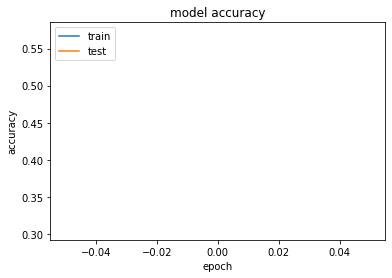

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


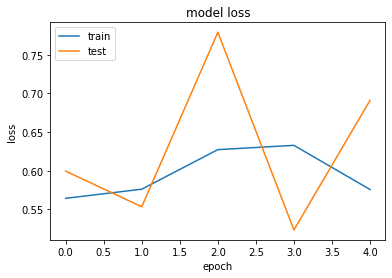

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Mejoras

- Data Augmentation

- Activación RELU entre capas de la arquitectura (Revisar arquitectura)

